In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gzip;
import StringIO;

1.Reading data

In [2]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO.StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = './ExtraSensory.per_uuid_features_labels/%s.features_labels.csv.gz' % uuid;

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;

    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [3]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);

In [4]:
print label_names

['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'SLEEPING', 'LAB_WORK', 'IN_CLASS', 'IN_A_MEETING', 'LOC_main_workplace', 'OR_indoors', 'OR_outside', 'IN_A_CAR', 'ON_A_BUS', 'DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER', 'LOC_home', 'FIX_restaurant', 'PHONE_IN_POCKET', 'OR_exercise', 'COOKING', 'SHOPPING', 'STROLLING', 'DRINKING__ALCOHOL_', 'BATHING_-_SHOWER', 'CLEANING', 'DOING_LAUNDRY', 'WASHING_DISHES', 'WATCHING_TV', 'SURFING_THE_INTERNET', 'AT_A_PARTY', 'AT_A_BAR', 'LOC_beach', 'SINGING', 'TALKING', 'COMPUTER_WORK', 'EATING', 'TOILET', 'GROOMING', 'DRESSING', 'AT_THE_GYM', 'STAIRS_-_GOING_UP', 'STAIRS_-_GOING_DOWN', 'ELEVATOR', 'OR_standing', 'AT_SCHOOL', 'PHONE_IN_HAND', 'PHONE_IN_BAG', 'PHONE_ON_TABLE', 'WITH_CO-WORKERS', 'WITH_FRIENDS']


In [5]:
n_examples_per_label = np.sum(Y,axis=0);
labels_and_counts = zip(label_names,n_examples_per_label);
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
for (label,count) in sorted_labels_and_counts:
    print "label %s - %d minutes" % (label,count);
    pass;

label PHONE_ON_TABLE - 2076 minutes
label SITTING - 1543 minutes
label OR_indoors - 1455 minutes
label LOC_home - 1438 minutes
label LYING_DOWN - 748 minutes
label TALKING - 653 minutes
label SLEEPING - 633 minutes
label LOC_main_workplace - 591 minutes
label PHONE_IN_POCKET - 394 minutes
label EATING - 310 minutes
label WATCHING_TV - 257 minutes
label SURFING_THE_INTERNET - 242 minutes
label OR_standing - 231 minutes
label FIX_walking - 158 minutes
label OR_outside - 126 minutes
label WITH_FRIENDS - 109 minutes
label PHONE_IN_HAND - 106 minutes
label COMPUTER_WORK - 85 minutes
label WITH_CO-WORKERS - 82 minutes
label DRESSING - 57 minutes
label COOKING - 47 minutes
label WASHING_DISHES - 46 minutes
label ON_A_BUS - 42 minutes
label GROOMING - 36 minutes
label DRIVE_-_I_M_THE_DRIVER - 35 minutes
label TOILET - 35 minutes
label AT_SCHOOL - 32 minutes
label IN_A_CAR - 30 minutes
label DRINKING__ALCOHOL_ - 28 minutes
label IN_A_MEETING - 21 minutes
label DRIVE_-_I_M_A_PASSENGER - 20 minut

In [6]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;


In [7]:
print "How many examples does this user have for each contex-label:";
print "-"*20;
for (label,count) in sorted_labels_and_counts:
    print "%s - %d minutes" % (get_label_pretty_name(label),count);
    pass;

How many examples does this user have for each contex-label:
--------------------
Phone on table - 2076 minutes
Sitting - 1543 minutes
Indoors - 1455 minutes
At home - 1438 minutes
Lying down - 748 minutes
Talking - 653 minutes
Sleeping - 633 minutes
At main workplace - 591 minutes
Phone in pocket - 394 minutes
Eating - 310 minutes
Watching TV - 257 minutes
Surfing the internet - 242 minutes
Standing - 231 minutes
Walking - 158 minutes
Outside - 126 minutes
With friends - 109 minutes
Phone in hand - 106 minutes
Computer work - 85 minutes
With co-workers - 82 minutes
Dressing - 57 minutes
Cooking - 47 minutes
Washing dishes - 46 minutes
On a bus - 42 minutes
Grooming - 36 minutes
Drive - I'm the driver - 35 minutes
Toilet - 35 minutes
At school - 32 minutes
In a car - 30 minutes
Drinking (alcohol) - 28 minutes
In a meeting - 21 minutes
Drive - I'm a passenger - 20 minutes
Bathing - shower - 11 minutes
Strolling - 6 minutes
Singing - 6 minutes
Shopping - 5 minutes
At a restaurant - 3 min

In [8]:
def figure__pie_chart(Y,label_names,labels_to_display,title_str,ax):
    portion_of_time = np.mean(Y,axis=0);
    portions_to_display = [portion_of_time[label_names.index(label)] for label in labels_to_display];
    pretty_labels_to_display = [get_label_pretty_name(label) for label in labels_to_display];
    ax.pie(portions_to_display,labels=pretty_labels_to_display,autopct='%.2f%%');
    ax.axis('equal');
    plt.title(title_str);
    return;

Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.
For instance, the users did not always report the position of the phone.


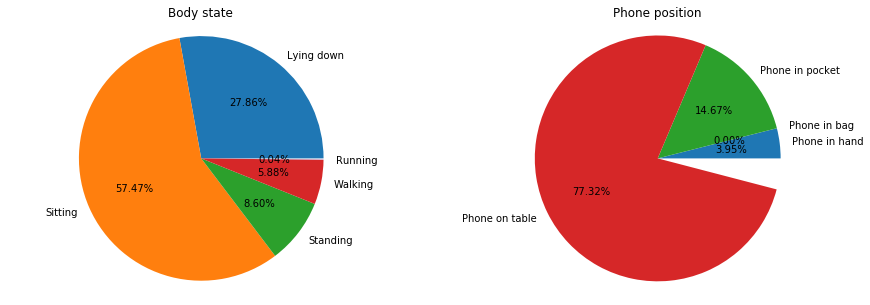

In [9]:
print("Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.");
print("For instance, the users did not always report the position of the phone.");
fig = plt.figure(figsize=(15,5),facecolor='white');

ax1 = plt.subplot(1,2,1);
labels_to_display = ['LYING_DOWN','SITTING','OR_standing','FIX_walking','FIX_running'];
figure__pie_chart(Y,label_names,labels_to_display,'Body state',ax1);

ax2 = plt.subplot(1,2,2);
labels_to_display = ['PHONE_IN_HAND','PHONE_IN_BAG','PHONE_IN_POCKET','PHONE_ON_TABLE'];
figure__pie_chart(Y,label_names,labels_to_display,'Phone position',ax2);

In [10]:
def get_actual_date_labels(tick_seconds):
    import datetime;
    import pytz;
    
    time_zone = pytz.timezone('US/Pacific'); # Assuming the data comes from PST time zone
    weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'];
    datetime_labels = [];
    for timestamp in tick_seconds:
        tick_datetime = datetime.datetime.fromtimestamp(timestamp,tz=time_zone);
        weekday_str = weekday_names[tick_datetime.weekday()];
        time_of_day = tick_datetime.strftime('%I:%M%p');
        datetime_labels.append('%s\n%s' % (weekday_str,time_of_day));
        pass;
    
    return datetime_labels;
    
def figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors,use_actual_dates=False):

    fig = plt.figure(figsize=(10,7),facecolor='white');
    ax = plt.subplot(1,1,1);
    
    seconds_in_day = (60*60*24);

    ylabels = [];
    ax.plot(timestamps,len(ylabels)*np.ones(len(timestamps)),'|',color='0.5',label='(Collected data)');
    ylabels.append('(Collected data)');

    for (li,label) in enumerate(labels_to_display):
        lind = label_names.index(label);
        is_label_on = Y[:,lind];
        label_times = timestamps[is_label_on];

        label_str = get_label_pretty_name(label);
        ax.plot(label_times,len(ylabels)*np.ones(len(label_times)),'|',color=label_colors[li],label=label_str);
        ylabels.append(label_str);
        pass;

    tick_seconds = range(timestamps[0],timestamps[-1],seconds_in_day);
    if use_actual_dates:
        tick_labels = get_actual_date_labels(tick_seconds);
        plt.xlabel('Time in San Diego',fontsize=14);
        pass;
    else:
        tick_labels = (np.array(tick_seconds - timestamps[0]).astype(float) / float(seconds_in_day)).astype(int);
        plt.xlabel('days of participation',fontsize=14);
        pass;
    
    ax.set_xticks(tick_seconds);
    ax.set_xticklabels(tick_labels,fontsize=14);

    ax.set_yticks(range(len(ylabels)));
    ax.set_yticklabels(ylabels,fontsize=14);

    ax.set_ylim([-1,len(ylabels)]);
    ax.set_xlim([min(timestamps),max(timestamps)]);
    
    return;

Here is a track of when the user was engaged in different contexts.
The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time).
The context-labels annotations were self-reported by ther user (and then cleaned by the researchers).


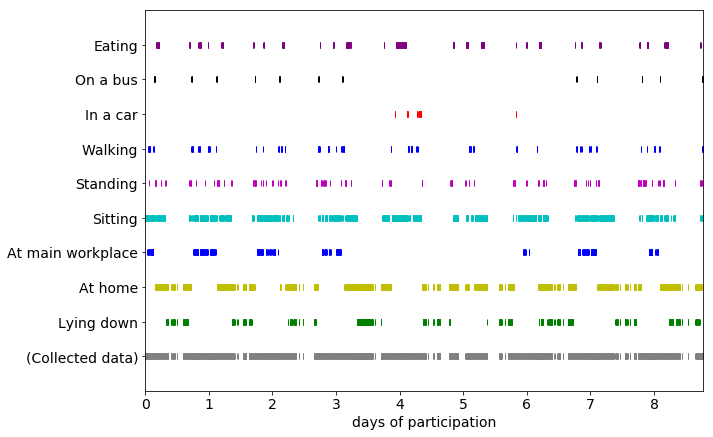

In [11]:
print("Here is a track of when the user was engaged in different contexts.");
print("The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time).");
print("The context-labels annotations were self-reported by ther user (and then cleaned by the researchers).")

labels_to_display = ['LYING_DOWN','LOC_home','LOC_main_workplace','SITTING','OR_standing','FIX_walking',\
                     'IN_A_CAR','ON_A_BUS','EATING'];
label_colors = ['g','y','b','c','m','b','r','k','purple'];
figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors);

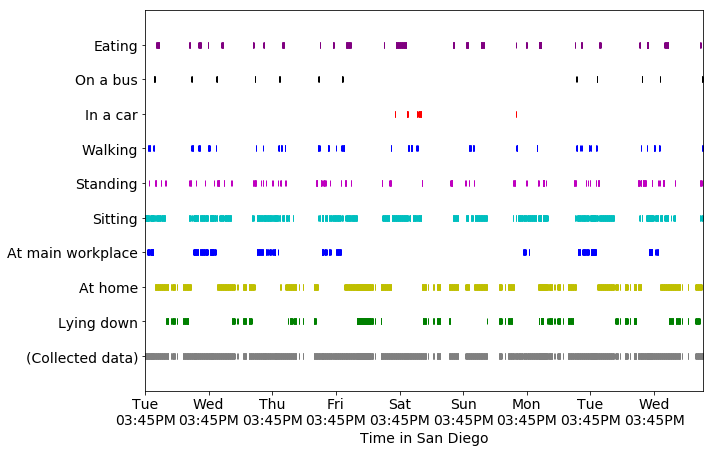

In [12]:
figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors,use_actual_dates=True);

In [13]:
def jaccard_similarity_for_label_pairs(Y):
    (n_examples,n_labels) = Y.shape;
    Y = Y.astype(int);
    # For each label pair, count cases of:
    # Intersection (co-occurrences) - cases when both labels apply:
    both_labels_counts = np.dot(Y.T,Y);
    # Cases where neither of the two labels applies:
    neither_label_counts = np.dot((1-Y).T,(1-Y));
    # Union - cases where either of the two labels (or both) applies (this is complement of the 'neither' cases):
    either_label_counts = n_examples - neither_label_counts;
    # Jaccard similarity - intersection over union:
    J = np.where(either_label_counts > 0, both_labels_counts.astype(float) / either_label_counts, 0.);
    return J;

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


Label-pairs with higher color value tend to occur together more.


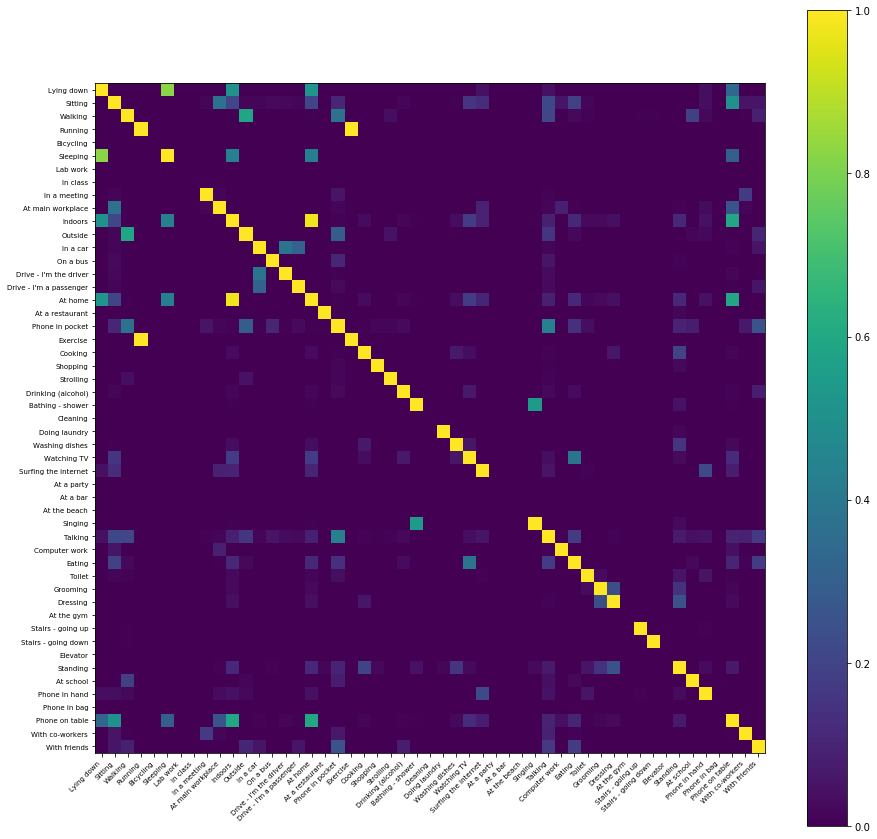

In [14]:
J = jaccard_similarity_for_label_pairs(Y);

print("Label-pairs with higher color value tend to occur together more.");

fig = plt.figure(figsize=(15,15),facecolor='white');
ax = plt.subplot(1,1,1);
plt.imshow(J,interpolation='none');plt.colorbar();

pretty_label_names = [get_label_pretty_name(label) for label in label_names];
n_labels = len(label_names);
ax.set_xticks(range(n_labels));
ax.set_xticklabels(pretty_label_names,rotation=45,ha='right',fontsize=7);
ax.set_yticks(range(n_labels));
ax.set_yticklabels(pretty_label_names,fontsize=7);

In [15]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;    

In [16]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


In [17]:
def figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds):
    seconds_in_day = (60*60*24);
    days_since_participation = (timestamps - timestamps[0]) / float(seconds_in_day);
    
    for ind in feature_inds:
        feature = feature_names[ind];
        feat_values = X[:,ind];
        
        fig = plt.figure(figsize=(10,3),facecolor='white');
        
        ax1 = plt.subplot(1,2,1);
        ax1.plot(days_since_participation,feat_values,'.-',markersize=3,linewidth=0.1);
        plt.xlabel('days of participation');
        plt.ylabel('feature value');
        plt.title('%d) %s\nfunction of time' % (ind,feature));
        
        ax1 = plt.subplot(1,2,2);
        existing_feature = np.logical_not(np.isnan(feat_values));
        ax1.hist(feat_values[existing_feature],bins=30);
        plt.xlabel('feature value');
        plt.ylabel('count');
        plt.title('%d) %s\nhistogram' % (ind,feature));
        
        pass;
    
    return;

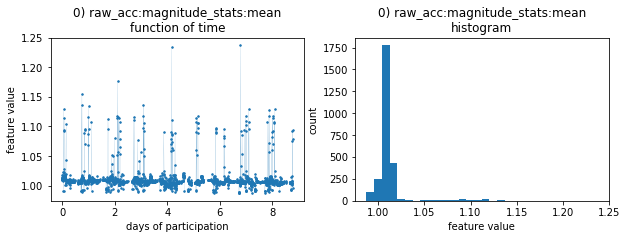

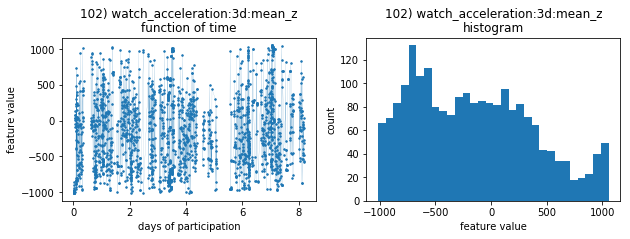

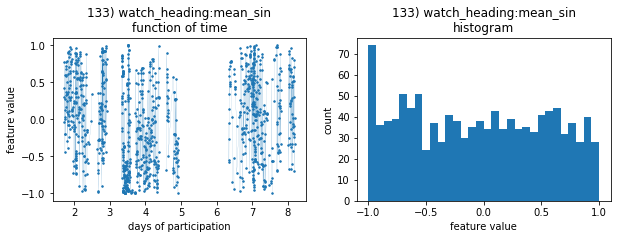

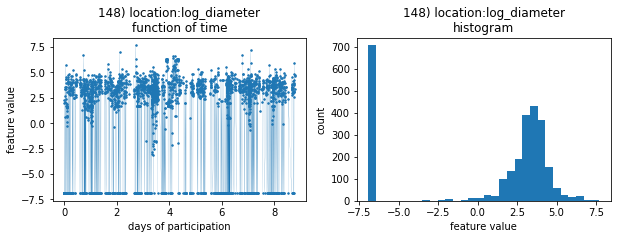

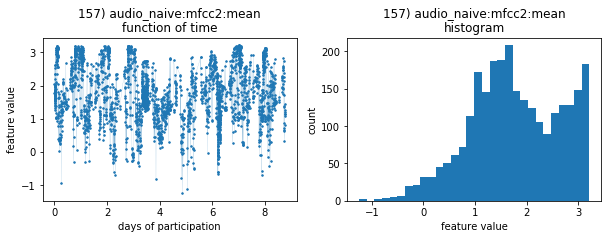

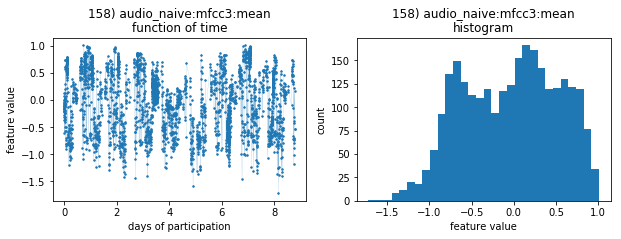

In [18]:
feature_inds = [0,102,133,148,157,158];
figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds);

The phone-state (PS) features are represented as binary indicators:


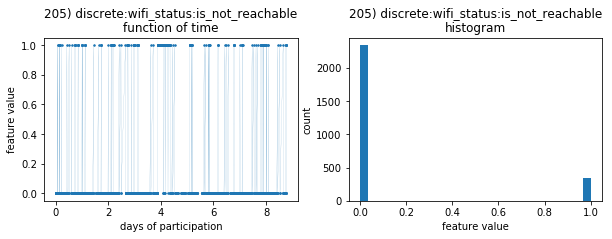

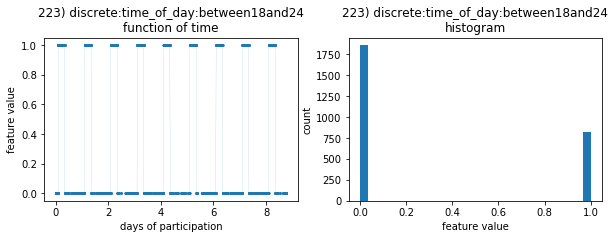

In [19]:
print("The phone-state (PS) features are represented as binary indicators:");
feature_inds = [205,223];
figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds);

Relation between sensor fetures and context label

In [20]:
def figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map):
    feat_ind1 = feature_names.index(feature1);
    feat_ind2 = feature_names.index(feature2);
    example_has_feature1 = np.logical_not(np.isnan(X[:,feat_ind1]));
    example_has_feature2 = np.logical_not(np.isnan(X[:,feat_ind2]));
    example_has_features12 = np.logical_and(example_has_feature1,example_has_feature2);
    
    fig = plt.figure(figsize=(12,5),facecolor='white');
    ax1 = plt.subplot(1,2,1);
    ax2 = plt.subplot(2,2,2);
    ax3 = plt.subplot(2,2,4);
    
    for label in label2color_map.keys():
        label_ind = label_names.index(label);
        pretty_name = get_label_pretty_name(label);
        color = label2color_map[label];
        style = '.%s' % color;
        
        is_relevant_example = np.logical_and(example_has_features12,Y[:,label_ind]);
        count = sum(is_relevant_example);
        feat1_vals = X[is_relevant_example,feat_ind1];
        feat2_vals = X[is_relevant_example,feat_ind2];
        ax1.plot(feat1_vals,feat2_vals,style,markersize=5,label=pretty_name);
        
        ax2.hist(X[is_relevant_example,feat_ind1],bins=20,normed=True,color=color,alpha=0.5,label='%s (%d)' % (pretty_name,count));
        ax3.hist(X[is_relevant_example,feat_ind2],bins=20,normed=True,color=color,alpha=0.5,label='%s (%d)' % (pretty_name,count));
        pass;
    
    ax1.set_xlabel(feature1);
    ax1.set_ylabel(feature2);
    
    ax2.set_title(feature1);
    ax3.set_title(feature2);
    
    ax2.legend(loc='best');
    
    return;

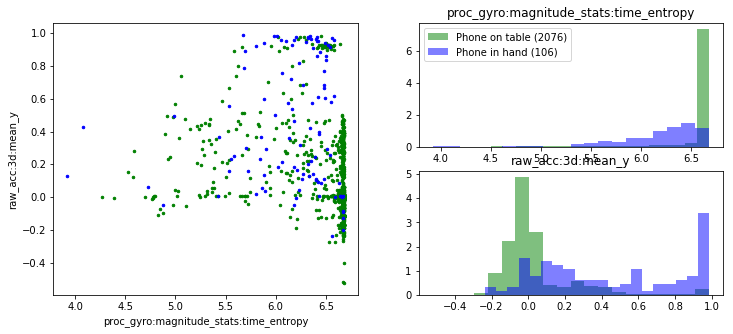

In [21]:
feature1 = 'proc_gyro:magnitude_stats:time_entropy';#raw_acc:magnitude_autocorrelation:period';
feature2 = 'raw_acc:3d:mean_y';
label2color_map = {'PHONE_IN_HAND':'b','PHONE_ON_TABLE':'g'};
figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map);

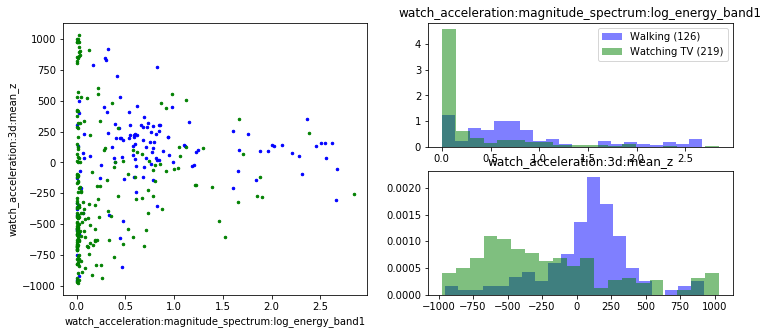

In [22]:
feature1 = 'watch_acceleration:magnitude_spectrum:log_energy_band1';
feature2 = 'watch_acceleration:3d:mean_z';
label2color_map = {'FIX_walking':'b','WATCHING_TV':'g'};
figure__feature_scatter_for_labels(X,Y,feature_names,label_names,feature1,feature2,label2color_map);

2.Design models and apply them in a single user dataset

In [23]:
import sklearn.linear_model;

def project_features_to_selected_sensors(X,feat_sensor_names,sensors_to_use):
    use_feature = np.zeros(len(feat_sensor_names),dtype=bool);
    for sensor in sensors_to_use:
        is_from_sensor = (feat_sensor_names == sensor);
        use_feature = np.logical_or(use_feature,is_from_sensor);
        pass;
    X = X[:,use_feature];
    return X;

def estimate_standardization_params(X_train):
    mean_vec = np.nanmean(X_train,axis=0);
    std_vec = np.nanstd(X_train,axis=0);
    return (mean_vec,std_vec);

def standardize_features(X,mean_vec,std_vec):
    # Subtract the mean, to centralize all features around zero:
    X_centralized = X - mean_vec.reshape((1,-1));
    # Divide by the standard deviation, to get unit-variance for all features:
    # * Avoid dividing by zero, in case some feature had estimate of zero variance
    normalizers = np.where(std_vec > 0., std_vec, 1.).reshape((1,-1));
    X_standard = X_centralized / normalizers;
    return X_standard;
#train part of LR model
def train_lr_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    print X_train.shape
    # The single target label:
    label_ind = label_names.index(target_label);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing_label,:];
    y = y[existing_label];
    
    print X_train.shape
    print y.shape
    
    #If there is no example
    if len(y) == 0:
        lr_model = None;
        # Assemble all the parts of the model:
        model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'lr_model':lr_model};
        return model;
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Now, we have the input features and the ground truth for the output label.
    # We can train a logistic regression model.
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    lr_model = sklearn.linear_model.LogisticRegression(class_weight='balanced');
    lr_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'lr_model':lr_model};
    
    return model;

In [24]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Compass','Aud'];
target_label = 'LYING_DOWN';
model = train_lr_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2685, 164)
(2681, 164)
(2681,)
== Training with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.


In [25]:
#test part for LR model
def test_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['lr_model'] == None:
        return (1.0,1.0,1.0);
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['lr_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    sensitivity = float(tp) / (tp+fn);
    specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    print('* The accuracy metric is misleading - it is dominated by the negative examples (typically there are many more negatives).')
    print('** Precision is very sensitive to rare labels. It can cause misleading results when averaging precision over different labels.')
    
    fig = plt.figure(figsize=(10,4),facecolor='white');
    ax = plt.subplot(1,1,1);
    ax.plot(timestamps[y],1.4*np.ones(sum(y)),'|g',markersize=10,label='ground truth');
    ax.plot(timestamps[y_pred],np.ones(sum(y_pred)),'|b',markersize=10,label='prediction');
    
    seconds_in_day = (60*60*24);
    tick_seconds = range(timestamps[0],timestamps[-1],seconds_in_day);
    tick_labels = (np.array(tick_seconds - timestamps[0]).astype(float) / float(seconds_in_day)).astype(int);
    
    ax.set_ylim([0.5,5]);
    ax.set_xticks(tick_seconds);
    ax.set_xticklabels(tick_labels);
    plt.xlabel('days of participation',fontsize=14);
    ax.legend(loc='best');
    plt.title('%s\nGround truth vs. predicted' % get_label_pretty_name(model['target_label']));
    
    return(accuracy,balanced_accuracy,precision);

In [26]:
#test part for LR model
def test_lr_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['lr_model'] == None:
        return (1.0,1.0,1.0);
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['lr_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [27]:
(a,b,p) = test_lr_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681,)
== Testing with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.
----------
Accuracy*:         0.95
Sensitivity (TPR): 0.94
Specificity (TNR): 0.95
Balanced accuracy: 0.94
Precision**:       0.88
----------


In [28]:
def validate_column_names_are_consistent(old_column_names,new_column_names):
    if len(old_column_names) != len(new_column_names):
        raise ValueError("!!! Inconsistent number of columns.");
        
    for ci in range(len(old_column_names)):
        if old_column_names[ci] != new_column_names[ci]:
            raise ValueError("!!! Inconsistent column %d) %s != %s" % (ci,old_column_names[ci],new_column_names[ci]));
        pass;
    return;

In [29]:
uuid = '11B5EC4D-4133-4289-B475-4E737182A406';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [30]:
(a,b,p) = test_lr_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(5503, 164)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.43
Specificity (TNR): 0.89
Balanced accuracy: 0.66
Precision**:       0.81
----------


In [31]:
#train part of mlp model
import sklearn.neural_network

def train_mlp_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    print X_train.shape;
    # The single target label:
    label_ind = [label_names.index(label) for label in target_label];
    index_length = len(label_ind);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    #Find all examples that are missing any of target labels:
    existing = existing_label[:,0];
    
    for i in range(1,index_length):
        existing = np.logical_and(existing,existing_label[:,i]);
    print existing.shape;
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing,:];
    y = y[existing];
    
    print X_train.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        mlp_model = None;
        # Assemble all the parts of the model:
        model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'mlp_model':mlp_model};
        return model;
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    #print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
    #      (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    mlp_model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(8,8), max_iter=200, alpha=0.0001,\
                     solver='sgd', learning_rate_init=0.01, verbose= 1,\
                     tol=0.0001, momentum=0.8);
    mlp_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'mlp_model':mlp_model};
    
    return model;

In [32]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Compass','Aud'];
#since it can be used for multi-classification
#so that the target_label is a list
target_label = ['LYING_DOWN'];
model = train_mlp_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);
#print model

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2685, 164)
(2685,)
(2681, 164)
(2681, 1)
Iteration 1, loss = 0.55796957
Iteration 2, loss = 0.50595314
Iteration 3, loss = 0.45667355
Iteration 4, loss = 0.39462775
Iteration 5, loss = 0.33282525
Iteration 6, loss = 0.28999600
Iteration 7, loss = 0.26291655
Iteration 8, loss = 0.24608380
Iteration 9, loss = 0.23419835
Iteration 10, loss = 0.22483037
Iteration 11, loss = 0.21735070
Iteration 12, loss = 0.21070781
Iteration 13, loss = 0.20493728
Iteration 14, loss = 0.19973141
Iteration 15, loss = 0.19511437
Iteration 16, loss = 0.19049033
Iteration 17, loss = 0.18653665
Iteration 18, loss = 0.18284786
Iteration 19, loss = 0.17934788


/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 20, loss = 0.17607471
Iteration 21, loss = 0.17318162
Iteration 22, loss = 0.17023914
Iteration 23, loss = 0.16748085
Iteration 24, loss = 0.16478121
Iteration 25, loss = 0.16239965
Iteration 26, loss = 0.15984556
Iteration 27, loss = 0.15740444
Iteration 28, loss = 0.15533050
Iteration 29, loss = 0.15307047
Iteration 30, loss = 0.15118441
Iteration 31, loss = 0.14901031
Iteration 32, loss = 0.14684988
Iteration 33, loss = 0.14489335
Iteration 34, loss = 0.14265361
Iteration 35, loss = 0.14078920
Iteration 36, loss = 0.13859317
Iteration 37, loss = 0.13664721
Iteration 38, loss = 0.13453671
Iteration 39, loss = 0.13266149
Iteration 40, loss = 0.13063806
Iteration 41, loss = 0.12875937
Iteration 42, loss = 0.12670508
Iteration 43, loss = 0.12503105
Iteration 44, loss = 0.12337145
Iteration 45, loss = 0.12210768
Iteration 46, loss = 0.12062977
Iteration 47, loss = 0.11912615
Iteration 48, loss = 0.11768371
Iteration 49, loss = 0.11628337
Iteration 50, loss = 0.11518206
Iteratio

/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [33]:
#test part of mlp model
def test_mlp_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['mlp_model'] == None:
        return (1.0,1.0,1.0);
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The target label:
    target_label = model['target_label'];
    label_ind = [label_names.index(label) for label in target_label];
    index_length = len(label_ind);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    #Find all examples that are missing any of target labels:
    existing = existing_label[:,0];
    for i in range(1,index_length):
        existing = np.logical_and(existing,existing_label[:,i]);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing,:];
    y = y[existing];
    timestamps = timestamps[existing];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples." % len(y));
    
    # Preform the prediction:
    y_pred = model['mlp_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [34]:
uuid = '11B5EC4D-4133-4289-B475-4E737182A406';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [35]:
(a,b,p) = test_mlp_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681, 1)
== Testing with 2681 examples.
----------
Accuracy*:         0.60
Sensitivity (TPR): 0.27
Specificity (TNR): 0.73
Balanced accuracy: 0.50
Precision**:       0.28
----------


In [36]:
(a,b,p) = test_mlp_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(5503, 164)
(5503, 1)
== Testing with 5503 examples.
----------
Accuracy*:         0.48
Sensitivity (TPR): 0.22
Specificity (TNR): 0.78
Balanced accuracy: 0.50
Precision**:       0.54
----------


In [37]:
#train part of svm
import sklearn.svm

def train_svm_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    print X_train.shape
    # The single target label:
    label_ind = label_names.index(target_label);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing_label,:];
    y = y[existing_label];
    
    print X_train.shape
    print y.shape
    
    #If there is no example
    if len(y) == 0:
        svm_model = None;
        # Assemble all the parts of the model:
        model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'svm_model':lr_model};
        return model;
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Now, we have the input features and the ground truth for the output label.
    # We can train a logistic regression model.
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    svm_model = sklearn.svm.SVC(kernel='rbf',tol=0.0001,class_weight='balanced');
    svm_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'svm_model':svm_model};
    
    return model;

In [38]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Compass','Aud'];
target_label = 'LYING_DOWN';
model = train_svm_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);
#print model

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2685, 164)
(2681, 164)
(2681,)
== Training with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.


In [39]:
#test part of svm
def test_svm_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['svm_model'] == None:
        return (1.0,1.0,1.0);
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['svm_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [40]:
uuid = '11B5EC4D-4133-4289-B475-4E737182A406';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [41]:
(a,b,p) = test_svm_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681,)
== Testing with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.
----------
Accuracy*:         0.97
Sensitivity (TPR): 0.96
Specificity (TNR): 0.98
Balanced accuracy: 0.97
Precision**:       0.94
----------


In [42]:
(a,b,p) = test_svm_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(5503, 164)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------


In [43]:
#train part of decision tree
import sklearn.tree

def train_dt_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    print X_train.shape
    # The single target label:
    label_ind = label_names.index(target_label);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing_label,:];
    y = y[existing_label];
    
    print X_train.shape
    print y.shape
    
    #If there is no example
    if len(y) == 0:
        dt_model = None;
        # Assemble all the parts of the model:
        model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'dt_model':lr_model};
        return model;
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Now, we have the input features and the ground truth for the output label.
    # We can train a logistic regression model.
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    dt_model = sklearn.tree.DecisionTreeClassifier(class_weight='balanced');
    dt_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'dt_model':dt_model};
    
    return model;

In [44]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Compass','Aud'];
target_label = 'LYING_DOWN';
model = train_dt_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);
#print model

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2685, 164)
(2681, 164)
(2681,)
== Training with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.


In [45]:
#test part of decision tree
def test_dt_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['dt_model'] == None:
        return (1.0,1.0,1.0);
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['dt_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [46]:
uuid = '11B5EC4D-4133-4289-B475-4E737182A406';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [47]:
(a,b,p) = test_dt_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681,)
== Testing with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.
----------
Accuracy*:         1.00
Sensitivity (TPR): 1.00
Specificity (TNR): 1.00
Balanced accuracy: 1.00
Precision**:       1.00
----------


In [48]:
(a,b,p) = test_dt_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(5503, 164)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.52
Sensitivity (TPR): 0.18
Specificity (TNR): 0.91
Balanced accuracy: 0.55
Precision**:       0.70
----------


In [49]:
#train part of random forest
import sklearn.ensemble

def train_rf_model(X_train,Y_train,M_train,feat_sensor_names,label_names,sensors_to_use,target_label):
    # Project the feature matrix to the features from the desired sensors:
    X_train = project_features_to_selected_sensors(X_train,feat_sensor_names,sensors_to_use);
    print("== Projected the features to %d features from the sensors: %s" % (X_train.shape[1],', '.join(sensors_to_use)));

    # It is recommended to standardize the features (subtract mean and divide by standard deviation),
    # so that all their values will be roughly in the same range:
    (mean_vec,std_vec) = estimate_standardization_params(X_train);
    X_train = standardize_features(X_train,mean_vec,std_vec);
    print X_train.shape
    # The single target label:
    label_ind = label_names.index(target_label);
    y = Y_train[:,label_ind];
    missing_label = M_train[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_train = X_train[existing_label,:];
    y = y[existing_label];
    
    print X_train.shape
    print y.shape
    
    #If there is no example
    if len(y) == 0:
        rf_model = None;
        # Assemble all the parts of the model:
        model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'rf_model':lr_model};
        return model;
    
    # Also, there may be missing sensor-features (represented in the data as NaN).
    # You can handle those by imputing a value of zero (since we standardized, this is equivalent to assuming average value).
    # You can also further select examples - only those that have values for all the features.
    # For this tutorial, let's use the simple heuristic of zero-imputation:
    X_train[np.isnan(X_train)] = 0.;
    
    print("== Training with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Now, we have the input features and the ground truth for the output label.
    # We can train a logistic regression model.
    
    # Typically, the data is highly imbalanced, with many more negative examples;
    # To avoid a trivial classifier (one that always declares 'no'), it is important to counter-balance the pos/neg classes:
    rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10,class_weight='balanced');
    rf_model.fit(X_train,y);
    
    # Assemble all the parts of the model:
    model = {\
            'sensors_to_use':sensors_to_use,\
            'target_label':target_label,\
            'mean_vec':mean_vec,\
            'std_vec':std_vec,\
            'rf_model':rf_model};
    
    return model;

In [50]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Compass','Aud'];
target_label = 'LYING_DOWN';
model = train_rf_model(X,Y,M,feat_sensor_names,label_names,sensors_to_use,target_label);
#print model

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2685, 164)
(2681, 164)
(2681,)
== Training with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.


In [51]:
#test part of random forest
def test_rf_model(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['rf_model'] == None:
        return (1.0,1.0,1.0);
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return (1.0,1.0,1.0);
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['rf_model'].predict(X_test);
    
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [52]:
uuid = '11B5EC4D-4133-4289-B475-4E737182A406';
(X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);

# All the user data files should have the exact same columns. We can validate it:
validate_column_names_are_consistent(feature_names,feature_names2);
validate_column_names_are_consistent(label_names,label_names2);

In [53]:
(a,b,p) = test_rf_model(X,Y,M,timestamps,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681,)
== Testing with 2681 examples. For label 'Lying down' we have 748 positive and 1933 negative examples.
----------
Accuracy*:         1.00
Sensitivity (TPR): 0.99
Specificity (TNR): 1.00
Balanced accuracy: 1.00
Precision**:       1.00
----------


In [54]:
(a,b,p) = test_rf_model(X2,Y2,M2,timestamps2,feat_sensor_names,label_names,model);

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(5503, 164)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.00
Specificity (TNR): 0.98
Balanced accuracy: 0.49
Precision**:       0.20
----------


3.Do LOO cross validation

Get all uuids:

In [55]:
txtname = open('all_uuids.txt','r');
txtdata = txtname.read().splitlines();
txtname.close();
print len(txtdata)

60


Get trainset and testset:

In [56]:
def split_train_test_uuids(i,txtdata):
    test_uuid = txtdata[i];
    train_uuid = [data for j,data in enumerate(txtdata) if j != i];
    return (test_uuid,train_uuid);

In [57]:
(test_uuid,train_uuid) = split_train_test_uuids(0,txtdata);
print test_uuid
print
print len(train_uuid)

0BFC35E2-4817-4865-BFA7-764742302A2D

59


In [58]:
def get_train_test_set(test_uuid,train_uuid):
    uuid = train_uuid[0];
    (train_X,train_Y,train_M,train_time,train_feature,train_label) = read_user_data(uuid);
    for i in range(1,59):
        uuid=train_uuid[i];
        (X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);
        train_X = np.concatenate((train_X,X2),axis=0);
        train_Y = np.concatenate((train_Y,Y2),axis=0);
        train_M = np.concatenate((train_M,M2),axis=0);
        train_time = np.concatenate((train_time,timestamps2),axis=0);
        train_feature = np.concatenate((train_feature,feature_names2),axis=0);
        train_label = np.concatenate((train_label,label_names2),axis=0);
    uuid = test_uuid;
    (test_X,test_Y,test_M,test_time,test_feature,test_label) = read_user_data(uuid);
    return (train_X,train_Y,train_M,train_time,train_feature,train_label,\
           test_X,test_Y,test_M,test_time,test_feature,test_label);

For LR Model:

In [116]:
sensors_to_use = ['Acc','WAcc'];
target_label = 'LYING_DOWN';
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set(test_uuid,train_uuid);
    #print test_X.shape;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                              label_names,sensors_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
     test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

== Projected the features to 72 features from the sensors: Acc, WAcc
(374238, 72)
(303723, 72)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(0, 72)
(0,)
== Projected the features to 72 features from the sensors: Acc, WAcc
(369825, 72)
(296247, 72)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(7476, 72)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
----------
Accuracy*:         0.84
Sensitivity (TPR): 0.90
Specificity (TNR): 0.82
Balanced accuracy: 0.86
Precision**:       0.64
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(374661, 72)
(301042, 72)
(301042,)
== Training with 301042 examples. For label 'Ly

== Projected the features to 72 features from the sensors: Acc, WAcc
(2654, 72)
(2654,)
== Testing with 2654 examples. For label 'Lying down' we have 1137 positive and 1517 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.83
Specificity (TNR): 0.73
Balanced accuracy: 0.78
Precision**:       0.69
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(371399, 72)
(300916, 72)
(300916,)
== Training with 300916 examples. For label 'Lying down' we have 103977 positive and 196939 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(2807, 72)
(2807,)
== Testing with 2807 examples. For label 'Lying down' we have 233 positive and 2574 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.47
Specificity (TNR): 0.86
Balanced accuracy: 0.66
Precision**:       0.23
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(369804, 72)
(296222, 72)
(296222,)
== Training 

== Projected the features to 72 features from the sensors: Acc, WAcc
(1835, 72)
(1835,)
== Testing with 1835 examples. For label 'Lying down' we have 339 positive and 1496 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.11
Specificity (TNR): 0.77
Balanced accuracy: 0.44
Precision**:       0.10
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(368874, 72)
(295638, 72)
(295638,)
== Training with 295638 examples. For label 'Lying down' we have 101096 positive and 194542 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(8085, 72)
(8085,)
== Testing with 8085 examples. For label 'Lying down' we have 3114 positive and 4971 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.76
Specificity (TNR): 0.55
Balanced accuracy: 0.65
Precision**:       0.51
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(375080, 72)
(301500, 72)
(301500,)
== Training 

== Projected the features to 72 features from the sensors: Acc, WAcc
(367660, 72)
(294327, 72)
(294327,)
== Training with 294327 examples. For label 'Lying down' we have 101463 positive and 192864 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(9396, 72)
(9396,)
== Testing with 9396 examples. For label 'Lying down' we have 2747 positive and 6649 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.90
Specificity (TNR): 0.82
Balanced accuracy: 0.86
Precision**:       0.68
----------
== Projected the features to 72 features from the sensors: Acc, WAcc
(371306, 72)
(299726, 72)
(299726,)
== Training with 299726 examples. For label 'Lying down' we have 103485 positive and 196241 negative examples.
== Projected the features to 72 features from the sensors: Acc, WAcc
(3997, 72)
(3997,)
== Testing with 3997 examples. For label 'Lying down' we have 725 positive and 3272 negative examples.
----------
Accuracy*:         0.71
Sensitiv

In [117]:
final_acc = np.mean(acc);
final_ba = np.mean(ba);
final_precise = np.mean(precise);
print final_acc;
print final_ba;
print final_precise;

0.755983124529
0.765930106175
0.576839368116


In [118]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print final_acc;
print final_ba;
print final_precise;

0.747568749513
0.757858730526
0.562247622189


For MLP Model:

In [81]:
sensors_to_use = ['Acc','WAcc','Gyro','Magnet','Loc','Aud'];
target_label = ['SITTING','LYING_DOWN','FIX_walking','OR_standing'];
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set(test_uuid,train_uuid);
    #print test_X.shape;
    model = train_mlp_model(train_X,train_Y,train_M,feat_sensor_names,\
                              label_names,sensors_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
     test_mlp_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(374238, 164)
(374238,)
(303723, 164)
(303723, 4)
Iteration 1, loss = 1.41847892
Iteration 2, loss = 1.28932290
Iteration 3, loss = 1.25872755
Iteration 4, loss = 1.24159521
Iteration 5, loss = 1.23077689
Iteration 6, loss = 1.22325487
Iteration 7, loss = 1.21690825
Iteration 8, loss = 1.21242754
Iteration 9, loss = 1.20921820
Iteration 10, loss = 1.20608379
Iteration 11, loss = 1.20428018
Iteration 12, loss = 1.20226312
Iteration 13, loss = 1.20025502
Iteration 14, loss = 1.19934240
Iteration 15, loss = 1.19784262
Iteration 16, loss = 1.19670192
Iteration 17, loss = 1.19535392
Iteration 18, loss = 1.19482669
Iteration 19, loss = 1.19345940
Iteration 20, loss = 1.19269927
Iteration 21, loss = 1.19182715
Iteration 22, loss = 1.19124339
Iteration 23, loss = 1.19078209
Iteration 24, loss = 1.18988781
Iteration 25, loss = 1.18868792
Iteration 26, loss = 1.18827799
Iteration 27, loss = 1.187474

Iteration 52, loss = 1.16662032
Iteration 53, loss = 1.16616785
Iteration 54, loss = 1.16556839
Iteration 55, loss = 1.16560815
Iteration 56, loss = 1.16566438
Iteration 57, loss = 1.16505329
Iteration 58, loss = 1.16532388
Iteration 59, loss = 1.16507934
Iteration 60, loss = 1.16510735
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(2681, 164)
(2681, 4)
== Testing with 2681 examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.68
Specificity (TNR): 0.93
Balanced accuracy: 0.80
Precision**:       0.75
----------
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(369971, 164)
(369971,)
(296531, 164)
(296531, 4)
Iteration 1, loss = 1.38454481
Iteration 2, loss = 1.25177563
Iteration 3, loss = 1.22565342
Iteration 4, loss = 1.21172558
Iteration 5, loss = 1.20283740
Iteration 6, loss = 1.197

Iteration 29, loss = 1.17876161
Iteration 30, loss = 1.17815113
Iteration 31, loss = 1.17752547
Iteration 32, loss = 1.17744458
Iteration 33, loss = 1.18110043
Iteration 34, loss = 1.17626720
Iteration 35, loss = 1.17627966
Iteration 36, loss = 1.17509664
Iteration 37, loss = 1.17550016
Iteration 38, loss = 1.17482215
Iteration 39, loss = 1.17382677
Iteration 40, loss = 1.17445539
Iteration 41, loss = 1.17325887
Iteration 42, loss = 1.17334236
Iteration 43, loss = 1.17303479
Iteration 44, loss = 1.17237327
Iteration 45, loss = 1.17291774
Iteration 46, loss = 1.17227837
Iteration 47, loss = 1.17137415
Iteration 48, loss = 1.17193968
Iteration 49, loss = 1.17172590
Iteration 50, loss = 1.17116370
Iteration 51, loss = 1.17099472
Iteration 52, loss = 1.17112968
Iteration 53, loss = 1.17039656
Iteration 54, loss = 1.16994894
Iteration 55, loss = 1.16976974
Iteration 56, loss = 1.17004299
Iteration 57, loss = 1.16979235
Iteration 58, loss = 1.16876287
Iteration 59, loss = 1.16811486
Iteratio

Iteration 6, loss = 1.22560672
Iteration 7, loss = 1.22098042
Iteration 8, loss = 1.21626650
Iteration 9, loss = 1.21279355
Iteration 10, loss = 1.20983799
Iteration 11, loss = 1.20731293
Iteration 12, loss = 1.20558756
Iteration 13, loss = 1.20332171
Iteration 14, loss = 1.20143363
Iteration 15, loss = 1.20002691
Iteration 16, loss = 1.19822514
Iteration 17, loss = 1.19736849
Iteration 18, loss = 1.19576143
Iteration 19, loss = 1.19493704
Iteration 20, loss = 1.19398627
Iteration 21, loss = 1.19334223
Iteration 22, loss = 1.19189765
Iteration 23, loss = 1.19136345
Iteration 24, loss = 1.19103478
Iteration 25, loss = 1.19048244
Iteration 26, loss = 1.18967485
Iteration 27, loss = 1.18897904
Iteration 28, loss = 1.18881834
Iteration 29, loss = 1.18804695
Iteration 30, loss = 1.18786915
Iteration 31, loss = 1.18715012
Iteration 32, loss = 1.18718970
Iteration 33, loss = 1.18638745
Iteration 34, loss = 1.18595395
Iteration 35, loss = 1.18562346
Iteration 36, loss = 1.18546199
Iteration 37

Iteration 83, loss = 1.15543563
Iteration 84, loss = 1.15494408
Iteration 85, loss = 1.15477486
Iteration 86, loss = 1.15462283
Iteration 87, loss = 1.15450208
Iteration 88, loss = 1.15445943
Iteration 89, loss = 1.15414729
Iteration 90, loss = 1.15374033
Iteration 91, loss = 1.15385483
Iteration 92, loss = 1.15401591
Iteration 93, loss = 1.15380819
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(6426, 164)
(6426, 4)
== Testing with 6426 examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.68
Specificity (TNR): 0.92
Balanced accuracy: 0.80
Precision**:       0.74
----------
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(372575, 164)
(372575,)
(300493, 164)
(300493, 4)
Iteration 1, loss = 1.43654316
Iteration 2, loss = 1.28583421
Iteration 3, loss = 1.24485918
Iteration 4, loss = 1.2

Iteration 42, loss = 1.16844247
Iteration 43, loss = 1.16800070
Iteration 44, loss = 1.16827608
Iteration 45, loss = 1.16750385
Iteration 46, loss = 1.16728558
Iteration 47, loss = 1.16694870
Iteration 48, loss = 1.16702008
Iteration 49, loss = 1.16663264
Iteration 50, loss = 1.16646769
Iteration 51, loss = 1.16602289
Iteration 52, loss = 1.16579345
Iteration 53, loss = 1.16542061
Iteration 54, loss = 1.16566604
Iteration 55, loss = 1.16549816
Iteration 56, loss = 1.16513896
Iteration 57, loss = 1.16527732
Iteration 58, loss = 1.16494942
Iteration 59, loss = 1.16439408
Iteration 60, loss = 1.16436724
Iteration 61, loss = 1.16410630
Iteration 62, loss = 1.16360672
Iteration 63, loss = 1.16339128
Iteration 64, loss = 1.16326612
Iteration 65, loss = 1.16344815
Iteration 66, loss = 1.16307004
Iteration 67, loss = 1.16263970
Iteration 68, loss = 1.16258249
Iteration 69, loss = 1.16238003
Iteration 70, loss = 1.16202959
Iteration 71, loss = 1.16236216
Iteration 72, loss = 1.16166935
Iteratio

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(371399, 164)
(371399,)
(300916, 164)
(300916, 4)
Iteration 1, loss = 1.41818150
Iteration 2, loss = 1.28729575
Iteration 3, loss = 1.25419473
Iteration 4, loss = 1.23822840
Iteration 5, loss = 1.22762777
Iteration 6, loss = 1.21831918
Iteration 7, loss = 1.21226055
Iteration 8, loss = 1.20764703
Iteration 9, loss = 1.20392494
Iteration 10, loss = 1.20165560
Iteration 11, loss = 1.19970600
Iteration 12, loss = 1.19768374
Iteration 13, loss = 1.19636626
Iteration 14, loss = 1.19479139
Iteration 15, loss = 1.19342668
Iteration 16, loss = 1.19194882
Iteration 17, loss = 1.19046174
Iteration 18, loss = 1.18921219
Iteration 19, loss = 1.18839101
Iteration 20, loss = 1.18753328
Iteration 21, loss = 1.18688312
Iteration 22, loss = 1.18560877
Iteration 23, loss = 1.18442662
Iteration 24, loss = 1.18397884
Iteration 25, loss = 1.18322347
Iteration 26, loss = 1.18274569
Iteration 27, loss = 1.182108

Iteration 2, loss = 1.28917017
Iteration 3, loss = 1.25322659
Iteration 4, loss = 1.23649266
Iteration 5, loss = 1.22669342
Iteration 6, loss = 1.21999333
Iteration 7, loss = 1.21442449
Iteration 8, loss = 1.21033702
Iteration 9, loss = 1.20682646
Iteration 10, loss = 1.20436627
Iteration 11, loss = 1.20236115
Iteration 12, loss = 1.20028263
Iteration 13, loss = 1.19773004
Iteration 14, loss = 1.19587466
Iteration 15, loss = 1.19361188
Iteration 16, loss = 1.19194316
Iteration 17, loss = 1.19033354
Iteration 18, loss = 1.18932787
Iteration 19, loss = 1.18792060
Iteration 20, loss = 1.18735193
Iteration 21, loss = 1.18649513
Iteration 22, loss = 1.18559784
Iteration 23, loss = 1.18519349
Iteration 24, loss = 1.18475177
Iteration 25, loss = 1.18403748
Iteration 26, loss = 1.18353315
Iteration 27, loss = 1.18305844
Iteration 28, loss = 1.18313028
Iteration 29, loss = 1.18226375
Iteration 30, loss = 1.18176322
Iteration 31, loss = 1.18181227
Iteration 32, loss = 1.18133588
Iteration 33, lo

Iteration 6, loss = 1.20869786
Iteration 7, loss = 1.20134867
Iteration 8, loss = 1.19606208
Iteration 9, loss = 1.19166279
Iteration 10, loss = 1.18825704
Iteration 11, loss = 1.18624415
Iteration 12, loss = 1.18387928
Iteration 13, loss = 1.18157481
Iteration 14, loss = 1.18054767
Iteration 15, loss = 1.17941152
Iteration 16, loss = 1.17811767
Iteration 17, loss = 1.17710364
Iteration 18, loss = 1.17609967
Iteration 19, loss = 1.17513753
Iteration 20, loss = 1.17423291
Iteration 21, loss = 1.17326595
Iteration 22, loss = 1.17245907
Iteration 23, loss = 1.17167851
Iteration 24, loss = 1.17058911
Iteration 25, loss = 1.17006281
Iteration 26, loss = 1.16954780
Iteration 27, loss = 1.16888733
Iteration 28, loss = 1.16849076
Iteration 29, loss = 1.16808159
Iteration 30, loss = 1.16744712
Iteration 31, loss = 1.16703685
Iteration 32, loss = 1.16647680
Iteration 33, loss = 1.16598192
Iteration 34, loss = 1.16570687
Iteration 35, loss = 1.16551471
Iteration 36, loss = 1.16521725
Iteration 37

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(371527, 164)
(371527,)
(301936, 164)
(301936, 4)
Iteration 1, loss = 1.44557751
Iteration 2, loss = 1.30698470
Iteration 3, loss = 1.26676637
Iteration 4, loss = 1.24407487
Iteration 5, loss = 1.23044199
Iteration 6, loss = 1.22086150
Iteration 7, loss = 1.21376211
Iteration 8, loss = 1.20726375
Iteration 9, loss = 1.20253143
Iteration 10, loss = 1.19958640
Iteration 11, loss = 1.19673572
Iteration 12, loss = 1.19387484
Iteration 13, loss = 1.19214933
Iteration 14, loss = 1.19044251
Iteration 15, loss = 1.18870950
Iteration 16, loss = 1.18747652
Iteration 17, loss = 1.18621794
Iteration 18, loss = 1.18527254
Iteration 19, loss = 1.18393793
Iteration 20, loss = 1.18306737
Iteration 21, loss = 1.18303938
Iteration 22, loss = 1.18177798
Iteration 23, loss = 1.18069625
Iteration 24, loss = 1.18039827
Iteration 25, loss = 1.17938018
Iteration 26, loss = 1.17895124
Iteration 27, loss = 1.178836

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(373448, 164)
(373448,)
(299943, 164)
(299943, 4)
Iteration 1, loss = 1.41375752
Iteration 2, loss = 1.28113455
Iteration 3, loss = 1.24625752
Iteration 4, loss = 1.22991216
Iteration 5, loss = 1.22035349
Iteration 6, loss = 1.21407704
Iteration 7, loss = 1.20958041
Iteration 8, loss = 1.20554345
Iteration 9, loss = 1.20272561
Iteration 10, loss = 1.19983343
Iteration 11, loss = 1.19706682
Iteration 12, loss = 1.19531447
Iteration 13, loss = 1.19329115
Iteration 14, loss = 1.19164221
Iteration 15, loss = 1.19011958
Iteration 16, loss = 1.18892761
Iteration 17, loss = 1.18795599
Iteration 18, loss = 1.18690663
Iteration 19, loss = 1.18606530
Iteration 20, loss = 1.18536865
Iteration 21, loss = 1.18455412
Iteration 22, loss = 1.18383006
Iteration 23, loss = 1.18323888
Iteration 24, loss = 1.18266464
Iteration 25, loss = 1.18195332
Iteration 26, loss = 1.18188108
Iteration 27, loss = 1.181191

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(368874, 164)
(368874,)
(295638, 164)
(295638, 4)
Iteration 1, loss = 1.45670479
Iteration 2, loss = 1.29341262
Iteration 3, loss = 1.25528733
Iteration 4, loss = 1.23934817
Iteration 5, loss = 1.23025995
Iteration 6, loss = 1.22371589
Iteration 7, loss = 1.21911556
Iteration 8, loss = 1.21539372
Iteration 9, loss = 1.21197029
Iteration 10, loss = 1.20923666
Iteration 11, loss = 1.20718656
Iteration 12, loss = 1.20563293
Iteration 13, loss = 1.20379188
Iteration 14, loss = 1.20245537
Iteration 15, loss = 1.20082736
Iteration 16, loss = 1.19929853
Iteration 17, loss = 1.19831253
Iteration 18, loss = 1.19750645
Iteration 19, loss = 1.19625010
Iteration 20, loss = 1.19496941
Iteration 21, loss = 1.19418347
Iteration 22, loss = 1.19307871
Iteration 23, loss = 1.19213850
Iteration 24, loss = 1.19118180
Iteration 25, loss = 1.19037802
Iteration 26, loss = 1.18927660
Iteration 27, loss = 1.188693

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(372143, 164)
(372143,)
(299955, 164)
(299955, 4)
Iteration 1, loss = 1.42960725
Iteration 2, loss = 1.26428207
Iteration 3, loss = 1.23131867
Iteration 4, loss = 1.21591156
Iteration 5, loss = 1.20564023
Iteration 6, loss = 1.19858081
Iteration 7, loss = 1.19362780
Iteration 8, loss = 1.18900567
Iteration 9, loss = 1.18575068
Iteration 10, loss = 1.18408014
Iteration 11, loss = 1.18192956
Iteration 12, loss = 1.18009646
Iteration 13, loss = 1.17855886
Iteration 14, loss = 1.17737916
Iteration 15, loss = 1.17652418
Iteration 16, loss = 1.17528359
Iteration 17, loss = 1.17459073
Iteration 18, loss = 1.17398356
Iteration 19, loss = 1.17309333
Iteration 20, loss = 1.17269200
Iteration 21, loss = 1.17209210
Iteration 22, loss = 1.17117273
Iteration 23, loss = 1.17034689
Iteration 24, loss = 1.17018164
Iteration 25, loss = 1.17010377
Iteration 26, loss = 1.16933792
Iteration 27, loss = 1.168805

Iteration 95, loss = 1.15932963
Iteration 96, loss = 1.15886462
Iteration 97, loss = 1.15908023
Iteration 98, loss = 1.15903672
Iteration 99, loss = 1.15890284
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(6004, 164)
(6004, 4)
== Testing with 6004 examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.59
Specificity (TNR): 0.91
Balanced accuracy: 0.75
Precision**:       0.68
----------
== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(370729, 164)
(370729,)
(297336, 164)
(297336, 4)
Iteration 1, loss = 1.42969243
Iteration 2, loss = 1.27392955
Iteration 3, loss = 1.23848604
Iteration 4, loss = 1.21904785
Iteration 5, loss = 1.20718628
Iteration 6, loss = 1.19871198
Iteration 7, loss = 1.19281494
Iteration 8, loss = 1.18792580
Iteration 9, loss = 1.18414298
Iteration 10, loss = 1.181952

Iteration 59, loss = 1.16853281
Iteration 60, loss = 1.16868833
Iteration 61, loss = 1.16836373
Iteration 62, loss = 1.16812220
Iteration 63, loss = 1.16768473
Iteration 64, loss = 1.16776006
Iteration 65, loss = 1.16772561
Iteration 66, loss = 1.16744223
Iteration 67, loss = 1.16723182
Iteration 68, loss = 1.16713743
Iteration 69, loss = 1.16678052
Iteration 70, loss = 1.16659373
Iteration 71, loss = 1.16657219
Iteration 72, loss = 1.16629155
Iteration 73, loss = 1.16620822
Iteration 74, loss = 1.16612430
Iteration 75, loss = 1.16577984
Iteration 76, loss = 1.16577145
Iteration 77, loss = 1.16554084
Iteration 78, loss = 1.16585930
Iteration 79, loss = 1.16548453
Iteration 80, loss = 1.16536132
Iteration 81, loss = 1.16537908
Iteration 82, loss = 1.16507593
Iteration 83, loss = 1.16462858
Iteration 84, loss = 1.16484306
Iteration 85, loss = 1.16469459
Iteration 86, loss = 1.16454854
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected 

Iteration 24, loss = 1.19173882
Iteration 25, loss = 1.19182399
Iteration 26, loss = 1.19104963
Iteration 27, loss = 1.19045401
Iteration 28, loss = 1.19007482
Iteration 29, loss = 1.18950185
Iteration 30, loss = 1.18898058
Iteration 31, loss = 1.18907403
Iteration 32, loss = 1.18860400
Iteration 33, loss = 1.18806163
Iteration 34, loss = 1.18809969
Iteration 35, loss = 1.18785311
Iteration 36, loss = 1.18755534
Iteration 37, loss = 1.18716954
Iteration 38, loss = 1.18666386
Iteration 39, loss = 1.18636065
Iteration 40, loss = 1.18636178
Iteration 41, loss = 1.18604840
Iteration 42, loss = 1.18549632
Iteration 43, loss = 1.18507499
Iteration 44, loss = 1.18509499
Iteration 45, loss = 1.18469740
Iteration 46, loss = 1.18443054
Iteration 47, loss = 1.18402716
Iteration 48, loss = 1.18438943
Iteration 49, loss = 1.18383293
Iteration 50, loss = 1.18382639
Iteration 51, loss = 1.18345074
Iteration 52, loss = 1.18324316
Iteration 53, loss = 1.18296857
Iteration 54, loss = 1.18257516
Iteratio

Iteration 3, loss = 1.25116283
Iteration 4, loss = 1.23619720
Iteration 5, loss = 1.22622123
Iteration 6, loss = 1.21972180
Iteration 7, loss = 1.21417336
Iteration 8, loss = 1.21005768
Iteration 9, loss = 1.20697854
Iteration 10, loss = 1.20446118
Iteration 11, loss = 1.20220958
Iteration 12, loss = 1.19995551
Iteration 13, loss = 1.19874332
Iteration 14, loss = 1.19754080
Iteration 15, loss = 1.19689076
Iteration 16, loss = 1.19549290
Iteration 17, loss = 1.19465182
Iteration 18, loss = 1.19374935
Iteration 19, loss = 1.19273472
Iteration 20, loss = 1.19215752
Iteration 21, loss = 1.19143285
Iteration 22, loss = 1.19065259
Iteration 23, loss = 1.19037543
Iteration 24, loss = 1.18992808
Iteration 25, loss = 1.18910810
Iteration 26, loss = 1.18851062
Iteration 27, loss = 1.18852780
Iteration 28, loss = 1.18789238
Iteration 29, loss = 1.18752905
Iteration 30, loss = 1.18676539
Iteration 31, loss = 1.18673566
Iteration 32, loss = 1.18618092
Iteration 33, loss = 1.18574082
Iteration 34, l

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(369826, 164)
(369826,)
(296251, 164)
(296251, 4)
Iteration 1, loss = 1.42026219
Iteration 2, loss = 1.27850596
Iteration 3, loss = 1.24440992
Iteration 4, loss = 1.22521590
Iteration 5, loss = 1.21496134
Iteration 6, loss = 1.20867197
Iteration 7, loss = 1.20375964
Iteration 8, loss = 1.20079635
Iteration 9, loss = 1.19778714
Iteration 10, loss = 1.19558866
Iteration 11, loss = 1.19359657
Iteration 12, loss = 1.19172766
Iteration 13, loss = 1.19021794
Iteration 14, loss = 1.18878640
Iteration 15, loss = 1.18748035
Iteration 16, loss = 1.18635478
Iteration 17, loss = 1.18514769
Iteration 18, loss = 1.18428247
Iteration 19, loss = 1.18300171
Iteration 20, loss = 1.18226433
Iteration 21, loss = 1.18205632
Iteration 22, loss = 1.18108708
Iteration 23, loss = 1.18030096
Iteration 24, loss = 1.18001038
Iteration 25, loss = 1.17974335
Iteration 26, loss = 1.17953103
Iteration 27, loss = 1.178654

== Projected the features to 164 features from the sensors: Acc, WAcc, Gyro, Magnet, Compass, Aud
(369037, 164)
(369037,)
(297836, 164)
(297836, 4)
Iteration 1, loss = 1.49316290
Iteration 2, loss = 1.30597506
Iteration 3, loss = 1.26106956
Iteration 4, loss = 1.23972311
Iteration 5, loss = 1.22657517
Iteration 6, loss = 1.21719005
Iteration 7, loss = 1.21029727
Iteration 8, loss = 1.20489957
Iteration 9, loss = 1.20046213
Iteration 10, loss = 1.19832872
Iteration 11, loss = 1.19570315
Iteration 12, loss = 1.19322444
Iteration 13, loss = 1.19158986
Iteration 14, loss = 1.19022871
Iteration 15, loss = 1.18878928
Iteration 16, loss = 1.18732627
Iteration 17, loss = 1.18610774
Iteration 18, loss = 1.18450970
Iteration 19, loss = 1.18327731
Iteration 20, loss = 1.18228789
Iteration 21, loss = 1.18118362
Iteration 22, loss = 1.18084948
Iteration 23, loss = 1.17985857
Iteration 24, loss = 1.17959072
Iteration 25, loss = 1.17885710
Iteration 26, loss = 1.17806057
Iteration 27, loss = 1.177782

Iteration 24, loss = 1.18178535
Iteration 25, loss = 1.18152442
Iteration 26, loss = 1.18061016
Iteration 27, loss = 1.18005295
Iteration 28, loss = 1.17951232
Iteration 29, loss = 1.17908463
Iteration 30, loss = 1.17873108
Iteration 31, loss = 1.17819352
Iteration 32, loss = 1.17785922
Iteration 33, loss = 1.17728045
Iteration 34, loss = 1.17692959
Iteration 35, loss = 1.17672581
Iteration 36, loss = 1.17661898
Iteration 37, loss = 1.17587518
Iteration 38, loss = 1.17566496
Iteration 39, loss = 1.17517644
Iteration 40, loss = 1.17525245
Iteration 41, loss = 1.17474027
Iteration 42, loss = 1.17428296
Iteration 43, loss = 1.17391881
Iteration 44, loss = 1.17374562
Iteration 45, loss = 1.17349046
Iteration 46, loss = 1.17311231
Iteration 47, loss = 1.17332478
Iteration 48, loss = 1.17259430
Iteration 49, loss = 1.17273977
Iteration 50, loss = 1.17301991
Iteration 51, loss = 1.17198137
Iteration 52, loss = 1.17228784
Iteration 53, loss = 1.17181296
Iteration 54, loss = 1.17166521
Iteratio

Iteration 46, loss = 1.17815916
Iteration 47, loss = 1.17789947
Iteration 48, loss = 1.17705219
Iteration 49, loss = 1.17638461
Iteration 50, loss = 1.17638260
Iteration 51, loss = 1.17606425
Iteration 52, loss = 1.17566336
Iteration 53, loss = 1.17516858
Iteration 54, loss = 1.17447034
Iteration 55, loss = 1.17417214
Iteration 56, loss = 1.17382284
Iteration 57, loss = 1.17440910
Iteration 58, loss = 1.17365808
Iteration 59, loss = 1.17322804
Iteration 60, loss = 1.17327433
Iteration 61, loss = 1.17316655
Iteration 62, loss = 1.17253167
Iteration 63, loss = 1.17261408
Iteration 64, loss = 1.17249067
Iteration 65, loss = 1.17176173
Iteration 66, loss = 1.17133707
Iteration 67, loss = 1.17122697
Iteration 68, loss = 1.17109358
Iteration 69, loss = 1.17098512
Iteration 70, loss = 1.17051977
Iteration 71, loss = 1.17032766
Iteration 72, loss = 1.17056647
Iteration 73, loss = 1.16998813
Iteration 74, loss = 1.16995807
Iteration 75, loss = 1.16982724
Iteration 76, loss = 1.16977779
Iteratio

Iteration 33, loss = 1.18168806
Iteration 34, loss = 1.18101713
Iteration 35, loss = 1.18028576
Iteration 36, loss = 1.17995320
Iteration 37, loss = 1.17881302
Iteration 38, loss = 1.17892122
Iteration 39, loss = 1.17866867
Iteration 40, loss = 1.17800412
Iteration 41, loss = 1.17754784
Iteration 42, loss = 1.17712352
Iteration 43, loss = 1.17655646
Iteration 44, loss = 1.17671075
Iteration 45, loss = 1.17618220
Iteration 46, loss = 1.17569899
Iteration 47, loss = 1.17559070
Iteration 48, loss = 1.17542123
Iteration 49, loss = 1.17510321
Iteration 50, loss = 1.17484276
Iteration 51, loss = 1.17435675
Iteration 52, loss = 1.17413613
Iteration 53, loss = 1.17365123
Iteration 54, loss = 1.17345839
Iteration 55, loss = 1.17295357
Iteration 56, loss = 1.17302969
Iteration 57, loss = 1.17300054
Iteration 58, loss = 1.17261662
Iteration 59, loss = 1.17225611
Iteration 60, loss = 1.17212326
Iteration 61, loss = 1.17164621
Iteration 62, loss = 1.17180950
Iteration 63, loss = 1.17143230
Iteratio

In [82]:
final_acc = np.mean(acc);
final_ba = np.mean(ba);
final_precise = np.mean(precise);
print final_acc;
print final_ba;
print final_precise;

0.838525888347
0.751766879211
0.704676783393


In [83]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print final_acc;
print final_ba;
print final_precise;

0.832957815531
0.743207116425
0.6944932242


The previous way reads data in each LOO train-test. So that it is time consuming.
Here is the final way for splitting train and test dataset with LOO.

Pre save the data in memory.

In [59]:
myList = [];
for i in range(0,60):
    uuid = txtdata[i];
    (X2,Y2,M2,timestamps2,feature_names2,label_names2) = read_user_data(uuid);
    myList.append((X2,Y2,M2,timestamps2,feature_names2,label_names2));
myList[0]

(array([[ 1.023488,  0.024622, -0.028726, ...,  0.      ,  0.      ,  0.      ],
        [ 1.025689,  0.065634,  0.042226, ...,  0.      ,  0.      ,  0.      ],
        [ 1.022835,  0.039641, -0.052978, ...,  0.      ,  0.      ,  0.      ],
        ..., 
        [ 1.012776,  0.008135, -0.006644, ...,  0.      ,  0.      ,  0.      ],
        [ 1.013261,  0.013788,  0.008416, ...,  0.      ,  0.      ,  0.      ],
        [ 1.004676,  0.01682 , -0.006848, ...,  0.      ,  0.      ,  0.      ]]),
 array([[False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        ..., 
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False]], dtype=bool),
 array([[ True, False, False, ...,  True, False, False],
        [ True, False, False, ...,  True, False, False],
        [ True

Get train and test dataset

In [60]:
def get_train_test_set2(j):
    if j == 0:
        (train_X,train_Y,train_M,train_time,train_feature,train_label) = myList[1];
        (test_X,test_Y,test_M,test_time,test_feature,test_label) = myList[0];
        for i in range(2,60):
            (X2,Y2,M2,timestamps2,feature_names2,label_names2) = myList[i];
            train_X = np.concatenate((train_X,X2),axis=0);
            train_Y = np.concatenate((train_Y,Y2),axis=0);
            train_M = np.concatenate((train_M,M2),axis=0);
            train_time = np.concatenate((train_time,timestamps2),axis=0);
            train_feature = np.concatenate((train_feature,feature_names2),axis=0);
            train_label = np.concatenate((train_label,label_names2),axis=0);
    else:
        (train_X,train_Y,train_M,train_time,train_feature,train_label) = myList[0];
        for i in range(1,60):
            if i == j:
                (test_X,test_Y,test_M,test_time,test_feature,test_label) = myList[i];
            else:
                (X2,Y2,M2,timestamps2,feature_names2,label_names2) = myList[i];
                train_X = np.concatenate((train_X,X2),axis=0);
                train_Y = np.concatenate((train_Y,Y2),axis=0);
                train_M = np.concatenate((train_M,M2),axis=0);
                train_time = np.concatenate((train_time,timestamps2),axis=0);
                train_feature = np.concatenate((train_feature,feature_names2),axis=0);
                train_label = np.concatenate((train_label,label_names2),axis=0);
    return (train_X,train_Y,train_M,train_time,train_feature,train_label,\
           test_X,test_Y,test_M,test_time,test_feature,test_label);
            

4.Compare the classification result by using different sensor

LR Model for SITTING:

In [68]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud']
target_label = 'SITTING';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(304407, 26)
(304407,)
== Training with 304407 examples. For label 'Sitting' we have 135055 positive and 169352 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2187, 26)
(2187,)
== Testing with 2187 examples. For label 'Sitting' we have 1301 positive and 886 negative examples.
----------
Accuracy*:         0.56
Sensitivity (TPR): 0.59
Specificity (TNR): 0.51
Balanced accuracy: 0.55
Precision**:       0.64
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(304407, 26)
(304407,)
== Training with 304407 examples. For label 'Sitting' we have 135055 positive and 169352 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2187, 26)
(2187,)
== Testing with 2187 examples. For label 'Sitting' we have 1301 positive and 886 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.76
S

== Projected the features to 46 features from the sensors: WAcc
(2681, 46)
(2681,)
== Testing with 2681 examples. For label 'Sitting' we have 1543 positive and 1138 negative examples.
----------
Accuracy*:         0.62
Sensitivity (TPR): 0.58
Specificity (TNR): 0.67
Balanced accuracy: 0.62
Precision**:       0.70
----------
== Projected the features to 17 features from the sensors: Loc
(374661, 17)
(303913, 17)
(303913,)
== Training with 303913 examples. For label 'Sitting' we have 134813 positive and 169100 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2681, 17)
(2681,)
== Testing with 2681 examples. For label 'Sitting' we have 1543 positive and 1138 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.53
Specificity (TNR): 0.66
Balanced accuracy: 0.59
Precision**:       0.68
----------
== Projected the features to 26 features from the sensors: Aud
(374661, 26)
(303913, 26)
(303913,)
== Training with 303913 examples. For label

(375059, 26)
(304475, 26)
(304475,)
== Training with 304475 examples. For label 'Sitting' we have 135250 positive and 169225 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2119, 26)
(2119,)
== Testing with 2119 examples. For label 'Sitting' we have 1106 positive and 1013 negative examples.
----------
Accuracy*:         0.44
Sensitivity (TPR): 0.43
Specificity (TNR): 0.45
Balanced accuracy: 0.44
Precision**:       0.46
----------
== Projected the features to 31 features from the sensors: Magnet
(375059, 31)
(304475, 31)
(304475,)
== Training with 304475 examples. For label 'Sitting' we have 135250 positive and 169225 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2119, 31)
(2119,)
== Testing with 2119 examples. For label 'Sitting' we have 1106 positive and 1013 negative examples.
----------
Accuracy*:         0.53
Sensitivity (TPR): 0.87
Specificity (TNR): 0.17
Balanced accuracy: 0.52
Precision**:       0.53
---

== Projected the features to 26 features from the sensors: Aud
(373386, 26)
(302715, 26)
(302715,)
== Training with 302715 examples. For label 'Sitting' we have 134103 positive and 168612 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3879, 26)
(3879,)
== Testing with 3879 examples. For label 'Sitting' we have 2253 positive and 1626 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.41
Specificity (TNR): 0.88
Balanced accuracy: 0.65
Precision**:       0.83
----------
*****Epoch 8*****
== Projected the features to 26 features from the sensors: Acc
(368501, 26)
(301091, 26)
(301091,)
== Training with 301091 examples. For label 'Sitting' we have 134662 positive and 166429 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5503, 26)
(5503,)
== Testing with 5503 examples. For label 'Sitting' we have 1694 positive and 3809 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.60
S

== Projected the features to 31 features from the sensors: Magnet
(6426, 31)
(6426,)
== Testing with 6426 examples. For label 'Sitting' we have 2735 positive and 3691 negative examples.
----------
Accuracy*:         0.43
Sensitivity (TPR): 0.95
Specificity (TNR): 0.05
Balanced accuracy: 0.50
Precision**:       0.42
----------
== Projected the features to 46 features from the sensors: WAcc
(370797, 46)
(300168, 46)
(300168,)
== Training with 300168 examples. For label 'Sitting' we have 133621 positive and 166547 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6426, 46)
(6426,)
== Testing with 6426 examples. For label 'Sitting' we have 2735 positive and 3691 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.01
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.88
----------
== Projected the features to 17 features from the sensors: Loc
(370797, 17)
(300168, 17)
(300168,)
== Training with 300168 examples. For l

== Projected the features to 26 features from the sensors: Acc
(369697, 26)
(299470, 26)
(299470,)
== Training with 299470 examples. For label 'Sitting' we have 133856 positive and 165614 negative examples.
== Projected the features to 26 features from the sensors: Acc
(7124, 26)
(7124,)
== Testing with 7124 examples. For label 'Sitting' we have 2500 positive and 4624 negative examples.
----------
Accuracy*:         0.59
Sensitivity (TPR): 0.27
Specificity (TNR): 0.75
Balanced accuracy: 0.51
Precision**:       0.37
----------
== Projected the features to 26 features from the sensors: Gyro
(369697, 26)
(299470, 26)
(299470,)
== Training with 299470 examples. For label 'Sitting' we have 133856 positive and 165614 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(7124, 26)
(7124,)
== Testing with 7124 examples. For label 'Sitting' we have 2500 positive and 4624 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.43
Specificity (TNR)

== Projected the features to 46 features from the sensors: WAcc
(2654, 46)
(2654,)
== Testing with 2654 examples. For label 'Sitting' we have 816 positive and 1838 negative examples.
----------
Accuracy*:         0.82
Sensitivity (TPR): 0.53
Specificity (TNR): 0.95
Balanced accuracy: 0.74
Precision**:       0.81
----------
== Projected the features to 17 features from the sensors: Loc
(374096, 17)
(303940, 17)
(303940,)
== Training with 303940 examples. For label 'Sitting' we have 135540 positive and 168400 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2654, 17)
(2654,)
== Testing with 2654 examples. For label 'Sitting' we have 816 positive and 1838 negative examples.
----------
Accuracy*:         0.31
Sensitivity (TPR): 1.00
Specificity (TNR): 0.00
Balanced accuracy: 0.50
Precision**:       0.31
----------
== Projected the features to 26 features from the sensors: Aud
(374096, 26)
(303940, 26)
(303940,)
== Training with 303940 examples. For label '

(371267, 26)
(300674, 26)
(300674,)
== Training with 300674 examples. For label 'Sitting' we have 133625 positive and 167049 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5920, 26)
(5920,)
== Testing with 5920 examples. For label 'Sitting' we have 2731 positive and 3189 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 31 features from the sensors: Magnet
(371267, 31)
(300674, 31)
(300674,)
== Training with 300674 examples. For label 'Sitting' we have 133625 positive and 167049 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(5920, 31)
(5920,)
== Testing with 5920 examples. For label 'Sitting' we have 2731 positive and 3189 negative examples.
----------
Accuracy*:         0.56
Sensitivity (TPR): 0.08
Specificity (TNR): 0.97
Balanced accuracy: 0.52
Precision**:       0.69
---

== Projected the features to 26 features from the sensors: Aud
(370048, 26)
(299754, 26)
(299754,)
== Training with 299754 examples. For label 'Sitting' we have 133729 positive and 166025 negative examples.
== Projected the features to 26 features from the sensors: Aud
(6840, 26)
(6840,)
== Testing with 6840 examples. For label 'Sitting' we have 2627 positive and 4213 negative examples.
----------
Accuracy*:         0.72
Sensitivity (TPR): 0.88
Specificity (TNR): 0.63
Balanced accuracy: 0.75
Precision**:       0.59
----------
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(303755, 26)
(303755,)
== Training with 303755 examples. For label 'Sitting' we have 134590 positive and 169165 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Sitting' we have 1766 positive and 1073 negative examples.
----------
Accuracy*:         0.42
Sensitivity (TPR): 0.23


== Projected the features to 31 features from the sensors: Magnet
(5492, 31)
(5492,)
== Testing with 5492 examples. For label 'Sitting' we have 2143 positive and 3349 negative examples.
----------
Accuracy*:         0.59
Sensitivity (TPR): 0.24
Specificity (TNR): 0.81
Balanced accuracy: 0.52
Precision**:       0.44
----------
== Projected the features to 46 features from the sensors: WAcc
(370939, 46)
(301102, 46)
(301102,)
== Training with 301102 examples. For label 'Sitting' we have 134213 positive and 166889 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5492, 46)
(5492,)
== Testing with 5492 examples. For label 'Sitting' we have 2143 positive and 3349 negative examples.
----------
Accuracy*:         0.72
Sensitivity (TPR): 0.51
Specificity (TNR): 0.86
Balanced accuracy: 0.69
Precision**:       0.70
----------
== Projected the features to 17 features from the sensors: Loc
(370939, 17)
(301102, 17)
(301102,)
== Training with 301102 examples. For l

== Projected the features to 26 features from the sensors: Acc
(371308, 26)
(301110, 26)
(301110,)
== Training with 301110 examples. For label 'Sitting' we have 134141 positive and 166969 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Sitting' we have 2215 positive and 3269 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.33
Specificity (TNR): 0.80
Balanced accuracy: 0.56
Precision**:       0.53
----------
== Projected the features to 26 features from the sensors: Gyro
(371308, 26)
(301110, 26)
(301110,)
== Training with 301110 examples. For label 'Sitting' we have 134141 positive and 166969 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Sitting' we have 2215 positive and 3269 negative examples.
----------
Accuracy*:         0.49
Sensitivity (TPR): 0.63
Specificity (TNR)

== Projected the features to 46 features from the sensors: WAcc
(3780, 46)
(3780,)
== Testing with 3780 examples. For label 'Sitting' we have 2420 positive and 1360 negative examples.
----------
Accuracy*:         0.53
Sensitivity (TPR): 0.45
Specificity (TNR): 0.67
Balanced accuracy: 0.56
Precision**:       0.71
----------
== Projected the features to 17 features from the sensors: Loc
(373448, 17)
(302814, 17)
(302814,)
== Training with 302814 examples. For label 'Sitting' we have 133936 positive and 168878 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3780, 17)
(3780,)
== Testing with 3780 examples. For label 'Sitting' we have 2420 positive and 1360 negative examples.
----------
Accuracy*:         0.32
Sensitivity (TPR): 0.04
Specificity (TNR): 0.84
Balanced accuracy: 0.44
Precision**:       0.28
----------
== Projected the features to 26 features from the sensors: Aud
(373448, 26)
(302814, 26)
(302814,)
== Training with 302814 examples. For label

(368874, 26)
(298509, 26)
(298509,)
== Training with 298509 examples. For label 'Sitting' we have 131817 positive and 166692 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(8085, 26)
(8085,)
== Testing with 8085 examples. For label 'Sitting' we have 4539 positive and 3546 negative examples.
----------
Accuracy*:         0.44
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 31 features from the sensors: Magnet
(368874, 31)
(298509, 31)
(298509,)
== Training with 298509 examples. For label 'Sitting' we have 131817 positive and 166692 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8085, 31)
(8085,)
== Testing with 8085 examples. For label 'Sitting' we have 4539 positive and 3546 negative examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.13
Specificity (TNR): 0.96
Balanced accuracy: 0.55
Precision**:       0.82
---

== Projected the features to 26 features from the sensors: Aud
(368830, 26)
(299995, 26)
(299995,)
== Training with 299995 examples. For label 'Sitting' we have 133185 positive and 166810 negative examples.
== Projected the features to 26 features from the sensors: Aud
(6599, 26)
(6599,)
== Testing with 6599 examples. For label 'Sitting' we have 3171 positive and 3428 negative examples.
----------
Accuracy*:         0.82
Sensitivity (TPR): 0.92
Specificity (TNR): 0.73
Balanced accuracy: 0.82
Precision**:       0.76
----------
*****Epoch 34*****
== Projected the features to 26 features from the sensors: Acc
(372143, 26)
(302826, 26)
(302826,)
== Training with 302826 examples. For label 'Sitting' we have 134440 positive and 168386 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3768, 26)
(3768,)
== Testing with 3768 examples. For label 'Sitting' we have 1916 positive and 1852 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.59


== Projected the features to 31 features from the sensors: Magnet
(6004, 31)
(6004,)
== Testing with 6004 examples. For label 'Sitting' we have 2936 positive and 3068 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.46
Specificity (TNR): 0.68
Balanced accuracy: 0.57
Precision**:       0.58
----------
== Projected the features to 46 features from the sensors: WAcc
(370729, 46)
(300590, 46)
(300590,)
== Training with 300590 examples. For label 'Sitting' we have 133420 positive and 167170 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6004, 46)
(6004,)
== Testing with 6004 examples. For label 'Sitting' we have 2936 positive and 3068 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.73
Specificity (TNR): 0.60
Balanced accuracy: 0.66
Precision**:       0.63
----------
== Projected the features to 17 features from the sensors: Loc
(370729, 17)
(300590, 17)
(300590,)
== Training with 300590 examples. For l

== Projected the features to 26 features from the sensors: Acc
(368616, 26)
(300853, 26)
(300853,)
== Training with 300853 examples. For label 'Sitting' we have 132889 positive and 167964 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5741, 26)
(5741,)
== Testing with 5741 examples. For label 'Sitting' we have 3467 positive and 2274 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.45
Specificity (TNR): 0.78
Balanced accuracy: 0.62
Precision**:       0.76
----------
== Projected the features to 26 features from the sensors: Gyro
(368616, 26)
(300853, 26)
(300853,)
== Training with 300853 examples. For label 'Sitting' we have 132889 positive and 167964 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5741, 26)
(5741,)
== Testing with 5741 examples. For label 'Sitting' we have 3467 positive and 2274 negative examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.28
Specificity (TNR)

== Projected the features to 46 features from the sensors: WAcc
(9404, 46)
(9404,)
== Testing with 9404 examples. For label 'Sitting' we have 4743 positive and 4661 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.66
Specificity (TNR): 0.91
Balanced accuracy: 0.79
Precision**:       0.88
----------
== Projected the features to 17 features from the sensors: Loc
(367585, 17)
(297190, 17)
(297190,)
== Training with 297190 examples. For label 'Sitting' we have 131613 positive and 165577 negative examples.
== Projected the features to 17 features from the sensors: Loc
(9404, 17)
(9404,)
== Testing with 9404 examples. For label 'Sitting' we have 4743 positive and 4661 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.53
Specificity (TNR): 0.90
Balanced accuracy: 0.71
Precision**:       0.85
----------
== Projected the features to 26 features from the sensors: Aud
(367585, 26)
(297190, 26)
(297190,)
== Training with 297190 examples. For label

== Projected the features to 26 features from the sensors: Gyro
(367807, 26)
(297704, 26)
(297704,)
== Training with 297704 examples. For label 'Sitting' we have 131868 positive and 165836 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(8890, 26)
(8890,)
== Testing with 8890 examples. For label 'Sitting' we have 4488 positive and 4402 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.75
Specificity (TNR): 0.48
Balanced accuracy: 0.61
Precision**:       0.59
----------
== Projected the features to 31 features from the sensors: Magnet
(367807, 31)
(297704, 31)
(297704,)
== Training with 297704 examples. For label 'Sitting' we have 131868 positive and 165836 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8890, 31)
(8890,)
== Testing with 8890 examples. For label 'Sitting' we have 4488 positive and 4402 negative examples.
----------
Accuracy*:         0.53
Sensitivity (TPR): 0.44
Specificity

== Projected the features to 17 features from the sensors: Loc
(9396, 17)
(9396,)
== Testing with 9396 examples. For label 'Sitting' we have 3880 positive and 5516 negative examples.
----------
Accuracy*:         0.68
Sensitivity (TPR): 0.38
Specificity (TNR): 0.90
Balanced accuracy: 0.64
Precision**:       0.72
----------
== Projected the features to 26 features from the sensors: Aud
(367660, 26)
(297198, 26)
(297198,)
== Training with 297198 examples. For label 'Sitting' we have 132476 positive and 164722 negative examples.
== Projected the features to 26 features from the sensors: Aud
(9396, 26)
(9396,)
== Testing with 9396 examples. For label 'Sitting' we have 3880 positive and 5516 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.72
Specificity (TNR): 0.60
Balanced accuracy: 0.66
Precision**:       0.56
----------
*****Epoch 47*****
== Projected the features to 26 features from the sensors: Acc
(371306, 26)
(302597, 26)
(302597,)
== Training with 302597 e

== Projected the features to 31 features from the sensors: Magnet
(369212, 31)
(301944, 31)
(301944,)
== Training with 301944 examples. For label 'Sitting' we have 134997 positive and 166947 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(4650, 31)
(4650,)
== Testing with 4650 examples. For label 'Sitting' we have 1359 positive and 3291 negative examples.
----------
Accuracy*:         0.53
Sensitivity (TPR): 0.57
Specificity (TNR): 0.52
Balanced accuracy: 0.54
Precision**:       0.33
----------
== Projected the features to 46 features from the sensors: WAcc
(369212, 46)
(301944, 46)
(301944,)
== Training with 301944 examples. For label 'Sitting' we have 134997 positive and 166947 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(4650, 46)
(4650,)
== Testing with 4650 examples. For label 'Sitting' we have 1359 positive and 3291 negative examples.
----------
Accuracy*:         0.57
Sensitivity (TPR): 0.33
Specificity

== Projected the features to 26 features from the sensors: Aud
(5887, 26)
(5887,)
== Testing with 5887 examples. For label 'Sitting' we have 2521 positive and 3366 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.78
Specificity (TNR): 0.69
Balanced accuracy: 0.73
Precision**:       0.65
----------
*****Epoch 52*****
== Projected the features to 26 features from the sensors: Acc
(372254, 26)
(302055, 26)
(302055,)
== Training with 302055 examples. For label 'Sitting' we have 134218 positive and 167837 negative examples.
== Projected the features to 26 features from the sensors: Acc
(4539, 26)
(4539,)
== Testing with 4539 examples. For label 'Sitting' we have 2138 positive and 2401 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.72
Specificity (TNR): 0.67
Balanced accuracy: 0.69
Precision**:       0.66
----------
== Projected the features to 26 features from the sensors: Gyro
(372254, 26)
(302055, 26)
(302055,)
== Training with 302055 

== Projected the features to 46 features from the sensors: WAcc
(374486, 46)
(303760, 46)
(303760,)
== Training with 303760 examples. For label 'Sitting' we have 135346 positive and 168414 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2834, 46)
(2834,)
== Testing with 2834 examples. For label 'Sitting' we have 1010 positive and 1824 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.27
Specificity (TNR): 0.92
Balanced accuracy: 0.59
Precision**:       0.64
----------
== Projected the features to 17 features from the sensors: Loc
(374486, 17)
(303760, 17)
(303760,)
== Training with 303760 examples. For label 'Sitting' we have 135346 positive and 168414 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2834, 17)
(2834,)
== Testing with 2834 examples. For label 'Sitting' we have 1010 positive and 1824 negative examples.
----------
Accuracy*:         0.36
Sensitivity (TPR): 1.00
Specificity (TNR)

== Projected the features to 26 features from the sensors: Acc
(2026, 26)
(2026,)
== Testing with 2026 examples. For label 'Sitting' we have 757 positive and 1269 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.59
Specificity (TNR): 0.75
Balanced accuracy: 0.67
Precision**:       0.58
----------
== Projected the features to 26 features from the sensors: Gyro
(373905, 26)
(304568, 26)
(304568,)
== Training with 304568 examples. For label 'Sitting' we have 135599 positive and 168969 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2026, 26)
(2026,)
== Testing with 2026 examples. For label 'Sitting' we have 757 positive and 1269 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.44
Specificity (TNR): 0.74
Balanced accuracy: 0.59
Precision**:       0.50
----------
== Projected the features to 31 features from the sensors: Magnet
(373905, 31)
(304568, 31)
(304568,)
== Training with 304568 examples. For lab

(372373, 17)
(304436, 17)
(304436,)
== Training with 304436 examples. For label 'Sitting' we have 135260 positive and 169176 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2158, 17)
(2158,)
== Testing with 2158 examples. For label 'Sitting' we have 1096 positive and 1062 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.77
Specificity (TNR): 0.63
Balanced accuracy: 0.70
Precision**:       0.68
----------
== Projected the features to 26 features from the sensors: Aud
(372373, 26)
(304436, 26)
(304436,)
== Training with 304436 examples. For label 'Sitting' we have 135260 positive and 169176 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2158, 26)
(2158,)
== Testing with 2158 examples. For label 'Sitting' we have 1096 positive and 1062 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.73
Specificity (TNR): 0.50
Balanced accuracy: 0.61
Precision**:       0.60
----------

In [69]:
#calculate the final accuracay, F1, and precision
#each loop represents the result by using a sensor from sensor_set
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    #for reducing the abnormal result from no-label testset loop
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0: 
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.628551342508
0.622848644211
0.609107735309
***
***
0.595488144227
0.593088558684
0.548707296276
***
***
0.523767254151
0.531240996746
0.496138500341
***
***
0.642339296077
0.630636146612
0.620685359249
***
***
0.586382089307
0.603696908324
0.596653689728
***
***
0.634569881439
0.630132280178
0.606546601817
***


LR Model for LYING_DOWN:

In [70]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud']
target_label = 'LYING_DOWN';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(374238, 31)
(303723, 31)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(374238, 46)
(303723, 46)
(303723,)
== Training with

== Projected the features to 26 features from the sensors: Acc
(369971, 26)
(296531, 26)
(296531,)
== Training with 296531 examples. For label 'Lying down' we have 102411 positive and 194120 negative examples.
== Projected the features to 26 features from the sensors: Acc
(7192, 26)
(7192,)
== Testing with 7192 examples. For label 'Lying down' we have 1799 positive and 5393 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.83
Specificity (TNR): 0.50
Balanced accuracy: 0.66
Precision**:       0.35
----------
== Projected the features to 26 features from the sensors: Gyro
(369971, 26)
(296531, 26)
(296531,)
== Training with 296531 examples. For label 'Lying down' we have 102411 positive and 194120 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(7192, 26)
(7192,)
== Testing with 7192 examples. For label 'Lying down' we have 1799 positive and 5393 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.04
Speci

(375059, 46)
(301604, 46)
(301604,)
== Training with 301604 examples. For label 'Lying down' we have 103553 positive and 198051 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2119, 46)
(2119,)
== Testing with 2119 examples. For label 'Lying down' we have 657 positive and 1462 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.00
Specificity (TNR): 0.89
Balanced accuracy: 0.44
Precision**:       0.01
----------
== Projected the features to 17 features from the sensors: Loc
(375059, 17)
(301604, 17)
(301604,)
== Training with 301604 examples. For label 'Lying down' we have 103553 positive and 198051 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2119, 17)
(2119,)
== Testing with 2119 examples. For label 'Lying down' we have 657 positive and 1462 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.91
Specificity (TNR): 0.54
Balanced accuracy: 0.73
Precision**:       0.47

== Projected the features to 26 features from the sensors: Acc
(5503, 26)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.94
Specificity (TNR): 0.63
Balanced accuracy: 0.78
Precision**:       0.74
----------
== Projected the features to 26 features from the sensors: Gyro
(368501, 26)
(298220, 26)
(298220,)
== Training with 298220 examples. For label 'Lying down' we have 101264 positive and 196956 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5503, 26)
(5503,)
== Testing with 5503 examples. For label 'Lying down' we have 2946 positive and 2557 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.93
Specificity (TNR): 0.34
Balanced accuracy: 0.64
Precision**:       0.62
----------
== Projected the features to 31 features from the sensors: Magnet
(368501, 31)
(298220, 31)
(298220,)
== Training with 298220 exampl

(370797, 17)
(297297, 17)
(297297,)
== Training with 297297 examples. For label 'Lying down' we have 101798 positive and 195499 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6426, 17)
(6426,)
== Testing with 6426 examples. For label 'Lying down' we have 2412 positive and 4014 negative examples.
----------
Accuracy*:         0.52
Sensitivity (TPR): 0.96
Specificity (TNR): 0.25
Balanced accuracy: 0.61
Precision**:       0.44
----------
== Projected the features to 26 features from the sensors: Aud
(370797, 26)
(297297, 26)
(297297,)
== Training with 297297 examples. For label 'Lying down' we have 101798 positive and 195499 negative examples.
== Projected the features to 26 features from the sensors: Aud
(6426, 26)
(6426,)
== Testing with 6426 examples. For label 'Lying down' we have 2412 positive and 4014 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.91
Specificity (TNR): 0.68
Balanced accuracy: 0.80
Precision**:       0.6

== Projected the features to 26 features from the sensors: Gyro
(7124, 26)
(7124,)
== Testing with 7124 examples. For label 'Lying down' we have 3264 positive and 3860 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.79
Specificity (TNR): 0.33
Balanced accuracy: 0.56
Precision**:       0.50
----------
== Projected the features to 31 features from the sensors: Magnet
(369697, 31)
(296599, 31)
(296599,)
== Training with 296599 examples. For label 'Lying down' we have 100946 positive and 195653 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(7124, 31)
(7124,)
== Testing with 7124 examples. For label 'Lying down' we have 3264 positive and 3860 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 46 features from the sensors: WAcc
(369697, 46)
(296599, 46)
(296599,)
== Training with 296599 exa

(374096, 26)
(301069, 26)
(301069,)
== Training with 301069 examples. For label 'Lying down' we have 103073 positive and 197996 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2654, 26)
(2654,)
== Testing with 2654 examples. For label 'Lying down' we have 1137 positive and 1517 negative examples.
----------
Accuracy*:         0.72
Sensitivity (TPR): 0.75
Specificity (TNR): 0.70
Balanced accuracy: 0.72
Precision**:       0.65
----------
*****Epoch 16*****
== Projected the features to 26 features from the sensors: Acc
(371399, 26)
(300916, 26)
(300916,)
== Training with 300916 examples. For label 'Lying down' we have 103977 positive and 196939 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2807, 26)
(2807,)
== Testing with 2807 examples. For label 'Lying down' we have 233 positive and 2574 negative examples.
----------
Accuracy*:         0.68
Sensitivity (TPR): 0.52
Specificity (TNR): 0.70
Balanced accuracy: 0.61
Prec

== Projected the features to 31 features from the sensors: Magnet
(5920, 31)
(5920,)
== Testing with 5920 examples. For label 'Lying down' we have 1522 positive and 4398 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.44
Specificity (TNR): 0.53
Balanced accuracy: 0.49
Precision**:       0.24
----------
== Projected the features to 46 features from the sensors: WAcc
(371267, 46)
(297803, 46)
(297803,)
== Training with 297803 examples. For label 'Lying down' we have 102688 positive and 195115 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5920, 46)
(5920,)
== Testing with 5920 examples. For label 'Lying down' we have 1522 positive and 4398 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.71
Specificity (TNR): 0.64
Balanced accuracy: 0.68
Precision**:       0.41
----------
== Projected the features to 17 features from the sensors: Loc
(371267, 17)
(297803, 17)
(297803,)
== Training with 297803 exampl

== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(300884, 26)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
----------
Accuracy*:         0.47
Sensitivity (TPR): 0.77
Specificity (TNR): 0.44
Balanced accuracy: 0.61
Precision**:       0.10
----------
== Projected the features to 26 features from the sensors: Gyro
(373753, 26)
(300884, 26)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.68
Specifi

(370939, 46)
(298231, 46)
(298231,)
== Training with 298231 examples. For label 'Lying down' we have 101913 positive and 196318 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5492, 46)
(5492,)
== Testing with 5492 examples. For label 'Lying down' we have 2297 positive and 3195 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.46
Specificity (TNR): 0.80
Balanced accuracy: 0.63
Precision**:       0.62
----------
== Projected the features to 17 features from the sensors: Loc
(370939, 17)
(298231, 17)
(298231,)
== Training with 298231 examples. For label 'Lying down' we have 101913 positive and 196318 negative examples.
== Projected the features to 17 features from the sensors: Loc
(5492, 17)
(5492,)
== Testing with 5492 examples. For label 'Lying down' we have 2297 positive and 3195 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.59
Specificity (TNR): 0.63
Balanced accuracy: 0.61
Precision**:       0.

== Projected the features to 26 features from the sensors: Acc
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Lying down' we have 1874 positive and 3610 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.95
Specificity (TNR): 0.43
Balanced accuracy: 0.69
Precision**:       0.47
----------
== Projected the features to 26 features from the sensors: Gyro
(371308, 26)
(298239, 26)
(298239,)
== Training with 298239 examples. For label 'Lying down' we have 102336 positive and 195903 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Lying down' we have 1874 positive and 3610 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.87
Specificity (TNR): 0.52
Balanced accuracy: 0.69
Precision**:       0.48
----------
== Projected the features to 31 features from the sensors: Magnet
(371308, 31)
(298239, 31)
(298239,)
== Training with 298239 exampl

(373448, 17)
(299943, 17)
(299943,)
== Training with 299943 examples. For label 'Lying down' we have 103858 positive and 196085 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3780, 17)
(3780,)
== Testing with 3780 examples. For label 'Lying down' we have 352 positive and 3428 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.00
Specificity (TNR): 0.94
Balanced accuracy: 0.47
Precision**:       0.00
----------
== Projected the features to 26 features from the sensors: Aud
(373448, 26)
(299943, 26)
(299943,)
== Training with 299943 examples. For label 'Lying down' we have 103858 positive and 196085 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3780, 26)
(3780,)
== Testing with 3780 examples. For label 'Lying down' we have 352 positive and 3428 negative examples.
----------
Accuracy*:         0.62
Sensitivity (TPR): 0.99
Specificity (TNR): 0.58
Balanced accuracy: 0.78
Precision**:       0.19


== Projected the features to 26 features from the sensors: Gyro
(8085, 26)
(8085,)
== Testing with 8085 examples. For label 'Lying down' we have 3114 positive and 4971 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 31 features from the sensors: Magnet
(368874, 31)
(295638, 31)
(295638,)
== Training with 295638 examples. For label 'Lying down' we have 101096 positive and 194542 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8085, 31)
(8085,)
== Testing with 8085 examples. For label 'Lying down' we have 3114 positive and 4971 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.95
Specificity (TNR): 0.29
Balanced accuracy: 0.62
Precision**:       0.45
----------
== Projected the features to 46 features from the sensors: WAcc
(368874, 46)
(295638, 46)
(295638,)
== Training with 295638 exa

== Projected the features to 26 features from the sensors: Aud
(368830, 26)
(297124, 26)
(297124,)
== Training with 297124 examples. For label 'Lying down' we have 101799 positive and 195325 negative examples.
== Projected the features to 26 features from the sensors: Aud
(6599, 26)
(6599,)
== Testing with 6599 examples. For label 'Lying down' we have 2411 positive and 4188 negative examples.
----------
Accuracy*:         0.92
Sensitivity (TPR): 0.91
Specificity (TNR): 0.92
Balanced accuracy: 0.91
Precision**:       0.87
----------
*****Epoch 34*****
== Projected the features to 26 features from the sensors: Acc
(372143, 26)
(299955, 26)
(299955,)
== Training with 299955 examples. For label 'Lying down' we have 102874 positive and 197081 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3768, 26)
(3768,)
== Testing with 3768 examples. For label 'Lying down' we have 1336 positive and 2432 negative examples.
----------
Accuracy*:         0.72
Sensitivity 

(370729, 31)
(297719, 31)
(297719,)
== Training with 297719 examples. For label 'Lying down' we have 102582 positive and 195137 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(6004, 31)
(6004,)
== Testing with 6004 examples. For label 'Lying down' we have 1628 positive and 4376 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.55
Specificity (TNR): 0.50
Balanced accuracy: 0.52
Precision**:       0.29
----------
== Projected the features to 46 features from the sensors: WAcc
(370729, 46)
(297719, 46)
(297719,)
== Training with 297719 examples. For label 'Lying down' we have 102582 positive and 195137 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6004, 46)
(6004,)
== Testing with 6004 examples. For label 'Lying down' we have 1628 positive and 4376 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.83
Specificity (TNR): 0.80
Balanced accuracy: 0.81
Precision**:     

== Projected the features to 26 features from the sensors: Aud
(3348, 26)
(3348,)
== Testing with 3348 examples. For label 'Lying down' we have 1284 positive and 2064 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.81
Specificity (TNR): 0.70
Balanced accuracy: 0.76
Precision**:       0.63
----------
*****Epoch 39*****
== Projected the features to 26 features from the sensors: Acc
(368616, 26)
(297982, 26)
(297982,)
== Training with 297982 examples. For label 'Lying down' we have 102816 positive and 195166 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5741, 26)
(5741,)
== Testing with 5741 examples. For label 'Lying down' we have 1394 positive and 4347 negative examples.
----------
Accuracy*:         0.56
Sensitivity (TPR): 0.85
Specificity (TNR): 0.46
Balanced accuracy: 0.66
Precision**:       0.34
----------
== Projected the features to 26 features from the sensors: Gyro
(368616, 26)
(297982, 26)
(297982,)
== Training wit

== Projected the features to 46 features from the sensors: WAcc
(367585, 46)
(294319, 46)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(9404, 46)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.52
Specificity (TNR): 0.80
Balanced accuracy: 0.66
Precision**:       0.60
----------
== Projected the features to 17 features from the sensors: Loc
(367585, 17)
(294319, 17)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 17 features from the sensors: Loc
(9404, 17)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.95
Speci

== Projected the features to 46 features from the sensors: WAcc
(367807, 46)
(294833, 46)
(294833,)
== Training with 294833 examples. For label 'Lying down' we have 100778 positive and 194055 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(8890, 46)
(8890,)
== Testing with 8890 examples. For label 'Lying down' we have 3432 positive and 5458 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.63
Specificity (TNR): 0.60
Balanced accuracy: 0.61
Precision**:       0.50
----------
== Projected the features to 17 features from the sensors: Loc
(367807, 17)
(294833, 17)
(294833,)
== Training with 294833 examples. For label 'Lying down' we have 100778 positive and 194055 negative examples.
== Projected the features to 17 features from the sensors: Loc
(8890, 17)
(8890,)
== Testing with 8890 examples. For label 'Lying down' we have 3432 positive and 5458 negative examples.
----------
Accuracy*:         0.60
Sensitivity (TPR): 0.52
Speci

(299726, 26)
(299726,)
== Training with 299726 examples. For label 'Lying down' we have 103485 positive and 196241 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3997, 26)
(3997,)
== Testing with 3997 examples. For label 'Lying down' we have 725 positive and 3272 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.74
Specificity (TNR): 0.63
Balanced accuracy: 0.69
Precision**:       0.31
----------
== Projected the features to 26 features from the sensors: Gyro
(371306, 26)
(299726, 26)
(299726,)
== Training with 299726 examples. For label 'Lying down' we have 103485 positive and 196241 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(3997, 26)
(3997,)
== Testing with 3997 examples. For label 'Lying down' we have 725 positive and 3272 negative examples.
----------
Accuracy*:         0.55
Sensitivity (TPR): 0.70
Specificity (TNR): 0.51
Balanced accuracy: 0.61
Precision**:       0.24
----------


== Projected the features to 46 features from the sensors: WAcc
(4650, 46)
(4650,)
== Testing with 4650 examples. For label 'Lying down' we have 2378 positive and 2272 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.58
Specificity (TNR): 0.74
Balanced accuracy: 0.66
Precision**:       0.70
----------
== Projected the features to 17 features from the sensors: Loc
(369212, 17)
(299073, 17)
(299073,)
== Training with 299073 examples. For label 'Lying down' we have 101832 positive and 197241 negative examples.
== Projected the features to 17 features from the sensors: Loc
(4650, 17)
(4650,)
== Testing with 4650 examples. For label 'Lying down' we have 2378 positive and 2272 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.97
Specificity (TNR): 0.42
Balanced accuracy: 0.69
Precision**:       0.63
----------
== Projected the features to 26 features from the sensors: Aud
(369212, 26)
(299073, 26)
(299073,)
== Training with 299073 examples. 

(372254, 26)
(299184, 26)
(299184,)
== Training with 299184 examples. For label 'Lying down' we have 102968 positive and 196216 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(4539, 26)
(4539,)
== Testing with 4539 examples. For label 'Lying down' we have 1242 positive and 3297 negative examples.
----------
Accuracy*:         0.47
Sensitivity (TPR): 0.96
Specificity (TNR): 0.28
Balanced accuracy: 0.62
Precision**:       0.34
----------
== Projected the features to 31 features from the sensors: Magnet
(372254, 31)
(299184, 31)
(299184,)
== Training with 299184 examples. For label 'Lying down' we have 102968 positive and 196216 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(4539, 31)
(4539,)
== Testing with 4539 examples. For label 'Lying down' we have 1242 positive and 3297 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.92
Specificity (TNR): 0.29
Balanced accuracy: 0.60
Precision**:   

== Projected the features to 17 features from the sensors: Loc
(2834, 17)
(2834,)
== Testing with 2834 examples. For label 'Lying down' we have 1261 positive and 1573 negative examples.
----------
Accuracy*:         0.56
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 26 features from the sensors: Aud
(374486, 26)
(300889, 26)
(300889,)
== Training with 300889 examples. For label 'Lying down' we have 102949 positive and 197940 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2834, 26)
(2834,)
== Testing with 2834 examples. For label 'Lying down' we have 1261 positive and 1573 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.50
Specificity (TNR): 0.87
Balanced accuracy: 0.69
Precision**:       0.75
----------
*****Epoch 55*****
== Projected the features to 26 features from the sensors: Acc
(373731, 26)
(300193, 26)
(300193,)
== Training with

== Projected the features to 31 features from the sensors: Magnet
(373905, 31)
(301697, 31)
(301697,)
== Training with 301697 examples. For label 'Lying down' we have 103713 positive and 197984 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2026, 31)
(2026,)
== Testing with 2026 examples. For label 'Lying down' we have 497 positive and 1529 negative examples.
----------
Accuracy*:         0.53
Sensitivity (TPR): 0.95
Specificity (TNR): 0.40
Balanced accuracy: 0.67
Precision**:       0.34
----------
== Projected the features to 46 features from the sensors: WAcc
(373905, 46)
(301697, 46)
(301697,)
== Training with 301697 examples. For label 'Lying down' we have 103713 positive and 197984 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2026, 46)
(2026,)
== Testing with 2026 examples. For label 'Lying down' we have 497 positive and 1529 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.06
S

== Training with 301565 examples. For label 'Lying down' we have 103694 positive and 197871 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2158, 26)
(2158,)
== Testing with 2158 examples. For label 'Lying down' we have 516 positive and 1642 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.90
Specificity (TNR): 0.83
Balanced accuracy: 0.87
Precision**:       0.62
----------


In [71]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.672230211355
0.704825766356
0.485555271601
***
***
0.638558843286
0.66642635095
0.437736661147
***
***
0.562239274844
0.608564503632
0.380087187316
***
***
0.706631590568
0.650903907265
0.464903877703
***
***
0.633548346238
0.634801228941
0.397506596343
***
***
0.763479229397
0.748273804875
0.614098947563
***


LR Model for FIX_walking:

In [72]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud']
target_label = 'FIX_walking';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(304407, 26)
(304407,)
== Training with 304407 examples. For label 'Walking' we have 21761 positive and 282646 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2187, 26)
(2187,)
== Testing with 2187 examples. For label 'Walking' we have 375 positive and 1812 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.75
Specificity (TNR): 0.70
Balanced accuracy: 0.73
Precision**:       0.34
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(304407, 26)
(304407,)
== Training with 304407 examples. For label 'Walking' we have 21761 positive and 282646 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2187, 26)
(2187,)
== Testing with 2187 examples. For label 'Walking' we have 375 positive and 1812 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.87
Spe

== Projected the features to 46 features from the sensors: WAcc
(2681, 46)
(2681,)
== Testing with 2681 examples. For label 'Walking' we have 158 positive and 2523 negative examples.
----------
Accuracy*:         0.84
Sensitivity (TPR): 0.70
Specificity (TNR): 0.85
Balanced accuracy: 0.78
Precision**:       0.23
----------
== Projected the features to 17 features from the sensors: Loc
(374661, 17)
(303913, 17)
(303913,)
== Training with 303913 examples. For label 'Walking' we have 21978 positive and 281935 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2681, 17)
(2681,)
== Testing with 2681 examples. For label 'Walking' we have 158 positive and 2523 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.84
Specificity (TNR): 0.43
Balanced accuracy: 0.63
Precision**:       0.08
----------
== Projected the features to 26 features from the sensors: Aud
(374661, 26)
(303913, 26)
(303913,)
== Training with 303913 examples. For label 'W

(375059, 26)
(304475, 26)
(304475,)
== Training with 304475 examples. For label 'Walking' we have 21973 positive and 282502 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2119, 26)
(2119,)
== Testing with 2119 examples. For label 'Walking' we have 163 positive and 1956 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.69
Specificity (TNR): 0.91
Balanced accuracy: 0.80
Precision**:       0.40
----------
== Projected the features to 31 features from the sensors: Magnet
(375059, 31)
(304475, 31)
(304475,)
== Training with 304475 examples. For label 'Walking' we have 21973 positive and 282502 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2119, 31)
(2119,)
== Testing with 2119 examples. For label 'Walking' we have 163 positive and 1956 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.52
Specificity (TNR): 0.94
Balanced accuracy: 0.73
Precision**:       0.41
-------

(373386, 26)
(302715, 26)
(302715,)
== Training with 302715 examples. For label 'Walking' we have 21946 positive and 280769 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3879, 26)
(3879,)
== Testing with 3879 examples. For label 'Walking' we have 190 positive and 3689 negative examples.
----------
Accuracy*:         0.45
Sensitivity (TPR): 0.96
Specificity (TNR): 0.43
Balanced accuracy: 0.69
Precision**:       0.08
----------
*****Epoch 8*****
== Projected the features to 26 features from the sensors: Acc
(368501, 26)
(301091, 26)
(301091,)
== Training with 301091 examples. For label 'Walking' we have 21972 positive and 279119 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5503, 26)
(5503,)
== Testing with 5503 examples. For label 'Walking' we have 164 positive and 5339 negative examples.
----------
Accuracy*:         0.95
Sensitivity (TPR): 0.94
Specificity (TNR): 0.95
Balanced accuracy: 0.94
Precision**:       0

== Projected the features to 46 features from the sensors: WAcc
(370797, 46)
(300168, 46)
(300168,)
== Training with 300168 examples. For label 'Walking' we have 21474 positive and 278694 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6426, 46)
(6426,)
== Testing with 6426 examples. For label 'Walking' we have 662 positive and 5764 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.01
Specificity (TNR): 1.00
Balanced accuracy: 0.51
Precision**:       0.57
----------
== Projected the features to 17 features from the sensors: Loc
(370797, 17)
(300168, 17)
(300168,)
== Training with 300168 examples. For label 'Walking' we have 21474 positive and 278694 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6426, 17)
(6426,)
== Testing with 6426 examples. For label 'Walking' we have 662 positive and 5764 negative examples.
----------
Accuracy*:         0.47
Sensitivity (TPR): 0.50
Specificity (TNR): 0.

== Projected the features to 26 features from the sensors: Acc
(7124, 26)
(7124,)
== Testing with 7124 examples. For label 'Walking' we have 302 positive and 6822 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.34
Specificity (TNR): 0.88
Balanced accuracy: 0.61
Precision**:       0.12
----------
== Projected the features to 26 features from the sensors: Gyro
(369697, 26)
(299470, 26)
(299470,)
== Training with 299470 examples. For label 'Walking' we have 21834 positive and 277636 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(7124, 26)
(7124,)
== Testing with 7124 examples. For label 'Walking' we have 302 positive and 6822 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.28
Specificity (TNR): 0.91
Balanced accuracy: 0.60
Precision**:       0.13
----------
== Projected the features to 31 features from the sensors: Magnet
(369697, 31)
(299470, 31)
(299470,)
== Training with 299470 examples. For labe

(374096, 17)
(303940, 17)
(303940,)
== Training with 303940 examples. For label 'Walking' we have 22120 positive and 281820 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2654, 17)
(2654,)
== Testing with 2654 examples. For label 'Walking' we have 16 positive and 2638 negative examples.
----------
Accuracy*:         0.99
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 26 features from the sensors: Aud
(374096, 26)
(303940, 26)
(303940,)
== Training with 303940 examples. For label 'Walking' we have 22120 positive and 281820 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2654, 26)
(2654,)
== Testing with 2654 examples. For label 'Walking' we have 16 positive and 2638 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.69
Specificity (TNR): 0.50
Balanced accuracy: 0.60
Precision**:       0.01
----------
*****

== Projected the features to 31 features from the sensors: Magnet
(371267, 31)
(300674, 31)
(300674,)
== Training with 300674 examples. For label 'Walking' we have 21902 positive and 278772 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(5920, 31)
(5920,)
== Testing with 5920 examples. For label 'Walking' we have 234 positive and 5686 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.31
Specificity (TNR): 0.87
Balanced accuracy: 0.59
Precision**:       0.09
----------
== Projected the features to 46 features from the sensors: WAcc
(371267, 46)
(300674, 46)
(300674,)
== Training with 300674 examples. For label 'Walking' we have 21902 positive and 278772 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5920, 46)
(5920,)
== Testing with 5920 examples. For label 'Walking' we have 234 positive and 5686 negative examples.
----------
Accuracy*:         0.88
Sensitivity (TPR): 0.33
Specificity (TN

== Projected the features to 26 features from the sensors: Aud
(6840, 26)
(6840,)
== Testing with 6840 examples. For label 'Walking' we have 15 positive and 6825 negative examples.
----------
Accuracy*:         0.38
Sensitivity (TPR): 1.00
Specificity (TNR): 0.38
Balanced accuracy: 0.69
Precision**:       0.00
----------
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(303755, 26)
(303755,)
== Training with 303755 examples. For label 'Walking' we have 21739 positive and 282016 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Walking' we have 397 positive and 2442 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.66
Specificity (TNR): 0.78
Balanced accuracy: 0.72
Precision**:       0.33
----------
== Projected the features to 26 features from the sensors: Gyro
(373753, 26)
(303755, 26)
(303755,)
== Training with 303755 exam

== Projected the features to 46 features from the sensors: WAcc
(370939, 46)
(301102, 46)
(301102,)
== Training with 301102 examples. For label 'Walking' we have 22058 positive and 279044 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5492, 46)
(5492,)
== Testing with 5492 examples. For label 'Walking' we have 78 positive and 5414 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.46
Specificity (TNR): 0.80
Balanced accuracy: 0.63
Precision**:       0.03
----------
== Projected the features to 17 features from the sensors: Loc
(370939, 17)
(301102, 17)
(301102,)
== Training with 301102 examples. For label 'Walking' we have 22058 positive and 279044 negative examples.
== Projected the features to 17 features from the sensors: Loc
(5492, 17)
(5492,)
== Testing with 5492 examples. For label 'Walking' we have 78 positive and 5414 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.40
Specificity (TNR): 0.68

== Projected the features to 26 features from the sensors: Acc
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Walking' we have 468 positive and 5016 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.60
Specificity (TNR): 0.89
Balanced accuracy: 0.75
Precision**:       0.33
----------
== Projected the features to 26 features from the sensors: Gyro
(371308, 26)
(301110, 26)
(301110,)
== Training with 301110 examples. For label 'Walking' we have 21668 positive and 279442 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5484, 26)
(5484,)
== Testing with 5484 examples. For label 'Walking' we have 468 positive and 5016 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.71
Specificity (TNR): 0.87
Balanced accuracy: 0.79
Precision**:       0.33
----------
== Projected the features to 31 features from the sensors: Magnet
(371308, 31)
(301110, 31)
(301110,)
== Training with 301110 examples. For labe

(373448, 17)
(302814, 17)
(302814,)
== Training with 302814 examples. For label 'Walking' we have 21629 positive and 281185 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3780, 17)
(3780,)
== Testing with 3780 examples. For label 'Walking' we have 507 positive and 3273 negative examples.
----------
Accuracy*:         0.81
Sensitivity (TPR): 0.10
Specificity (TNR): 0.92
Balanced accuracy: 0.51
Precision**:       0.16
----------
== Projected the features to 26 features from the sensors: Aud
(373448, 26)
(302814, 26)
(302814,)
== Training with 302814 examples. For label 'Walking' we have 21629 positive and 281185 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3780, 26)
(3780,)
== Testing with 3780 examples. For label 'Walking' we have 507 positive and 3273 negative examples.
----------
Accuracy*:         0.68
Sensitivity (TPR): 0.57
Specificity (TNR): 0.69
Balanced accuracy: 0.63
Precision**:       0.23
----------
***

== Projected the features to 31 features from the sensors: Magnet
(368874, 31)
(298509, 31)
(298509,)
== Training with 298509 examples. For label 'Walking' we have 21847 positive and 276662 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8085, 31)
(8085,)
== Testing with 8085 examples. For label 'Walking' we have 289 positive and 7796 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.70
Specificity (TNR): 0.83
Balanced accuracy: 0.77
Precision**:       0.13
----------
== Projected the features to 46 features from the sensors: WAcc
(368874, 46)
(298509, 46)
(298509,)
== Training with 298509 examples. For label 'Walking' we have 21847 positive and 276662 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(8085, 46)
(8085,)
== Testing with 8085 examples. For label 'Walking' we have 289 positive and 7796 negative examples.
----------
Accuracy*:         0.91
Sensitivity (TPR): 0.43
Specificity (TN

== Projected the features to 26 features from the sensors: Aud
(6599, 26)
(6599,)
== Testing with 6599 examples. For label 'Walking' we have 588 positive and 6011 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.53
Specificity (TNR): 0.68
Balanced accuracy: 0.60
Precision**:       0.14
----------
*****Epoch 34*****
== Projected the features to 26 features from the sensors: Acc
(372143, 26)
(302826, 26)
(302826,)
== Training with 302826 examples. For label 'Walking' we have 22004 positive and 280822 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3768, 26)
(3768,)
== Testing with 3768 examples. For label 'Walking' we have 132 positive and 3636 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.79
Specificity (TNR): 0.77
Balanced accuracy: 0.78
Precision**:       0.11
----------
== Projected the features to 26 features from the sensors: Gyro
(372143, 26)
(302826, 26)
(302826,)
== Training with 302826 exa

== Projected the features to 46 features from the sensors: WAcc
(370729, 46)
(300590, 46)
(300590,)
== Training with 300590 examples. For label 'Walking' we have 21699 positive and 278891 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6004, 46)
(6004,)
== Testing with 6004 examples. For label 'Walking' we have 437 positive and 5567 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.82
Specificity (TNR): 0.65
Balanced accuracy: 0.74
Precision**:       0.16
----------
== Projected the features to 17 features from the sensors: Loc
(370729, 17)
(300590, 17)
(300590,)
== Training with 300590 examples. For label 'Walking' we have 21699 positive and 278891 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6004, 17)
(6004,)
== Testing with 6004 examples. For label 'Walking' we have 437 positive and 5567 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.61
Specificity (TNR): 0.

== Projected the features to 26 features from the sensors: Acc
(5741, 26)
(5741,)
== Testing with 5741 examples. For label 'Walking' we have 412 positive and 5329 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.74
Specificity (TNR): 0.90
Balanced accuracy: 0.82
Precision**:       0.36
----------
== Projected the features to 26 features from the sensors: Gyro
(368616, 26)
(300853, 26)
(300853,)
== Training with 300853 examples. For label 'Walking' we have 21724 positive and 279129 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5741, 26)
(5741,)
== Testing with 5741 examples. For label 'Walking' we have 412 positive and 5329 negative examples.
----------
Accuracy*:         0.88
Sensitivity (TPR): 0.77
Specificity (TNR): 0.89
Balanced accuracy: 0.83
Precision**:       0.35
----------
== Projected the features to 31 features from the sensors: Magnet
(368616, 31)
(300853, 31)
(300853,)
== Training with 300853 examples. For labe

(367585, 17)
(297190, 17)
(297190,)
== Training with 297190 examples. For label 'Walking' we have 21479 positive and 275711 negative examples.
== Projected the features to 17 features from the sensors: Loc
(9404, 17)
(9404,)
== Testing with 9404 examples. For label 'Walking' we have 657 positive and 8747 negative examples.
----------
Accuracy*:         0.49
Sensitivity (TPR): 0.86
Specificity (TNR): 0.46
Balanced accuracy: 0.66
Precision**:       0.11
----------
== Projected the features to 26 features from the sensors: Aud
(367585, 26)
(297190, 26)
(297190,)
== Training with 297190 examples. For label 'Walking' we have 21479 positive and 275711 negative examples.
== Projected the features to 26 features from the sensors: Aud
(9404, 26)
(9404,)
== Testing with 9404 examples. For label 'Walking' we have 657 positive and 8747 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.86
Specificity (TNR): 0.62
Balanced accuracy: 0.74
Precision**:       0.14
----------
***

== Projected the features to 31 features from the sensors: Magnet
(367807, 31)
(297704, 31)
(297704,)
== Training with 297704 examples. For label 'Walking' we have 21478 positive and 276226 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8890, 31)
(8890,)
== Testing with 8890 examples. For label 'Walking' we have 658 positive and 8232 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.44
Specificity (TNR): 0.93
Balanced accuracy: 0.69
Precision**:       0.35
----------
== Projected the features to 46 features from the sensors: WAcc
(367807, 46)
(297704, 46)
(297704,)
== Training with 297704 examples. For label 'Walking' we have 21478 positive and 276226 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(8890, 46)
(8890,)
== Testing with 8890 examples. For label 'Walking' we have 658 positive and 8232 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.43
Specificity (TN

== Projected the features to 26 features from the sensors: Aud
(9396, 26)
(9396,)
== Testing with 9396 examples. For label 'Walking' we have 494 positive and 8902 negative examples.
----------
Accuracy*:         0.68
Sensitivity (TPR): 0.53
Specificity (TNR): 0.69
Balanced accuracy: 0.61
Precision**:       0.09
----------
*****Epoch 47*****
== Projected the features to 26 features from the sensors: Acc
(371306, 26)
(302597, 26)
(302597,)
== Training with 302597 examples. For label 'Walking' we have 21931 positive and 280666 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3997, 26)
(3997,)
== Testing with 3997 examples. For label 'Walking' we have 205 positive and 3792 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.88
Specificity (TNR): 0.82
Balanced accuracy: 0.85
Precision**:       0.21
----------
== Projected the features to 26 features from the sensors: Gyro
(371306, 26)
(302597, 26)
(302597,)
== Training with 302597 exa

== Projected the features to 46 features from the sensors: WAcc
(369212, 46)
(301944, 46)
(301944,)
== Training with 301944 examples. For label 'Walking' we have 21842 positive and 280102 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(4650, 46)
(4650,)
== Testing with 4650 examples. For label 'Walking' we have 294 positive and 4356 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.40
Specificity (TNR): 0.92
Balanced accuracy: 0.66
Precision**:       0.25
----------
== Projected the features to 17 features from the sensors: Loc
(369212, 17)
(301944, 17)
(301944,)
== Training with 301944 examples. For label 'Walking' we have 21842 positive and 280102 negative examples.
== Projected the features to 17 features from the sensors: Loc
(4650, 17)
(4650,)
== Testing with 4650 examples. For label 'Walking' we have 294 positive and 4356 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.77
Specificity (TNR): 0.

== Projected the features to 26 features from the sensors: Acc
(4539, 26)
(4539,)
== Testing with 4539 examples. For label 'Walking' we have 268 positive and 4271 negative examples.
----------
Accuracy*:         0.88
Sensitivity (TPR): 0.40
Specificity (TNR): 0.91
Balanced accuracy: 0.66
Precision**:       0.22
----------
== Projected the features to 26 features from the sensors: Gyro
(372254, 26)
(302055, 26)
(302055,)
== Training with 302055 examples. For label 'Walking' we have 21868 positive and 280187 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(4539, 26)
(4539,)
== Testing with 4539 examples. For label 'Walking' we have 268 positive and 4271 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.50
Specificity (TNR): 0.88
Balanced accuracy: 0.69
Precision**:       0.21
----------
== Projected the features to 31 features from the sensors: Magnet
(372254, 31)
(302055, 31)
(302055,)
== Training with 302055 examples. For labe

(374486, 17)
(303760, 17)
(303760,)
== Training with 303760 examples. For label 'Walking' we have 22029 positive and 281731 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2834, 17)
(2834,)
== Testing with 2834 examples. For label 'Walking' we have 107 positive and 2727 negative examples.
----------
Accuracy*:         0.96
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 26 features from the sensors: Aud
(374486, 26)
(303760, 26)
(303760,)
== Training with 303760 examples. For label 'Walking' we have 22029 positive and 281731 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2834, 26)
(2834,)
== Testing with 2834 examples. For label 'Walking' we have 107 positive and 2727 negative examples.
----------
Accuracy*:         0.52
Sensitivity (TPR): 0.60
Specificity (TNR): 0.51
Balanced accuracy: 0.56
Precision**:       0.05
----------
***

== Projected the features to 31 features from the sensors: Magnet
(373905, 31)
(304568, 31)
(304568,)
== Training with 304568 examples. For label 'Walking' we have 21989 positive and 282579 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2026, 31)
(2026,)
== Testing with 2026 examples. For label 'Walking' we have 147 positive and 1879 negative examples.
----------
Accuracy*:         0.82
Sensitivity (TPR): 0.39
Specificity (TNR): 0.85
Balanced accuracy: 0.62
Precision**:       0.17
----------
== Projected the features to 46 features from the sensors: WAcc
(373905, 46)
(304568, 46)
(304568,)
== Training with 304568 examples. For label 'Walking' we have 21989 positive and 282579 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2026, 46)
(2026,)
== Testing with 2026 examples. For label 'Walking' we have 147 positive and 1879 negative examples.
----------
Accuracy*:         0.76
Sensitivity (TPR): 0.78
Specificity (TN

== Projected the features to 26 features from the sensors: Aud
(2158, 26)
(2158,)
== Testing with 2158 examples. For label 'Walking' we have 223 positive and 1935 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.79
Specificity (TNR): 0.62
Balanced accuracy: 0.70
Precision**:       0.19
----------


In [73]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.839274015731
0.770160039826
0.281549374541
***
***
0.819916903548
0.771652376109
0.240823839642
***
***
0.81556459713
0.686695673137
0.242491750492
***
***
0.818603599643
0.670490678809
0.193331361974
***
***
0.678768415659
0.629792322662
0.145394818476
***
***
0.629396792639
0.626460157589
0.124758809796
***


LR Model for OR_indoors:

In [118]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
target_label = 'OR_indoors';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(196114, 26)
(196114,)
== Training with 196114 examples. For label 'Indoors' we have 184044 positive and 12070 negative examples.
== Projected the features to 26 features from the sensors: Acc
(692, 26)
(692,)
== Testing with 692 examples. For label 'Indoors' we have 648 positive and 44 negative examples.
----------
Accuracy*:         0.55
Sensitivity (TPR): 0.52
Specificity (TNR): 1.00
Balanced accuracy: 0.76
Precision**:       1.00
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(196114, 26)
(196114,)
== Training with 196114 examples. For label 'Indoors' we have 184044 positive and 12070 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(692, 26)
(692,)
== Testing with 692 examples. For label 'Indoors' we have 648 positive and 44 negative examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.46
Specificity (

== Projected the features to 46 features from the sensors: WAcc
(1581, 46)
(1581,)
== Testing with 1581 examples. For label 'Indoors' we have 1455 positive and 126 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.78
Specificity (TNR): 0.62
Balanced accuracy: 0.70
Precision**:       0.96
----------
== Projected the features to 17 features from the sensors: Loc
(374661, 17)
(195225, 17)
(195225,)
== Training with 195225 examples. For label 'Indoors' we have 183237 positive and 11988 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1581, 17)
(1581,)
== Testing with 1581 examples. For label 'Indoors' we have 1455 positive and 126 negative examples.
----------
Accuracy*:         0.49
Sensitivity (TPR): 0.46
Specificity (TNR): 0.82
Balanced accuracy: 0.64
Precision**:       0.97
----------
== Projected the features to 26 features from the sensors: Aud
(374661, 26)
(195225, 26)
(195225,)
== Training with 195225 examples. For label 'I

(375059, 26)
(195522, 26)
(195522,)
== Training with 195522 examples. For label 'Indoors' we have 183408 positive and 12114 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1284, 26)
(1284,)
== Testing with 1284 examples. For label 'Indoors' we have 1284 positive and 0 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.94
Specificity (TNR): 0.00
Balanced accuracy: 0.47
Precision**:       1.00
----------
== Projected the features to 31 features from the sensors: Magnet
(375059, 31)
(195522, 31)
(195522,)
== Training with 195522 examples. For label 'Indoors' we have 183408 positive and 12114 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(1284, 31)
(1284,)
== Testing with 1284 examples. For label 'Indoors' we have 1284 positive and 0 negative examples.
----------
Accuracy*:         0.98
Sensitivity (TPR): 0.98
Specificity (TNR): 0.00
Balanced accuracy: 0.49
Precision**:       1.00
----------


(373386, 26)
(194552, 26)
(194552,)
== Training with 194552 examples. For label 'Indoors' we have 182515 positive and 12037 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2254, 26)
(2254,)
== Testing with 2254 examples. For label 'Indoors' we have 2177 positive and 77 negative examples.
----------
Accuracy*:         0.33
Sensitivity (TPR): 0.31
Specificity (TNR): 1.00
Balanced accuracy: 0.65
Precision**:       1.00
----------
*****Epoch 8*****
== Projected the features to 26 features from the sensors: Acc
(368501, 26)
(192879, 26)
(192879,)
== Training with 192879 examples. For label 'Indoors' we have 180893 positive and 11986 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3927, 26)
(3927,)
== Testing with 3927 examples. For label 'Indoors' we have 3799 positive and 128 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.95
Specificity (TNR): 0.52
Balanced accuracy: 0.73
Precision**:       0.

== Projected the features to 46 features from the sensors: WAcc
(370797, 46)
(191939, 46)
(191939,)
== Training with 191939 examples. For label 'Indoors' we have 179825 positive and 12114 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(4867, 46)
(4867,)
== Testing with 4867 examples. For label 'Indoors' we have 4867 positive and 0 negative examples.
----------
Accuracy*:         1.00
Sensitivity (TPR): 1.00
Specificity (TNR): 0.00
Balanced accuracy: 0.50
Precision**:       1.00
----------
== Projected the features to 17 features from the sensors: Loc
(370797, 17)
(191939, 17)
(191939,)
== Training with 191939 examples. For label 'Indoors' we have 179825 positive and 12114 negative examples.
== Projected the features to 17 features from the sensors: Loc
(4867, 17)
(4867,)
== Testing with 4867 examples. For label 'Indoors' we have 4867 positive and 0 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.69
Specificity (TNR): 0.00
B

== Projected the features to 26 features from the sensors: Acc
(5994, 26)
(5994,)
== Testing with 5994 examples. For label 'Indoors' we have 5994 positive and 0 negative examples.
----------
Accuracy*:         0.84
Sensitivity (TPR): 0.84
Specificity (TNR): 0.00
Balanced accuracy: 0.42
Precision**:       1.00
----------
== Projected the features to 26 features from the sensors: Gyro
(369697, 26)
(190812, 26)
(190812,)
== Training with 190812 examples. For label 'Indoors' we have 178698 positive and 12114 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5994, 26)
(5994,)
== Testing with 5994 examples. For label 'Indoors' we have 5994 positive and 0 negative examples.
----------
Accuracy*:         0.92
Sensitivity (TPR): 0.92
Specificity (TNR): 0.00
Balanced accuracy: 0.46
Precision**:       1.00
----------
== Projected the features to 31 features from the sensors: Magnet
(369697, 31)
(190812, 31)
(190812,)
== Training with 190812 examples. For label 'I

(374096, 17)
(194835, 17)
(194835,)
== Training with 194835 examples. For label 'Indoors' we have 182812 positive and 12023 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1971, 17)
(1971,)
== Testing with 1971 examples. For label 'Indoors' we have 1880 positive and 91 negative examples.
----------
Accuracy*:         0.05
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 26 features from the sensors: Aud
(374096, 26)
(194835, 26)
(194835,)
== Training with 194835 examples. For label 'Indoors' we have 182812 positive and 12023 negative examples.
== Projected the features to 26 features from the sensors: Aud
(1971, 26)
(1971,)
== Testing with 1971 examples. For label 'Indoors' we have 1880 positive and 91 negative examples.
----------
Accuracy*:         0.32
Sensitivity (TPR): 0.29
Specificity (TNR): 0.93
Balanced accuracy: 0.61
Precision**:       0.99
----------
*****

== Projected the features to 31 features from the sensors: Magnet
(371267, 31)
(194549, 31)
(194549,)
== Training with 194549 examples. For label 'Indoors' we have 182467 positive and 12082 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2257, 31)
(2257,)
== Testing with 2257 examples. For label 'Indoors' we have 2225 positive and 32 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.46
Specificity (TNR): 0.84
Balanced accuracy: 0.65
Precision**:       1.00
----------
== Projected the features to 46 features from the sensors: WAcc
(371267, 46)
(194549, 46)
(194549,)
== Training with 194549 examples. For label 'Indoors' we have 182467 positive and 12082 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2257, 46)
(2257,)
== Testing with 2257 examples. For label 'Indoors' we have 2225 positive and 32 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.88
Specificity (TNR)

== Projected the features to 26 features from the sensors: Aud
(5456, 26)
(5456,)
== Testing with 5456 examples. For label 'Indoors' we have 5448 positive and 8 negative examples.
----------
Accuracy*:         0.39
Sensitivity (TPR): 0.39
Specificity (TNR): 1.00
Balanced accuracy: 0.69
Precision**:       1.00
----------
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(195337, 26)
(195337,)
== Training with 195337 examples. For label 'Indoors' we have 183223 positive and 12114 negative examples.
== Projected the features to 26 features from the sensors: Acc
(1469, 26)
(1469,)
== Testing with 1469 examples. For label 'Indoors' we have 1469 positive and 0 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.80
Specificity (TNR): 0.00
Balanced accuracy: 0.40
Precision**:       1.00
----------
== Projected the features to 26 features from the sensors: Gyro
(373753, 26)
(195337, 26)
(195337,)
== Training with 195337 example

== Projected the features to 46 features from the sensors: WAcc
(370939, 46)
(194007, 46)
(194007,)
== Training with 194007 examples. For label 'Indoors' we have 182112 positive and 11895 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2799, 46)
(2799,)
== Testing with 2799 examples. For label 'Indoors' we have 2580 positive and 219 negative examples.
----------
Accuracy*:         0.82
Sensitivity (TPR): 0.87
Specificity (TNR): 0.28
Balanced accuracy: 0.57
Precision**:       0.93
----------
== Projected the features to 17 features from the sensors: Loc
(370939, 17)
(194007, 17)
(194007,)
== Training with 194007 examples. For label 'Indoors' we have 182112 positive and 11895 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2799, 17)
(2799,)
== Testing with 2799 examples. For label 'Indoors' we have 2580 positive and 219 negative examples.
----------
Accuracy*:         0.76
Sensitivity (TPR): 0.79
Specificity (TNR): 0.

== Projected the features to 26 features from the sensors: Acc
(2783, 26)
(2783,)
== Testing with 2783 examples. For label 'Indoors' we have 2731 positive and 52 negative examples.
----------
Accuracy*:         0.91
Sensitivity (TPR): 0.91
Specificity (TNR): 0.81
Balanced accuracy: 0.86
Precision**:       1.00
----------
== Projected the features to 26 features from the sensors: Gyro
(371308, 26)
(194023, 26)
(194023,)
== Training with 194023 examples. For label 'Indoors' we have 181961 positive and 12062 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2783, 26)
(2783,)
== Testing with 2783 examples. For label 'Indoors' we have 2731 positive and 52 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.90
Specificity (TNR): 0.87
Balanced accuracy: 0.88
Precision**:       1.00
----------
== Projected the features to 31 features from the sensors: Magnet
(371308, 31)
(194023, 31)
(194023,)
== Training with 194023 examples. For label 

(373448, 17)
(194056, 17)
(194056,)
== Training with 194056 examples. For label 'Indoors' we have 182241 positive and 11815 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2750, 17)
(2750,)
== Testing with 2750 examples. For label 'Indoors' we have 2451 positive and 299 negative examples.
----------
Accuracy*:         0.14
Sensitivity (TPR): 0.04
Specificity (TNR): 0.92
Balanced accuracy: 0.48
Precision**:       0.81
----------
== Projected the features to 26 features from the sensors: Aud
(373448, 26)
(194056, 26)
(194056,)
== Training with 194056 examples. For label 'Indoors' we have 182241 positive and 11815 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2750, 26)
(2750,)
== Testing with 2750 examples. For label 'Indoors' we have 2451 positive and 299 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.65
Specificity (TNR): 0.80
Balanced accuracy: 0.73
Precision**:       0.96
----------
***

== Projected the features to 31 features from the sensors: Magnet
(368874, 31)
(189200, 31)
(189200,)
== Training with 189200 examples. For label 'Indoors' we have 177431 positive and 11769 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(7606, 31)
(7606,)
== Testing with 7606 examples. For label 'Indoors' we have 7261 positive and 345 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.80
Specificity (TNR): 0.70
Balanced accuracy: 0.75
Precision**:       0.98
----------
== Projected the features to 46 features from the sensors: WAcc
(368874, 46)
(189200, 46)
(189200,)
== Training with 189200 examples. For label 'Indoors' we have 177431 positive and 11769 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(7606, 46)
(7606,)
== Testing with 7606 examples. For label 'Indoors' we have 7261 positive and 345 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.92
Specificity (TN

== Projected the features to 26 features from the sensors: Acc
(372143, 26)
(194192, 26)
(194192,)
== Training with 194192 examples. For label 'Indoors' we have 182205 positive and 11987 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2614, 26)
(2614,)
== Testing with 2614 examples. For label 'Indoors' we have 2487 positive and 127 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.77
Specificity (TNR): 0.87
Balanced accuracy: 0.82
Precision**:       0.99
----------
== Projected the features to 26 features from the sensors: Gyro
(372143, 26)
(194192, 26)
(194192,)
== Training with 194192 examples. For label 'Indoors' we have 182205 positive and 11987 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2614, 26)
(2614,)
== Testing with 2614 examples. For label 'Indoors' we have 2487 positive and 127 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.70
Specificity (TNR): 0.

== Projected the features to 46 features from the sensors: WAcc
(3037, 46)
(3037,)
== Testing with 3037 examples. For label 'Indoors' we have 2680 positive and 357 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.79
Specificity (TNR): 0.85
Balanced accuracy: 0.82
Precision**:       0.97
----------
== Projected the features to 17 features from the sensors: Loc
(370729, 17)
(193769, 17)
(193769,)
== Training with 193769 examples. For label 'Indoors' we have 182012 positive and 11757 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3037, 17)
(3037,)
== Testing with 3037 examples. For label 'Indoors' we have 2680 positive and 357 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.99
Specificity (TNR): 0.60
Balanced accuracy: 0.79
Precision**:       0.95
----------
== Projected the features to 26 features from the sensors: Aud
(370729, 26)
(193769, 26)
(193769,)
== Training with 193769 examples. For label 'I

(368616, 26)
(194967, 26)
(194967,)
== Training with 194967 examples. For label 'Indoors' we have 183101 positive and 11866 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1839, 26)
(1839,)
== Testing with 1839 examples. For label 'Indoors' we have 1591 positive and 248 negative examples.
----------
Accuracy*:         0.95
Sensitivity (TPR): 0.99
Specificity (TNR): 0.66
Balanced accuracy: 0.82
Precision**:       0.95
----------
== Projected the features to 31 features from the sensors: Magnet
(368616, 31)
(194967, 31)
(194967,)
== Training with 194967 examples. For label 'Indoors' we have 183101 positive and 11866 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(1839, 31)
(1839,)
== Testing with 1839 examples. For label 'Indoors' we have 1591 positive and 248 negative examples.
----------
Accuracy*:         0.12
Sensitivity (TPR): 0.08
Specificity (TNR): 0.36
Balanced accuracy: 0.22
Precision**:       0.45
-------

(367585, 26)
(189344, 26)
(189344,)
== Training with 189344 examples. For label 'Indoors' we have 177230 positive and 12114 negative examples.
== Projected the features to 26 features from the sensors: Aud
(7462, 26)
(7462,)
== Testing with 7462 examples. For label 'Indoors' we have 7462 positive and 0 negative examples.
----------
Accuracy*:         0.35
Sensitivity (TPR): 0.35
Specificity (TNR): 0.00
Balanced accuracy: 0.17
Precision**:       1.00
----------
*****Epoch 42*****
== Projected the features to 26 features from the sensors: Acc
(375746, 26)
(196309, 26)
(196309,)
== Training with 196309 examples. For label 'Indoors' we have 184215 positive and 12094 negative examples.
== Projected the features to 26 features from the sensors: Acc
(497, 26)
(497,)
== Testing with 497 examples. For label 'Indoors' we have 477 positive and 20 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.90
Specificity (TNR): 1.00
Balanced accuracy: 0.95
Precision**:       1.00
--

== Projected the features to 46 features from the sensors: WAcc
(367807, 46)
(192329, 46)
(192329,)
== Training with 192329 examples. For label 'Indoors' we have 180215 positive and 12114 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(4477, 46)
(4477,)
== Testing with 4477 examples. For label 'Indoors' we have 4477 positive and 0 negative examples.
----------
Accuracy*:         0.90
Sensitivity (TPR): 0.90
Specificity (TNR): 0.00
Balanced accuracy: 0.45
Precision**:       1.00
----------
== Projected the features to 17 features from the sensors: Loc
(367807, 17)
(192329, 17)
(192329,)
== Training with 192329 examples. For label 'Indoors' we have 180215 positive and 12114 negative examples.
== Projected the features to 17 features from the sensors: Loc
(4477, 17)
(4477,)
== Testing with 4477 examples. For label 'Indoors' we have 4477 positive and 0 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.70
Specificity (TNR): 0.00
B

== Projected the features to 26 features from the sensors: Acc
(3097, 26)
(3097,)
== Testing with 3097 examples. For label 'Indoors' we have 3080 positive and 17 negative examples.
----------
Accuracy*:         0.72
Sensitivity (TPR): 0.72
Specificity (TNR): 0.94
Balanced accuracy: 0.83
Precision**:       1.00
----------
== Projected the features to 26 features from the sensors: Gyro
(371306, 26)
(193709, 26)
(193709,)
== Training with 193709 examples. For label 'Indoors' we have 181612 positive and 12097 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(3097, 26)
(3097,)
== Testing with 3097 examples. For label 'Indoors' we have 3080 positive and 17 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.74
Specificity (TNR): 0.94
Balanced accuracy: 0.84
Precision**:       1.00
----------
== Projected the features to 31 features from the sensors: Magnet
(371306, 31)
(193709, 31)
(193709,)
== Training with 193709 examples. For label 

(369212, 17)
(193687, 17)
(193687,)
== Training with 193687 examples. For label 'Indoors' we have 181763 positive and 11924 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3119, 17)
(3119,)
== Testing with 3119 examples. For label 'Indoors' we have 2929 positive and 190 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.86
Specificity (TNR): 0.29
Balanced accuracy: 0.57
Precision**:       0.95
----------
== Projected the features to 26 features from the sensors: Aud
(369212, 26)
(193687, 26)
(193687,)
== Training with 193687 examples. For label 'Indoors' we have 181763 positive and 11924 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3119, 26)
(3119,)
== Testing with 3119 examples. For label 'Indoors' we have 2929 positive and 190 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.83
Specificity (TNR): 0.89
Balanced accuracy: 0.86
Precision**:       0.99
----------
***

== Projected the features to 31 features from the sensors: Magnet
(372254, 31)
(193690, 31)
(193690,)
== Training with 193690 examples. For label 'Indoors' we have 181704 positive and 11986 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(3116, 31)
(3116,)
== Testing with 3116 examples. For label 'Indoors' we have 2988 positive and 128 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.97
Specificity (TNR): 0.24
Balanced accuracy: 0.61
Precision**:       0.97
----------
== Projected the features to 46 features from the sensors: WAcc
(372254, 46)
(193690, 46)
(193690,)
== Training with 193690 examples. For label 'Indoors' we have 181704 positive and 11986 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(3116, 46)
(3116,)
== Testing with 3116 examples. For label 'Indoors' we have 2988 positive and 128 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.66
Specificity (TN

== Projected the features to 26 features from the sensors: Aud
(2616, 26)
(2616,)
== Testing with 2616 examples. For label 'Indoors' we have 2616 positive and 0 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.58
Specificity (TNR): 0.00
Balanced accuracy: 0.29
Precision**:       1.00
----------
*****Epoch 55*****
== Projected the features to 26 features from the sensors: Acc
(373731, 26)
(193576, 26)
(193576,)
== Training with 193576 examples. For label 'Indoors' we have 181884 positive and 11692 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3230, 26)
(3230,)
== Testing with 3230 examples. For label 'Indoors' we have 2808 positive and 422 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.89
Specificity (TNR): 0.62
Balanced accuracy: 0.76
Precision**:       0.94
----------
== Projected the features to 26 features from the sensors: Gyro
(373731, 26)
(193576, 26)
(193576,)
== Training with 193576 examp

== Projected the features to 46 features from the sensors: WAcc
(373905, 46)
(196051, 46)
(196051,)
== Training with 196051 examples. For label 'Indoors' we have 183937 positive and 12114 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(755, 46)
(755,)
== Testing with 755 examples. For label 'Indoors' we have 755 positive and 0 negative examples.
----------
Accuracy*:         0.81
Sensitivity (TPR): 0.81
Specificity (TNR): 0.00
Balanced accuracy: 0.40
Precision**:       1.00
----------
== Projected the features to 17 features from the sensors: Loc
(373905, 17)
(196051, 17)
(196051,)
== Training with 196051 examples. For label 'Indoors' we have 183937 positive and 12114 negative examples.
== Projected the features to 17 features from the sensors: Loc
(755, 17)
(755,)
== Testing with 755 examples. For label 'Indoors' we have 755 positive and 0 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.86
Specificity (TNR): 0.00
Balanced 

In [119]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.835016688677
0.702175285995
0.977890650962
***
***
0.809384308035
0.67727097232
0.977247646181
***
***
0.71799296787
0.559051472831
0.946002368341
***
***
0.823661148956
0.629644514321
0.962322838168
***
***
0.734418535706
0.616139014829
0.912672161798
***
***
0.72366560615
0.630151711591
0.972097619023
***


LR Model for OR_outside:

In [120]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
target_label = 'OR_outside';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(150806, 26)
(150806,)
== Training with 150806 examples. For label 'Outside' we have 12070 positive and 138736 negative examples.
== Projected the features to 26 features from the sensors: Acc
(692, 26)
(692,)
== Testing with 692 examples. For label 'Outside' we have 44 positive and 648 negative examples.
----------
Accuracy*:         0.56
Sensitivity (TPR): 1.00
Specificity (TNR): 0.53
Balanced accuracy: 0.77
Precision**:       0.13
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(150806, 26)
(150806,)
== Training with 150806 examples. For label 'Outside' we have 12070 positive and 138736 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(692, 26)
(692,)
== Testing with 692 examples. For label 'Outside' we have 44 positive and 648 negative examples.
----------
Accuracy*:         0.47
Sensitivity (TPR): 1.00
Specificity (

== Projected the features to 46 features from the sensors: WAcc
(1581, 46)
(1581,)
== Testing with 1581 examples. For label 'Outside' we have 126 positive and 1455 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.62
Specificity (TNR): 0.79
Balanced accuracy: 0.71
Precision**:       0.21
----------
== Projected the features to 17 features from the sensors: Loc
(374661, 17)
(149917, 17)
(149917,)
== Training with 149917 examples. For label 'Outside' we have 11988 positive and 137929 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1581, 17)
(1581,)
== Testing with 1581 examples. For label 'Outside' we have 126 positive and 1455 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.81
Specificity (TNR): 0.48
Balanced accuracy: 0.65
Precision**:       0.12
----------
== Projected the features to 26 features from the sensors: Aud
(374661, 26)
(149917, 26)
(149917,)
== Training with 149917 examples. For label 'O

== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(375059, 31)
(151498, 31)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(375059, 46)
(151498, 46)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
== Projected the features to 17 features from the sensors: Loc
(375059, 17)
(151498, 17)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 17 featur

(368501, 26)
(147571, 26)
(147571,)
== Training with 147571 examples. For label 'Outside' we have 11986 positive and 135585 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(3927, 26)
(3927,)
== Testing with 3927 examples. For label 'Outside' we have 128 positive and 3799 negative examples.
----------
Accuracy*:         0.92
Sensitivity (TPR): 0.58
Specificity (TNR): 0.93
Balanced accuracy: 0.76
Precision**:       0.23
----------
== Projected the features to 31 features from the sensors: Magnet
(368501, 31)
(147571, 31)
(147571,)
== Training with 147571 examples. For label 'Outside' we have 11986 positive and 135585 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(3927, 31)
(3927,)
== Testing with 3927 examples. For label 'Outside' we have 128 positive and 3799 negative examples.
----------
Accuracy*:         0.91
Sensitivity (TPR): 0.59
Specificity (TNR): 0.92
Balanced accuracy: 0.76
Precision**:       0.21
-------

== Projected the features to 26 features from the sensors: Gyro
(730, 26)
(730,)
== Testing with 730 examples. For label 'Outside' we have 99 positive and 631 negative examples.
----------
Accuracy*:         0.55
Sensitivity (TPR): 0.94
Specificity (TNR): 0.49
Balanced accuracy: 0.71
Precision**:       0.22
----------
== Projected the features to 31 features from the sensors: Magnet
(372575, 31)
(150768, 31)
(150768,)
== Training with 150768 examples. For label 'Outside' we have 12015 positive and 138753 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(730, 31)
(730,)
== Testing with 730 examples. For label 'Outside' we have 99 positive and 631 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.41
Specificity (TNR): 0.71
Balanced accuracy: 0.56
Precision**:       0.18
----------
== Projected the features to 46 features from the sensors: WAcc
(372575, 46)
(150768, 46)
(150768,)
== Training with 150768 examples. For label 'Outs

== Projected the features to 31 features from the sensors: Magnet
(370655, 31)
(145992, 31)
(145992,)
== Training with 145992 examples. For label 'Outside' we have 11484 positive and 134508 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(5506, 31)
(5506,)
== Testing with 5506 examples. For label 'Outside' we have 630 positive and 4876 negative examples.
----------
Accuracy*:         0.40
Sensitivity (TPR): 0.54
Specificity (TNR): 0.39
Balanced accuracy: 0.46
Precision**:       0.10
----------
== Projected the features to 46 features from the sensors: WAcc
(370655, 46)
(145992, 46)
(145992,)
== Training with 145992 examples. For label 'Outside' we have 11484 positive and 134508 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5506, 46)
(5506,)
== Testing with 5506 examples. For label 'Outside' we have 630 positive and 4876 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.43
Specificity (TN

== Projected the features to 26 features from the sensors: Acc
(369804, 26)
(146425, 26)
(146425,)
== Training with 146425 examples. For label 'Outside' we have 11689 positive and 134736 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5073, 26)
(5073,)
== Testing with 5073 examples. For label 'Outside' we have 425 positive and 4648 negative examples.
----------
Accuracy*:         0.91
Sensitivity (TPR): 0.73
Specificity (TNR): 0.93
Balanced accuracy: 0.83
Precision**:       0.49
----------
== Projected the features to 26 features from the sensors: Gyro
(369804, 26)
(146425, 26)
(146425,)
== Training with 146425 examples. For label 'Outside' we have 11689 positive and 134736 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5073, 26)
(5073,)
== Testing with 5073 examples. For label 'Outside' we have 425 positive and 4648 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.83
Specificity (TNR): 0.

== Projected the features to 46 features from the sensors: WAcc
(3245, 46)
(3245,)
== Testing with 3245 examples. For label 'Outside' we have 1184 positive and 2061 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.47
Specificity (TNR): 0.84
Balanced accuracy: 0.65
Precision**:       0.63
----------
== Projected the features to 17 features from the sensors: Loc
(368179, 17)
(148253, 17)
(148253,)
== Training with 148253 examples. For label 'Outside' we have 10930 positive and 137323 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3245, 17)
(3245,)
== Testing with 3245 examples. For label 'Outside' we have 1184 positive and 2061 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.16
Specificity (TNR): 0.99
Balanced accuracy: 0.58
Precision**:       0.90
----------
== Projected the features to 26 features from the sensors: Aud
(368179, 26)
(148253, 26)
(148253,)
== Training with 148253 examples. For label 

(368104, 17)
(142963, 17)
(142963,)
== Training with 142963 examples. For label 'Outside' we have 11672 positive and 131291 negative examples.
== Projected the features to 17 features from the sensors: Loc
(8535, 17)
(8535,)
== Testing with 8535 examples. For label 'Outside' we have 442 positive and 8093 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.57
Specificity (TNR): 0.85
Balanced accuracy: 0.71
Precision**:       0.17
----------
== Projected the features to 26 features from the sensors: Aud
(368104, 26)
(142963, 26)
(142963,)
== Training with 142963 examples. For label 'Outside' we have 11672 positive and 131291 negative examples.
== Projected the features to 26 features from the sensors: Aud
(8535, 26)
(8535,)
== Testing with 8535 examples. For label 'Outside' we have 442 positive and 8093 negative examples.
----------
Accuracy*:         0.83
Sensitivity (TPR): 0.98
Specificity (TNR): 0.82
Balanced accuracy: 0.90
Precision**:       0.23
----------
***

== Projected the features to 31 features from the sensors: Magnet
(371527, 31)
(150006, 31)
(150006,)
== Training with 150006 examples. For label 'Outside' we have 12092 positive and 137914 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(1492, 31)
(1492,)
== Testing with 1492 examples. For label 'Outside' we have 22 positive and 1470 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.55
Specificity (TNR): 0.63
Balanced accuracy: 0.59
Precision**:       0.02
----------
== Projected the features to 46 features from the sensors: WAcc
(371527, 46)
(150006, 46)
(150006,)
== Training with 150006 examples. For label 'Outside' we have 12092 positive and 137914 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(1492, 46)
(1492,)
== Testing with 1492 examples. For label 'Outside' we have 22 positive and 1470 negative examples.
----------
Accuracy*:         0.93
Sensitivity (TPR): 0.32
Specificity (TNR)

(373448, 31)
(148748, 31)
(148748,)
== Training with 148748 examples. For label 'Outside' we have 11815 positive and 136933 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2750, 31)
(2750,)
== Testing with 2750 examples. For label 'Outside' we have 299 positive and 2451 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.04
Specificity (TNR): 0.99
Balanced accuracy: 0.51
Precision**:       0.31
----------
== Projected the features to 46 features from the sensors: WAcc
(373448, 46)
(148748, 46)
(148748,)
== Training with 148748 examples. For label 'Outside' we have 11815 positive and 136933 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2750, 46)
(2750,)
== Testing with 2750 examples. For label 'Outside' we have 299 positive and 2451 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.64
Specificity (TNR): 0.76
Balanced accuracy: 0.70
Precision**:       0.24
---------

(143892, 26)
(143892,)
== Training with 143892 examples. For label 'Outside' we have 11769 positive and 132123 negative examples.
== Projected the features to 26 features from the sensors: Aud
(7606, 26)
(7606,)
== Testing with 7606 examples. For label 'Outside' we have 345 positive and 7261 negative examples.
----------
Accuracy*:         0.55
Sensitivity (TPR): 0.86
Specificity (TNR): 0.53
Balanced accuracy: 0.70
Precision**:       0.08
----------
*****Epoch 32*****
== Projected the features to 26 features from the sensors: Acc
(375080, 26)
(150872, 26)
(150872,)
== Training with 150872 examples. For label 'Outside' we have 12112 positive and 138760 negative examples.
== Projected the features to 26 features from the sensors: Acc
(626, 26)
(626,)
== Testing with 626 examples. For label 'Outside' we have 2 positive and 624 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 1.00
Specificity (TNR): 0.77
Balanced accuracy: 0.88
Precision**:       0.01
----------
== 

== Projected the features to 46 features from the sensors: WAcc
(372143, 46)
(148884, 46)
(148884,)
== Training with 148884 examples. For label 'Outside' we have 11987 positive and 136897 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2614, 46)
(2614,)
== Testing with 2614 examples. For label 'Outside' we have 127 positive and 2487 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.46
Specificity (TNR): 0.76
Balanced accuracy: 0.61
Precision**:       0.09
----------
== Projected the features to 17 features from the sensors: Loc
(372143, 17)
(148884, 17)
(148884,)
== Training with 148884 examples. For label 'Outside' we have 11987 positive and 136897 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2614, 17)
(2614,)
== Testing with 2614 examples. For label 'Outside' we have 127 positive and 2487 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.71
Specificity (TNR): 0.

== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(370729, 26)
(151498, 26)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(370729, 31)
(151498, 31)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(370729, 46)
(151498, 46)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
== Projected the features to 17 features from the sensors: Loc
(3707

== Projected the features to 26 features from the sensors: Gyro
(365350, 26)
(144829, 26)
(144829,)
== Training with 144829 examples. For label 'Outside' we have 11909 positive and 132920 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(6669, 26)
(6669,)
== Testing with 6669 examples. For label 'Outside' we have 205 positive and 6464 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.67
Specificity (TNR): 0.87
Balanced accuracy: 0.77
Precision**:       0.14
----------
== Projected the features to 31 features from the sensors: Magnet
(365350, 31)
(144829, 31)
(144829,)
== Training with 144829 examples. For label 'Outside' we have 11909 positive and 132920 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(6669, 31)
(6669,)
== Testing with 6669 examples. For label 'Outside' we have 205 positive and 6464 negative examples.
----------
Accuracy*:         0.93
Sensitivity (TPR): 0.24
Specificity (TN

(368157, 31)
(151498, 31)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(368157, 46)
(151498, 46)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
== Projected the features to 17 features from the sensors: Loc
(368157, 17)
(151498, 17)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Projected the features to 17 features from the sensors: Loc
(0, 17)
(0,)
== Projected the features to 26 features from the sensors: Aud
(368157, 26)
(151498, 26)
(151498,)
== Training with 151498 examples. For label 'Outside' we have 12114 positive and 139384 negative examples.
== Pro

== Projected the features to 26 features from the sensors: Gyro
(371306, 26)
(148401, 26)
(148401,)
== Training with 148401 examples. For label 'Outside' we have 12097 positive and 136304 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(3097, 26)
(3097,)
== Testing with 3097 examples. For label 'Outside' we have 17 positive and 3080 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.94
Specificity (TNR): 0.74
Balanced accuracy: 0.84
Precision**:       0.02
----------
== Projected the features to 31 features from the sensors: Magnet
(371306, 31)
(148401, 31)
(148401,)
== Training with 148401 examples. For label 'Outside' we have 12097 positive and 136304 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(3097, 31)
(3097,)
== Testing with 3097 examples. For label 'Outside' we have 17 positive and 3080 negative examples.
----------
Accuracy*:         0.09
Sensitivity (TPR): 1.00
Specificity (TNR)

== Projected the features to 17 features from the sensors: Loc
(3119, 17)
(3119,)
== Testing with 3119 examples. For label 'Outside' we have 190 positive and 2929 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.32
Specificity (TNR): 0.73
Balanced accuracy: 0.52
Precision**:       0.07
----------
== Projected the features to 26 features from the sensors: Aud
(369212, 26)
(148379, 26)
(148379,)
== Training with 148379 examples. For label 'Outside' we have 11924 positive and 136455 negative examples.
== Projected the features to 26 features from the sensors: Aud
(3119, 26)
(3119,)
== Testing with 3119 examples. For label 'Outside' we have 190 positive and 2929 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.96
Specificity (TNR): 0.79
Balanced accuracy: 0.88
Precision**:       0.23
----------
*****Epoch 50*****
== Projected the features to 26 features from the sensors: Acc
(369720, 26)
(146021, 26)
(146021,)
== Training with 146021 exam

== Projected the features to 31 features from the sensors: Magnet
(372254, 31)
(148382, 31)
(148382,)
== Training with 148382 examples. For label 'Outside' we have 11986 positive and 136396 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(3116, 31)
(3116,)
== Testing with 3116 examples. For label 'Outside' we have 128 positive and 2988 negative examples.
----------
Accuracy*:         0.93
Sensitivity (TPR): 0.28
Specificity (TNR): 0.95
Balanced accuracy: 0.62
Precision**:       0.20
----------
== Projected the features to 46 features from the sensors: WAcc
(372254, 46)
(148382, 46)
(148382,)
== Training with 148382 examples. For label 'Outside' we have 11986 positive and 136396 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(3116, 46)
(3116,)
== Testing with 3116 examples. For label 'Outside' we have 128 positive and 2988 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.80
Specificity (TN

(373731, 31)
(148268, 31)
(148268,)
== Training with 148268 examples. For label 'Outside' we have 11692 positive and 136576 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(3230, 31)
(3230,)
== Testing with 3230 examples. For label 'Outside' we have 422 positive and 2808 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.51
Specificity (TNR): 0.92
Balanced accuracy: 0.71
Precision**:       0.48
----------
== Projected the features to 46 features from the sensors: WAcc
(373731, 46)
(148268, 46)
(148268,)
== Training with 148268 examples. For label 'Outside' we have 11692 positive and 136576 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(3230, 46)
(3230,)
== Testing with 3230 examples. For label 'Outside' we have 422 positive and 2808 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.36
Specificity (TNR): 0.83
Balanced accuracy: 0.59
Precision**:       0.24
---------

== Projected the features to 31 features from the sensors: Magnet
(357, 31)
(357,)
== Testing with 357 examples. For label 'Outside' we have 120 positive and 237 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.62
Specificity (TNR): 0.89
Balanced accuracy: 0.76
Precision**:       0.74
----------
== Projected the features to 46 features from the sensors: WAcc
(373816, 46)
(151141, 46)
(151141,)
== Training with 151141 examples. For label 'Outside' we have 11994 positive and 139147 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(357, 46)
(357,)
== Testing with 357 examples. For label 'Outside' we have 120 positive and 237 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 17 features from the sensors: Loc
(373816, 17)
(151141, 17)
(151141,)
== Training with 151141 examples. For label 'Outsi

In [121]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.838923186959
0.792954079241
0.286213222355
***
***
0.803600797554
0.75961915357
0.247559974405
***
***
0.781919779566
0.661147642985
0.244108254594
***
***
0.809352175494
0.687417322141
0.189498836095
***
***
0.705036571017
0.688801911072
0.231124052964
***
***
0.72209381134
0.717546327853
0.225700824286
***


LR Model for PHONE_IN_POCKET:

In [122]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
target_label = 'PHONE_IN_POCKET';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(134061, 26)
(134061,)
== Training with 134061 examples. For label 'Phone in pocket' we have 23333 positive and 110728 negative examples.
== Projected the features to 26 features from the sensors: Acc
(303, 26)
(303,)
== Testing with 303 examples. For label 'Phone in pocket' we have 68 positive and 235 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.78
Specificity (TNR): 0.74
Balanced accuracy: 0.76
Precision**:       0.46
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(134061, 26)
(134061,)
== Training with 134061 examples. For label 'Phone in pocket' we have 23333 positive and 110728 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(303, 26)
(303,)
== Testing with 303 examples. For label 'Phone in pocket' we have 68 positive and 235 negative examples.
----------
Accuracy*:         0.66
Sensi

== Projected the features to 26 features from the sensors: Acc
(369971, 26)
(128824, 26)
(128824,)
== Training with 128824 examples. For label 'Phone in pocket' we have 22530 positive and 106294 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5540, 26)
(5540,)
== Testing with 5540 examples. For label 'Phone in pocket' we have 871 positive and 4669 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.51
Specificity (TNR): 0.77
Balanced accuracy: 0.64
Precision**:       0.30
----------
== Projected the features to 26 features from the sensors: Gyro
(369971, 26)
(128824, 26)
(128824,)
== Training with 128824 examples. For label 'Phone in pocket' we have 22530 positive and 106294 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5540, 26)
(5540,)
== Testing with 5540 examples. For label 'Phone in pocket' we have 871 positive and 4669 negative examples.
----------
Accuracy*:         0.45
Sensitivity (

== Projected the features to 17 features from the sensors: Loc
(0, 17)
(0,)
== Projected the features to 26 features from the sensors: Aud
(370533, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 7*****
== Projected the features to 26 features from the sensors: Acc
(373386, 26)
(133511, 26)
(133511,)
== Training with 133511 examples. For label 'Phone in pocket' we have 23101 positive and 110410 negative examples.
== Projected the features to 26 features from the sensors: Acc
(853, 26)
(853,)
== Testing with 853 examples. For label 'Phone in pocket' we have 300 positive and 553 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.29
Specificity (TNR): 0.74
Balanced accuracy: 0.52
Precision**:       0.38
----------
== Projected the features to 26 features from the sensors: Gyro
(373386, 2

(370797, 31)
(133623, 31)
(133623,)
== Training with 133623 examples. For label 'Phone in pocket' we have 23349 positive and 110274 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(741, 31)
(741,)
== Testing with 741 examples. For label 'Phone in pocket' we have 52 positive and 689 negative examples.
----------
Accuracy*:         0.55
Sensitivity (TPR): 0.88
Specificity (TNR): 0.52
Balanced accuracy: 0.70
Precision**:       0.12
----------
== Projected the features to 46 features from the sensors: WAcc
(370797, 46)
(133623, 46)
(133623,)
== Training with 133623 examples. For label 'Phone in pocket' we have 23349 positive and 110274 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(741, 46)
(741,)
== Testing with 741 examples. For label 'Phone in pocket' we have 52 positive and 689 negative examples.
----------
Accuracy*:         0.93
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**

(371174, 26)
(130100, 26)
(130100,)
== Training with 130100 examples. For label 'Phone in pocket' we have 21536 positive and 108564 negative examples.
== Projected the features to 26 features from the sensors: Aud
(4264, 26)
(4264,)
== Testing with 4264 examples. For label 'Phone in pocket' we have 1865 positive and 2399 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.26
Specificity (TNR): 0.94
Balanced accuracy: 0.60
Precision**:       0.78
----------
*****Epoch 13*****
== Projected the features to 26 features from the sensors: Acc
(369697, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(369697, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative ex

== Projected the features to 46 features from the sensors: WAcc
(371399, 46)
(134364, 46)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
== Projected the features to 17 features from the sensors: Loc
(371399, 17)
(134364, 17)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 17 features from the sensors: Loc
(0, 17)
(0,)
== Projected the features to 26 features from the sensors: Aud
(371399, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 17*****
== Projected the features to 26 features from the sensors: Acc
(369804, 26)
(128576, 26)
(128576,)
== Trainin

== Projected the features to 26 features from the sensors: Gyro
(6779, 26)
(6779,)
== Testing with 6779 examples. For label 'Phone in pocket' we have 1304 positive and 5475 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.86
Specificity (TNR): 0.78
Balanced accuracy: 0.82
Precision**:       0.48
----------
== Projected the features to 31 features from the sensors: Magnet
(368179, 31)
(127585, 31)
(127585,)
== Training with 127585 examples. For label 'Phone in pocket' we have 22097 positive and 105488 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(6779, 31)
(6779,)
== Testing with 6779 examples. For label 'Phone in pocket' we have 1304 positive and 5475 negative examples.
----------
Accuracy*:         0.29
Sensitivity (TPR): 0.97
Specificity (TNR): 0.13
Balanced accuracy: 0.55
Precision**:       0.21
----------
== Projected the features to 46 features from the sensors: WAcc
(368179, 46)
(127585, 46)
(127585,)
== Training w

== Projected the features to 26 features from the sensors: Gyro
(368104, 26)
(127917, 26)
(127917,)
== Training with 127917 examples. For label 'Phone in pocket' we have 22617 positive and 105300 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(6447, 26)
(6447,)
== Testing with 6447 examples. For label 'Phone in pocket' we have 784 positive and 5663 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.62
Specificity (TNR): 0.83
Balanced accuracy: 0.72
Precision**:       0.33
----------
== Projected the features to 31 features from the sensors: Magnet
(368104, 31)
(127917, 31)
(127917,)
== Training with 127917 examples. For label 'Phone in pocket' we have 22617 positive and 105300 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(6447, 31)
(6447,)
== Testing with 6447 examples. For label 'Phone in pocket' we have 784 positive and 5663 negative examples.
----------
Accuracy*:         0.85
Sensiti

(371527, 26)
(132649, 26)
(132649,)
== Training with 132649 examples. For label 'Phone in pocket' we have 23035 positive and 109614 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1715, 26)
(1715,)
== Testing with 1715 examples. For label 'Phone in pocket' we have 366 positive and 1349 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.55
Specificity (TNR): 0.93
Balanced accuracy: 0.74
Precision**:       0.67
----------
== Projected the features to 31 features from the sensors: Magnet
(371527, 31)
(132649, 31)
(132649,)
== Training with 132649 examples. For label 'Phone in pocket' we have 23035 positive and 109614 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(1715, 31)
(1715,)
== Testing with 1715 examples. For label 'Phone in pocket' we have 366 positive and 1349 negative examples.
----------
Accuracy*:         0.81
Sensitivity (TPR): 0.13
Specificity (TNR): 0.99
Balanced accuracy: 0.56

== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(373448, 31)
(134364, 31)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(373448, 46)
(134364, 46)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
== Projected the features to 17 features from the sensors: Loc
(373448, 17)
(134364, 17)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 17 features from the sensors: Loc
(0, 17)
(0,)
== Projected the features to 26 features from

== Projected the features to 46 features from the sensors: WAcc
(7458, 46)
(7458,)
== Testing with 7458 examples. For label 'Phone in pocket' we have 1311 positive and 6147 negative examples.
----------
Accuracy*:         0.81
Sensitivity (TPR): 0.22
Specificity (TNR): 0.94
Balanced accuracy: 0.58
Precision**:       0.43
----------
== Projected the features to 17 features from the sensors: Loc
(368874, 17)
(126906, 17)
(126906,)
== Training with 126906 examples. For label 'Phone in pocket' we have 22090 positive and 104816 negative examples.
== Projected the features to 17 features from the sensors: Loc
(7458, 17)
(7458,)
== Testing with 7458 examples. For label 'Phone in pocket' we have 1311 positive and 6147 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.35
Specificity (TNR): 0.83
Balanced accuracy: 0.59
Precision**:       0.31
----------
== Projected the features to 26 features from the sensors: Aud
(368874, 26)
(126906, 26)
(126906,)
== Training with 126

(372143, 46)
(131382, 46)
(131382,)
== Training with 131382 examples. For label 'Phone in pocket' we have 22695 positive and 108687 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2982, 46)
(2982,)
== Testing with 2982 examples. For label 'Phone in pocket' we have 706 positive and 2276 negative examples.
----------
Accuracy*:         0.76
Sensitivity (TPR): 0.07
Specificity (TNR): 0.97
Balanced accuracy: 0.52
Precision**:       0.44
----------
== Projected the features to 17 features from the sensors: Loc
(372143, 17)
(131382, 17)
(131382,)
== Training with 131382 examples. For label 'Phone in pocket' we have 22695 positive and 108687 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2982, 17)
(2982,)
== Testing with 2982 examples. For label 'Phone in pocket' we have 706 positive and 2276 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.68
Specificity (TNR): 0.70
Balanced accuracy: 0.69
Preci

== Projected the features to 26 features from the sensors: Acc
(370729, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(370729, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(370729, 31)
(134364, 31)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(370729, 46)
(134364, 46)
(134364,)
== Training with 13436

== Projected the features to 26 features from the sensors: Acc
(365350, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(365350, 26)
(134364, 26)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(365350, 31)
(134364, 31)
(134364,)
== Training with 134364 examples. For label 'Phone in pocket' we have 23401 positive and 110963 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
== Projected the features to 46 features from the sensors: WAcc
(365350, 46)
(134364, 46)
(134364,)
== Training with 13436

== Projected the features to 26 features from the sensors: Acc
(368157, 26)
(133827, 26)
(133827,)
== Training with 133827 examples. For label 'Phone in pocket' we have 23214 positive and 110613 negative examples.
== Projected the features to 26 features from the sensors: Acc
(537, 26)
(537,)
== Testing with 537 examples. For label 'Phone in pocket' we have 187 positive and 350 negative examples.
----------
Accuracy*:         0.86
Sensitivity (TPR): 0.83
Specificity (TNR): 0.87
Balanced accuracy: 0.85
Precision**:       0.78
----------
== Projected the features to 26 features from the sensors: Gyro
(368157, 26)
(133827, 26)
(133827,)
== Training with 133827 examples. For label 'Phone in pocket' we have 23214 positive and 110613 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(537, 26)
(537,)
== Testing with 537 examples. For label 'Phone in pocket' we have 187 positive and 350 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.

== Projected the features to 26 features from the sensors: Acc
(367660, 26)
(128205, 26)
(128205,)
== Training with 128205 examples. For label 'Phone in pocket' we have 21372 positive and 106833 negative examples.
== Projected the features to 26 features from the sensors: Acc
(6159, 26)
(6159,)
== Testing with 6159 examples. For label 'Phone in pocket' we have 2029 positive and 4130 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.77
Specificity (TNR): 0.56
Balanced accuracy: 0.67
Precision**:       0.47
----------
== Projected the features to 26 features from the sensors: Gyro
(367660, 26)
(128205, 26)
(128205,)
== Training with 128205 examples. For label 'Phone in pocket' we have 21372 positive and 106833 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(6159, 26)
(6159,)
== Testing with 6159 examples. For label 'Phone in pocket' we have 2029 positive and 4130 negative examples.
----------
Accuracy*:         0.62
Sensitivity

== Projected the features to 46 features from the sensors: WAcc
(369826, 46)
(128255, 46)
(128255,)
== Training with 128255 examples. For label 'Phone in pocket' we have 21443 positive and 106812 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6109, 46)
(6109,)
== Testing with 6109 examples. For label 'Phone in pocket' we have 1958 positive and 4151 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.50
Specificity (TNR): 0.70
Balanced accuracy: 0.60
Precision**:       0.44
----------
== Projected the features to 17 features from the sensors: Loc
(369826, 17)
(128255, 17)
(128255,)
== Training with 128255 examples. For label 'Phone in pocket' we have 21443 positive and 106812 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6109, 17)
(6109,)
== Testing with 6109 examples. For label 'Phone in pocket' we have 1958 positive and 4151 negative examples.
----------
Accuracy*:         0.78
Sensitivity

== Projected the features to 26 features from the sensors: Acc
(369037, 26)
(133129, 26)
(133129,)
== Training with 133129 examples. For label 'Phone in pocket' we have 23311 positive and 109818 negative examples.
== Projected the features to 26 features from the sensors: Acc
(1235, 26)
(1235,)
== Testing with 1235 examples. For label 'Phone in pocket' we have 90 positive and 1145 negative examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.72
Specificity (TNR): 0.48
Balanced accuracy: 0.60
Precision**:       0.10
----------
== Projected the features to 26 features from the sensors: Gyro
(369037, 26)
(133129, 26)
(133129,)
== Training with 133129 examples. For label 'Phone in pocket' we have 23311 positive and 109818 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1235, 26)
(1235,)
== Testing with 1235 examples. For label 'Phone in pocket' we have 90 positive and 1145 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TP

== Projected the features to 46 features from the sensors: WAcc
(369481, 46)
(130585, 46)
(130585,)
== Training with 130585 examples. For label 'Phone in pocket' we have 22483 positive and 108102 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(3779, 46)
(3779,)
== Testing with 3779 examples. For label 'Phone in pocket' we have 918 positive and 2861 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.67
Specificity (TNR): 0.80
Balanced accuracy: 0.74
Precision**:       0.52
----------
== Projected the features to 17 features from the sensors: Loc
(369481, 17)
(130585, 17)
(130585,)
== Training with 130585 examples. For label 'Phone in pocket' we have 22483 positive and 108102 negative examples.
== Projected the features to 17 features from the sensors: Loc
(3779, 17)
(3779,)
== Testing with 3779 examples. For label 'Phone in pocket' we have 918 positive and 2861 negative examples.
----------
Accuracy*:         0.62
Sensitivity (

== Projected the features to 46 features from the sensors: WAcc
(371136, 46)
(131768, 46)
(131768,)
== Training with 131768 examples. For label 'Phone in pocket' we have 23254 positive and 108514 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2596, 46)
(2596,)
== Testing with 2596 examples. For label 'Phone in pocket' we have 147 positive and 2449 negative examples.
----------
Accuracy*:         0.67
Sensitivity (TPR): 0.63
Specificity (TNR): 0.67
Balanced accuracy: 0.65
Precision**:       0.10
----------
== Projected the features to 17 features from the sensors: Loc
(371136, 17)
(131768, 17)
(131768,)
== Training with 131768 examples. For label 'Phone in pocket' we have 23254 positive and 108514 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2596, 17)
(2596,)
== Testing with 2596 examples. For label 'Phone in pocket' we have 147 positive and 2449 negative examples.
----------
Accuracy*:         0.61
Sensitivity (

== Projected the features to 46 features from the sensors: WAcc
(372373, 46)
(132465, 46)
(132465,)
== Training with 132465 examples. For label 'Phone in pocket' we have 22523 positive and 109942 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(1899, 46)
(1899,)
== Testing with 1899 examples. For label 'Phone in pocket' we have 878 positive and 1021 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.00
Specificity (TNR): 1.00
Balanced accuracy: 0.50
Precision**:       0.00
----------
== Projected the features to 17 features from the sensors: Loc
(372373, 17)
(132465, 17)
(132465,)
== Training with 132465 examples. For label 'Phone in pocket' we have 22523 positive and 109942 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1899, 17)
(1899,)
== Testing with 1899 examples. For label 'Phone in pocket' we have 878 positive and 1021 negative examples.
----------
Accuracy*:         0.56
Sensitivity (

In [123]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.733298708045
0.710846384788
0.373351059547
***
***
0.748727466943
0.739957753207
0.374455891172
***
***
0.733943530405
0.646188905864
0.385814538035
***
***
0.722350548626
0.626866571845
0.308937949693
***
***
0.668071982041
0.638774291123
0.315063592477
***
***
0.685507184567
0.615626264273
0.291849655506
***


LR Model for PHONE_IN_HAND:

In [124]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
target_label = 'PHONE_IN_HAND';
acc = np.zeros((6,60));
ba = np.zeros((6,60));
precise = np.zeros((6,60));
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    for j in range(6):
        sensor_to_use = [sensor_set[j]];
        model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                               label_names,sensor_to_use,target_label);
        (acc[j,i],ba[j,i],precise[j,i]) =\
         test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(141400, 26)
(141400,)
== Training with 141400 examples. For label 'Phone in hand' we have 14538 positive and 126862 negative examples.
== Projected the features to 26 features from the sensors: Acc
(303, 26)
(303,)
== Testing with 303 examples. For label 'Phone in hand' we have 35 positive and 268 negative examples.
----------
Accuracy*:         0.65
Sensitivity (TPR): 0.63
Specificity (TNR): 0.66
Balanced accuracy: 0.64
Precision**:       0.19
----------
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(141400, 26)
(141400,)
== Training with 141400 examples. For label 'Phone in hand' we have 14538 positive and 126862 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(303, 26)
(303,)
== Testing with 303 examples. For label 'Phone in hand' we have 35 positive and 268 negative examples.
----------
Accuracy*:         0.51
Sensitivity (

== Projected the features to 26 features from the sensors: Acc
(369971, 26)
(136163, 26)
(136163,)
== Training with 136163 examples. For label 'Phone in hand' we have 13986 positive and 122177 negative examples.
== Projected the features to 26 features from the sensors: Acc
(5540, 26)
(5540,)
== Testing with 5540 examples. For label 'Phone in hand' we have 587 positive and 4953 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.49
Specificity (TNR): 0.81
Balanced accuracy: 0.65
Precision**:       0.24
----------
== Projected the features to 26 features from the sensors: Gyro
(369971, 26)
(136163, 26)
(136163,)
== Training with 136163 examples. For label 'Phone in hand' we have 13986 positive and 122177 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(5540, 26)
(5540,)
== Testing with 5540 examples. For label 'Phone in hand' we have 587 positive and 4953 negative examples.
----------
Accuracy*:         0.46
Sensitivity (TPR): 0.

== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 6*****
== Projected the features to 26 features from the sensors: Acc
(370533, 26)
(140956, 26)
(140956,)
== Training with 140956 examples. For label 'Phone in hand' we have 14331 positive and 126625 negative examples.
== Projected the features to 26 features from the sensors: Acc
(747, 26)
(747,)
== Testing with 747 examples. For label 'Phone in hand' we have 242 positive and 505 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.27
Specificity (TNR): 0.80
Balanced accuracy: 0.54
Precision**:       0.40
----------
== Projected the features to 26 features from the sensors: Gyro
(370533, 26)
(140956, 26)
(140956,)
== Training with 140956 examples. For label 'Phone in hand' we have 14331 positive and 126625 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(747, 26)
(747,)
== Testing with 747 examples. For label 'Phone in hand' we have 242 positi

== Projected the features to 26 features from the sensors: Acc
(371128, 26)
(140494, 26)
(140494,)
== Training with 140494 examples. For label 'Phone in hand' we have 14359 positive and 126135 negative examples.
== Projected the features to 26 features from the sensors: Acc
(1209, 26)
(1209,)
== Testing with 1209 examples. For label 'Phone in hand' we have 214 positive and 995 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.81
Specificity (TNR): 0.66
Balanced accuracy: 0.74
Precision**:       0.34
----------
== Projected the features to 26 features from the sensors: Gyro
(371128, 26)
(140494, 26)
(140494,)
== Training with 140494 examples. For label 'Phone in hand' we have 14359 positive and 126135 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1209, 26)
(1209,)
== Testing with 1209 examples. For label 'Phone in hand' we have 214 positive and 995 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.71

(372575, 46)
(138841, 46)
(138841,)
== Training with 138841 examples. For label 'Phone in hand' we have 14211 positive and 124630 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2862, 46)
(2862,)
== Testing with 2862 examples. For label 'Phone in hand' we have 362 positive and 2500 negative examples.
----------
Accuracy*:         0.52
Sensitivity (TPR): 0.39
Specificity (TNR): 0.54
Balanced accuracy: 0.46
Precision**:       0.11
----------
== Projected the features to 17 features from the sensors: Loc
(372575, 17)
(138841, 17)
(138841,)
== Training with 138841 examples. For label 'Phone in hand' we have 14211 positive and 124630 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2862, 17)
(2862,)
== Testing with 2862 examples. For label 'Phone in hand' we have 362 positive and 2500 negative examples.
----------
Accuracy*:         0.54
Sensitivity (TPR): 0.68
Specificity (TNR): 0.52
Balanced accuracy: 0.60
Precision**: 

== Projected the features to 46 features from the sensors: WAcc
(370655, 46)
(140035, 46)
(140035,)
== Training with 140035 examples. For label 'Phone in hand' we have 13605 positive and 126430 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(1668, 46)
(1668,)
== Testing with 1668 examples. For label 'Phone in hand' we have 968 positive and 700 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.51
Specificity (TNR): 0.52
Balanced accuracy: 0.52
Precision**:       0.60
----------
== Projected the features to 17 features from the sensors: Loc
(370655, 17)
(140035, 17)
(140035,)
== Training with 140035 examples. For label 'Phone in hand' we have 13605 positive and 126430 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1668, 17)
(1668,)
== Testing with 1668 examples. For label 'Phone in hand' we have 968 positive and 700 negative examples.
----------
Accuracy*:         0.45
Sensitivity (TPR): 0.08

== Projected the features to 46 features from the sensors: WAcc
(369804, 46)
(135915, 46)
(135915,)
== Training with 135915 examples. For label 'Phone in hand' we have 14502 positive and 121413 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(5788, 46)
(5788,)
== Testing with 5788 examples. For label 'Phone in hand' we have 71 positive and 5717 negative examples.
----------
Accuracy*:         0.60
Sensitivity (TPR): 0.66
Specificity (TNR): 0.59
Balanced accuracy: 0.63
Precision**:       0.02
----------
== Projected the features to 17 features from the sensors: Loc
(369804, 17)
(135915, 17)
(135915,)
== Training with 135915 examples. For label 'Phone in hand' we have 14502 positive and 121413 negative examples.
== Projected the features to 17 features from the sensors: Loc
(5788, 17)
(5788,)
== Testing with 5788 examples. For label 'Phone in hand' we have 71 positive and 5717 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.24

(370048, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(373753, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(373753, 31)
(141703, 31)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 po

== Projected the features to 26 features from the sensors: Acc
(366608, 26)
(140720, 26)
(140720,)
== Training with 140720 examples. For label 'Phone in hand' we have 14401 positive and 126319 negative examples.
== Projected the features to 26 features from the sensors: Acc
(983, 26)
(983,)
== Testing with 983 examples. For label 'Phone in hand' we have 172 positive and 811 negative examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.40
Specificity (TNR): 0.65
Balanced accuracy: 0.53
Precision**:       0.20
----------
== Projected the features to 26 features from the sensors: Gyro
(366608, 26)
(140720, 26)
(140720,)
== Training with 140720 examples. For label 'Phone in hand' we have 14401 positive and 126319 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(983, 26)
(983,)
== Testing with 983 examples. For label 'Phone in hand' we have 172 positive and 811 negative examples.
----------
Accuracy*:         0.58
Sensitivity (TPR): 0.34
Speci

== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 27*****
== Projected the features to 26 features from the sensors: Acc
(375679, 26)
(140555, 26)
(140555,)
== Training with 140555 examples. For label 'Phone in hand' we have 14558 positive and 125997 negative examples.
== Projected the features to 26 features from the sensors: Acc
(1148, 26)
(1148,)
== Testing with 1148 examples. For label 'Phone in hand' we have 15 positive and 1133 negative examples.
----------
Accuracy*:         0.72
Sensitivity (TPR): 0.20
Specificity (TNR): 0.73
Balanced accuracy: 0.46
Precision**:       0.01
----------
== Projected the features to 26 features from the sensors: Gyro
(375679, 26)
(140555, 26)
(140555,)
== Training with 140555 examples. For label 'Phone in hand' we have 14558 positive and 125997 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(1148, 26)
(1148,)
== Testing with 1148 examples. For label 'Phone in hand' we have 15 

== Projected the features to 46 features from the sensors: WAcc
(367963, 46)
(135206, 46)
(135206,)
== Training with 135206 examples. For label 'Phone in hand' we have 14394 positive and 120812 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6497, 46)
(6497,)
== Testing with 6497 examples. For label 'Phone in hand' we have 179 positive and 6318 negative examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.65
Specificity (TNR): 0.50
Balanced accuracy: 0.57
Precision**:       0.04
----------
== Projected the features to 17 features from the sensors: Loc
(367963, 17)
(135206, 17)
(135206,)
== Training with 135206 examples. For label 'Phone in hand' we have 14394 positive and 120812 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6497, 17)
(6497,)
== Testing with 6497 examples. For label 'Phone in hand' we have 179 positive and 6318 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.

(375080, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 33*****
== Projected the features to 26 features from the sensors: Acc
(368830, 26)
(137641, 26)
(137641,)
== Training with 137641 examples. For label 'Phone in hand' we have 14212 positive and 123429 negative examples.
== Projected the features to 26 features from the sensors: Acc
(4062, 26)
(4062,)
== Testing with 4062 examples. For label 'Phone in hand' we have 361 positive and 3701 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.66
Specificity (TNR): 0.76
Balanced accuracy: 0.71
Precision**:       0.21
----------
== Projected the features to 26 features from the sensors: Gyro
(368830, 26)
(137641, 26)
(137641,)
== Training with 137641 examples. For label 'Phone in hand' we have 14212 positive and 123429 negative examples.
=

(372367, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 36*****
== Projected the features to 26 features from the sensors: Acc
(370729, 26)
(137703, 26)
(137703,)
== Training with 137703 examples. For label 'Phone in hand' we have 13933 positive and 123770 negative examples.
== Projected the features to 26 features from the sensors: Acc
(4000, 26)
(4000,)
== Testing with 4000 examples. For label 'Phone in hand' we have 640 positive and 3360 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.65
Specificity (TNR): 0.66
Balanced accuracy: 0.66
Precision**:       0.27
----------
== Projected the features to 26 features from the sensors: Gyro
(370729, 26)
(137703, 26)
(137703,)
== Training with 137703 examples. For label 'Phone in hand' we have 13933 positive and 123770 negative examples.
=

== Projected the features to 46 features from the sensors: WAcc
(373435, 46)
(138897, 46)
(138897,)
== Training with 138897 examples. For label 'Phone in hand' we have 14468 positive and 124429 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2806, 46)
(2806,)
== Testing with 2806 examples. For label 'Phone in hand' we have 105 positive and 2701 negative examples.
----------
Accuracy*:         0.66
Sensitivity (TPR): 0.78
Specificity (TNR): 0.65
Balanced accuracy: 0.72
Precision**:       0.08
----------
== Projected the features to 17 features from the sensors: Loc
(373435, 17)
(138897, 17)
(138897,)
== Training with 138897 examples. For label 'Phone in hand' we have 14468 positive and 124429 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2806, 17)
(2806,)
== Testing with 2806 examples. For label 'Phone in hand' we have 105 positive and 2701 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.

== Projected the features to 46 features from the sensors: WAcc
(367585, 46)
(133087, 46)
(133087,)
== Training with 133087 examples. For label 'Phone in hand' we have 13492 positive and 119595 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(8616, 46)
(8616,)
== Testing with 8616 examples. For label 'Phone in hand' we have 1081 positive and 7535 negative examples.
----------
Accuracy*:         0.70
Sensitivity (TPR): 0.70
Specificity (TNR): 0.71
Balanced accuracy: 0.70
Precision**:       0.25
----------
== Projected the features to 17 features from the sensors: Loc
(367585, 17)
(133087, 17)
(133087,)
== Training with 133087 examples. For label 'Phone in hand' we have 13492 positive and 119595 negative examples.
== Projected the features to 17 features from the sensors: Loc
(8616, 17)
(8616,)
== Testing with 8616 examples. For label 'Phone in hand' we have 1081 positive and 7535 negative examples.
----------
Accuracy*:         0.41
Sensitivity (TPR): 

(137265, 26)
(137265,)
== Training with 137265 examples. For label 'Phone in hand' we have 14023 positive and 123242 negative examples.
== Projected the features to 26 features from the sensors: Acc
(4438, 26)
(4438,)
== Testing with 4438 examples. For label 'Phone in hand' we have 550 positive and 3888 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.66
Specificity (TNR): 0.72
Balanced accuracy: 0.69
Precision**:       0.25
----------
== Projected the features to 26 features from the sensors: Gyro
(367807, 26)
(137265, 26)
(137265,)
== Training with 137265 examples. For label 'Phone in hand' we have 14023 positive and 123242 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(4438, 26)
(4438,)
== Testing with 4438 examples. For label 'Phone in hand' we have 550 positive and 3888 negative examples.
----------
Accuracy*:         0.69
Sensitivity (TPR): 0.80
Specificity (TNR): 0.67
Balanced accuracy: 0.74
Precision**:       0.26
-

== Projected the features to 26 features from the sensors: Acc
(371306, 26)
(138721, 26)
(138721,)
== Training with 138721 examples. For label 'Phone in hand' we have 14216 positive and 124505 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2982, 26)
(2982,)
== Testing with 2982 examples. For label 'Phone in hand' we have 357 positive and 2625 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.62
Specificity (TNR): 0.81
Balanced accuracy: 0.72
Precision**:       0.31
----------
== Projected the features to 26 features from the sensors: Gyro
(371306, 26)
(138721, 26)
(138721,)
== Training with 138721 examples. For label 'Phone in hand' we have 14216 positive and 124505 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2982, 26)
(2982,)
== Testing with 2982 examples. For label 'Phone in hand' we have 357 positive and 2625 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.

== Projected the features to 46 features from the sensors: WAcc
(369212, 46)
(140293, 46)
(140293,)
== Training with 140293 examples. For label 'Phone in hand' we have 14355 positive and 125938 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(1410, 46)
(1410,)
== Testing with 1410 examples. For label 'Phone in hand' we have 218 positive and 1192 negative examples.
----------
Accuracy*:         0.62
Sensitivity (TPR): 0.15
Specificity (TNR): 0.70
Balanced accuracy: 0.42
Precision**:       0.08
----------
== Projected the features to 17 features from the sensors: Loc
(369212, 17)
(140293, 17)
(140293,)
== Training with 140293 examples. For label 'Phone in hand' we have 14355 positive and 125938 negative examples.
== Projected the features to 17 features from the sensors: Loc
(1410, 17)
(1410,)
== Testing with 1410 examples. For label 'Phone in hand' we have 218 positive and 1192 negative examples.
----------
Accuracy*:         0.51
Sensitivity (TPR): 0.

== Projected the features to 26 features from the sensors: Acc
(372254, 26)
(138986, 26)
(138986,)
== Training with 138986 examples. For label 'Phone in hand' we have 14342 positive and 124644 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2717, 26)
(2717,)
== Testing with 2717 examples. For label 'Phone in hand' we have 231 positive and 2486 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.61
Specificity (TNR): 0.74
Balanced accuracy: 0.68
Precision**:       0.18
----------
== Projected the features to 26 features from the sensors: Gyro
(372254, 26)
(138986, 26)
(138986,)
== Training with 138986 examples. For label 'Phone in hand' we have 14342 positive and 124644 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2717, 26)
(2717,)
== Testing with 2717 examples. For label 'Phone in hand' we have 231 positive and 2486 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.

== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 55*****
== Projected the features to 26 features from the sensors: Acc
(373731, 26)
(138650, 26)
(138650,)
== Training with 138650 examples. For label 'Phone in hand' we have 14392 positive and 124258 negative examples.
== Projected the features to 26 features from the sensors: Acc
(3053, 26)
(3053,)
== Testing with 3053 examples. For label 'Phone in hand' we have 181 positive and 2872 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.49
Specificity (TNR): 0.72
Balanced accuracy: 0.61
Precision**:       0.10
----------
== Projected the features to 26 features from the sensors: Gyro
(373731, 26)
(138650, 26)
(138650,)
== Training with 138650 examples. For label 'Phone in hand' we have 14392 positive and 124258 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(3053, 26)
(3053,)
== Testing with 3053 examples. For label 'Phone in hand' we have 18

== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 58*****
== Projected the features to 26 features from the sensors: Acc
(373816, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
== Projected the features to 26 features from the sensors: Gyro
(373816, 26)
(141703, 26)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
== Projected the features to 31 features from the sensors: Magnet
(373816, 31)
(141703, 31)
(141703,)
== Training with 141703 examples. For label 'Phone in hand' we have 14573 positive and 127130 negative examples.

In [125]:
final_acc = np.zeros(6);
final_ba = np.zeros(6);
final_precise = np.zeros(6);
for j in range(6):    
    count = 0;
    for i in range(0,60):
        if acc[j,i] == 1.0:
            count+=1;
    final_acc[j] = (np.sum(acc[j]) - count)/(60-count);
    final_ba[j] = (np.sum(ba[j]) - count)/(60-count);
    final_precise[j] = (np.sum(precise[j]) - count)/(60-count);
    print '***'
    print final_acc[j];
    print final_ba[j];
    print final_precise[j];
    print '***'

***
0.722993038228
0.66596618178
0.260253383891
***
***
0.687286992692
0.674786387856
0.251931971851
***
***
0.646709070989
0.568455713644
0.231827083237
***
***
0.622742709583
0.538926003129
0.16770981845
***
***
0.645230078588
0.557929742657
0.224592315698
***
***
0.578644370907
0.525600164312
0.166416618787
***


For different labels:

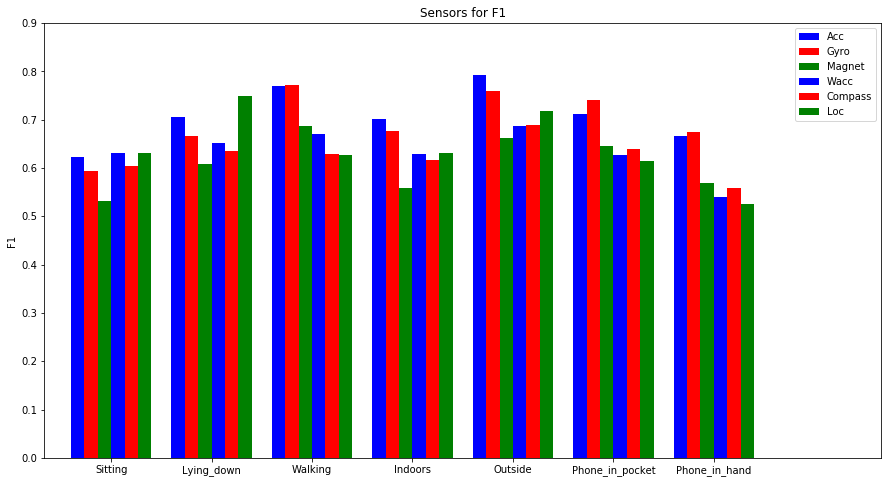

In [297]:
#For ploting F1 comparison chart
x = ["Sitting","Lying_down","Walking","Indoors","Outside",\
    "Phone_in_pocket","Phone_in_hand"];
ind = np.arange(len(x));
ind = ind * 1.5;
#each element represent the F1 from specific sensor for specific label
l1 = [0.62284,0.59308,0.53124,0.63063,0.60369,0.63013];
l2 = [0.70482,0.66642,0.60856,0.65090,0.63480,0.74827];
l3 = [0.77016,0.77165,0.68669,0.67049,0.62979,0.62646];
l4 = [0.70217,0.67727,0.55905,0.62964,0.61613,0.63015];
l5 = [0.79295,0.75961,0.66114,0.68741,0.68880,0.71754];
l6 = [0.71084,0.73995,0.64618,0.62686,0.63877,0.61462];
l7 = [0.66596,0.67478,0.56845,0.53892,0.55792,0.52560];
#the F1 result for predicting each label from each sensor
y1 = [l1[0],l2[0],l3[0],l4[0],l5[0],l6[0],l7[0]];
y2 = [l1[1],l2[1],l3[1],l4[1],l5[1],l6[1],l7[1]];
y3 = [l1[2],l2[2],l3[2],l4[2],l5[2],l6[2],l7[2]];
y4 = [l1[3],l2[3],l3[3],l4[3],l5[3],l6[3],l7[3]];
y5 = [l1[4],l2[4],l3[4],l4[4],l5[4],l6[4],l7[4]];
y6 = [l1[5],l2[5],l3[5],l4[5],l5[5],l6[5],l7[5]];
fig,ax = plt.subplots(figsize=(15,8));
p1 = plt.bar(ind-0.5,y1,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind-0.3,y2,facecolor = 'red',width=0.2);
p3 = plt.bar(ind-0.1,y3,facecolor = 'green',width=0.2);
p4 = plt.bar(ind+0.1,y4,facecolor = 'blue',width=0.2);
p5 = plt.bar(ind+0.3,y5,facecolor = 'red',width=0.2);
p6 = plt.bar(ind+0.5,y6,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_ylabel('F1');
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-1,11.5);
ax.set_title('Sensors for F1');
ax.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('Acc','Gyro','Magnet','Wacc','Compass','Loc','Aud'),loc = 1);
plt.show()

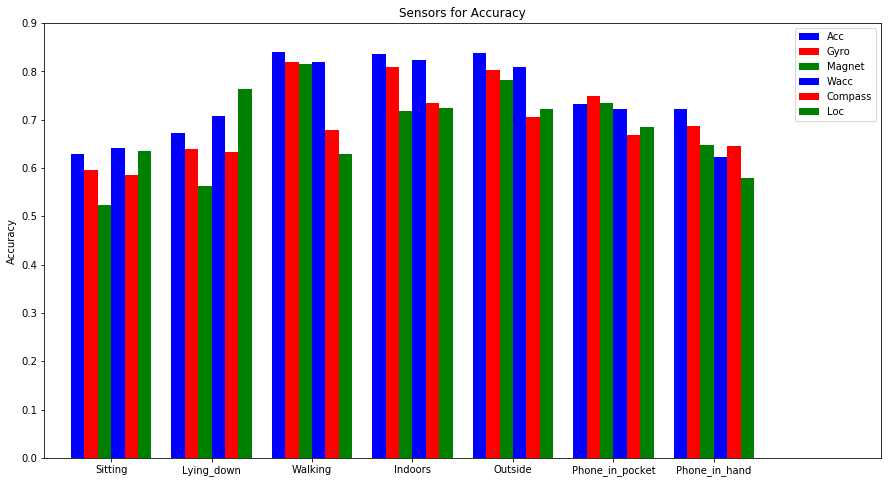

In [305]:
#For ploting accuracy comparison chart
x = ["Sitting","Lying_down","Walking","Indoors","Outside",\
    "Phone_in_pocket","Phone_in_hand"];
ind = np.arange(len(x));
ind = ind * 1.5;
l1 = [0.62855,0.59548,0.52376,0.64233,0.58638,0.63456];
l2 = [0.67223,0.63855,0.56223,0.70663,0.63354,0.76347];
l3 = [0.83927,0.81991,0.81556,0.81860,0.67868,0.62939];
l4 = [0.83501,0.80938,0.71799,0.82366,0.73441,0.72366];
l5 = [0.83892,0.80360,0.78191,0.80935,0.70503,0.72209];
l6 = [0.73329,0.74872,0.73394,0.72235,0.66807,0.68550];
l7 = [0.72299,0.68728,0.64670,0.62274,0.64523,0.57864];
y1 = [l1[0],l2[0],l3[0],l4[0],l5[0],l6[0],l7[0]];
y2 = [l1[1],l2[1],l3[1],l4[1],l5[1],l6[1],l7[1]];
y3 = [l1[2],l2[2],l3[2],l4[2],l5[2],l6[2],l7[2]];
y4 = [l1[3],l2[3],l3[3],l4[3],l5[3],l6[3],l7[3]];
y5 = [l1[4],l2[4],l3[4],l4[4],l5[4],l6[4],l7[4]];
y6 = [l1[5],l2[5],l3[5],l4[5],l5[5],l6[5],l7[5]];
fig,ax = plt.subplots(figsize=(15,8));
p1 = plt.bar(ind-0.5,y1,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind-0.3,y2,facecolor = 'red',width=0.2);
p3 = plt.bar(ind-0.1,y3,facecolor = 'green',width=0.2);
p4 = plt.bar(ind+0.1,y4,facecolor = 'blue',width=0.2);
p5 = plt.bar(ind+0.3,y5,facecolor = 'red',width=0.2);
p6 = plt.bar(ind+0.5,y6,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_ylabel('Accuracy');
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-1,11.5);
ax.set_title('Sensors for Accuracy');
ax.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('Acc','Gyro','Magnet','Wacc','Compass','Loc','Aud'),loc = 1);
plt.show()

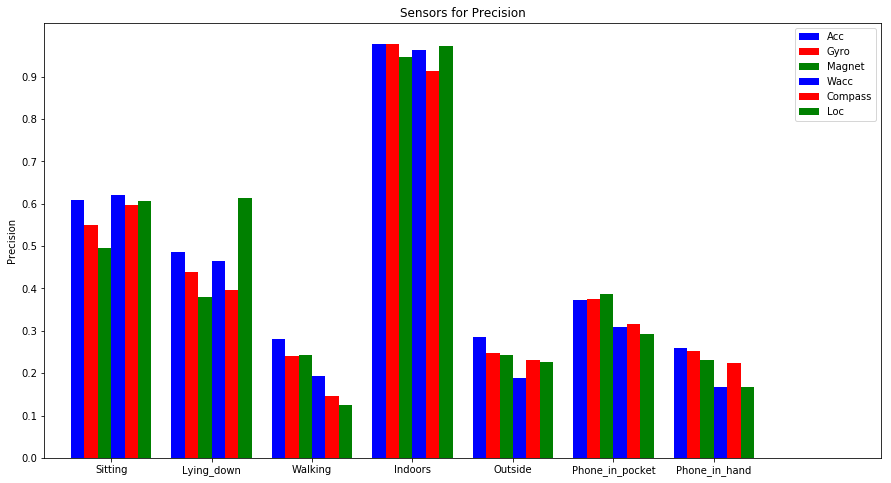

In [304]:
#For ploting accuracy comparison chart
x = ["Sitting","Lying_down","Walking","Indoors","Outside",\
    "Phone_in_pocket","Phone_in_hand"];
ind = np.arange(len(x));
ind = ind * 1.5;
l1 = [0.60910,0.54870,0.49613,0.62068,0.59665,0.60654];
l2 = [0.48555,0.43773,0.38008,0.46490,0.39750,0.61409];
l3 = [0.28154,0.24082,0.24249,0.19333,0.14539,0.12475];
l4 = [0.97789,0.97724,0.94600,0.96232,0.91267,0.97209];
l5 = [0.28621,0.24755,0.24410,0.18949,0.23112,0.22570];
l6 = [0.37335,0.37445,0.38581,0.30893,0.31506,0.29184];
l7 = [0.26025,0.25193,0.23182,0.16770,0.22459,0.16641];
y1 = [l1[0],l2[0],l3[0],l4[0],l5[0],l6[0],l7[0]];
y2 = [l1[1],l2[1],l3[1],l4[1],l5[1],l6[1],l7[1]];
y3 = [l1[2],l2[2],l3[2],l4[2],l5[2],l6[2],l7[2]];
y4 = [l1[3],l2[3],l3[3],l4[3],l5[3],l6[3],l7[3]];
y5 = [l1[4],l2[4],l3[4],l4[4],l5[4],l6[4],l7[4]];
y6 = [l1[5],l2[5],l3[5],l4[5],l5[5],l6[5],l7[5]];
fig,ax = plt.subplots(figsize=(15,8));
p1 = plt.bar(ind-0.5,y1,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind-0.3,y2,facecolor = 'red',width=0.2);
p3 = plt.bar(ind-0.1,y3,facecolor = 'green',width=0.2);
p4 = plt.bar(ind+0.1,y4,facecolor = 'blue',width=0.2);
p5 = plt.bar(ind+0.3,y5,facecolor = 'red',width=0.2);
p6 = plt.bar(ind+0.5,y6,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_ylabel('Precision');
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-1,11.5);
ax.set_title('Sensors for Precision');
ax.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('Acc','Gyro','Magnet','Wacc','Compass','Loc','Aud'),loc = 1);
plt.show()

5.Early Fusion

In [74]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Acc','Loc']
target_label = 'LYING_DOWN';
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
        test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 43 features from the sensors: Acc, Loc
(374238, 43)
(303723, 43)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(0, 43)
(0,)
*****Epoch 1*****
== Projected the features to 43 features from the sensors: Acc, Loc
(369825, 43)
(296247, 43)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(7476, 43)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.85
Specificity (TNR): 0.66
Balanced accuracy: 0.76
Precision**:       0.48
----------
*****Epoch 2*****
== Projected the features to 43 features from the sensors: Acc, Loc
(374661, 43)
(301042, 43)
(301042,

== Projected the features to 43 features from the sensors: Acc, Loc
(374096, 43)
(301069, 43)
(301069,)
== Training with 301069 examples. For label 'Lying down' we have 103073 positive and 197996 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(2654, 43)
(2654,)
== Testing with 2654 examples. For label 'Lying down' we have 1137 positive and 1517 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.65
Specificity (TNR): 0.75
Balanced accuracy: 0.70
Precision**:       0.66
----------
*****Epoch 16*****
== Projected the features to 43 features from the sensors: Acc, Loc
(371399, 43)
(300916, 43)
(300916,)
== Training with 300916 examples. For label 'Lying down' we have 103977 positive and 196939 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(2807, 43)
(2807,)
== Testing with 2807 examples. For label 'Lying down' we have 233 positive and 2574 negative examples.
----------
Accuracy*:       

== Projected the features to 43 features from the sensors: Acc, Loc
(373895, 43)
(301888, 43)
(301888,)
== Training with 301888 examples. For label 'Lying down' we have 103871 positive and 198017 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(1835, 43)
(1835,)
== Testing with 1835 examples. For label 'Lying down' we have 339 positive and 1496 negative examples.
----------
Accuracy*:         0.63
Sensitivity (TPR): 0.71
Specificity (TNR): 0.61
Balanced accuracy: 0.66
Precision**:       0.29
----------
*****Epoch 31*****
== Projected the features to 43 features from the sensors: Acc, Loc
(368874, 43)
(295638, 43)
(295638,)
== Training with 295638 examples. For label 'Lying down' we have 101096 positive and 194542 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(8085, 43)
(8085,)
== Testing with 8085 examples. For label 'Lying down' we have 3114 positive and 4971 negative examples.
----------
Accuracy*:       

== Projected the features to 43 features from the sensors: Acc, Loc
(367387, 43)
(295747, 43)
(295747,)
== Training with 295747 examples. For label 'Lying down' we have 100188 positive and 195559 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(7976, 43)
(7976,)
== Testing with 7976 examples. For label 'Lying down' we have 4022 positive and 3954 negative examples.
----------
Accuracy*:         0.80
Sensitivity (TPR): 0.96
Specificity (TNR): 0.64
Balanced accuracy: 0.80
Precision**:       0.73
----------
*****Epoch 46*****
== Projected the features to 43 features from the sensors: Acc, Loc
(367660, 43)
(294327, 43)
(294327,)
== Training with 294327 examples. For label 'Lying down' we have 101463 positive and 192864 negative examples.
== Projected the features to 43 features from the sensors: Acc, Loc
(9396, 43)
(9396,)
== Testing with 9396 examples. For label 'Lying down' we have 2747 positive and 6649 negative examples.
----------
Accuracy*:      

In [75]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print '***'
print final_acc;
print final_ba;
print final_precise;
print '***'

***
0.708329808524
0.72486932728
0.522426096503
***


In [76]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Acc','Loc','WAcc']
target_label = 'LYING_DOWN';
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
        test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(374238, 89)
(303723, 89)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(0, 89)
(0,)
*****Epoch 1*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(369825, 89)
(296247, 89)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(7476, 89)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.89
Specificity (TNR): 0.86
Balanced accuracy: 0.87
Precision**:       0.69
----------
*****Epoch 2*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(374

== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(374096, 89)
(301069, 89)
(301069,)
== Training with 301069 examples. For label 'Lying down' we have 103073 positive and 197996 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(2654, 89)
(2654,)
== Testing with 2654 examples. For label 'Lying down' we have 1137 positive and 1517 negative examples.
----------
Accuracy*:         0.78
Sensitivity (TPR): 0.83
Specificity (TNR): 0.74
Balanced accuracy: 0.79
Precision**:       0.71
----------
*****Epoch 16*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(371399, 89)
(300916, 89)
(300916,)
== Training with 300916 examples. For label 'Lying down' we have 103977 positive and 196939 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(2807, 89)
(2807,)
== Testing with 2807 examples. For label 'Lying down' we have 233 positive and 2574 negative examples.
----

== Training with 295582 examples. For label 'Lying down' we have 101637 positive and 193945 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(8141, 89)
(8141,)
== Testing with 8141 examples. For label 'Lying down' we have 2573 positive and 5568 negative examples.
----------
Accuracy*:         0.84
Sensitivity (TPR): 0.87
Specificity (TNR): 0.82
Balanced accuracy: 0.85
Precision**:       0.69
----------
*****Epoch 30*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(373895, 89)
(301888, 89)
(301888,)
== Training with 301888 examples. For label 'Lying down' we have 103871 positive and 198017 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(1835, 89)
(1835,)
== Testing with 1835 examples. For label 'Lying down' we have 339 positive and 1496 negative examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.12
Specificity (TNR): 0.76
Balanced accuracy: 0.44
Precisi

== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(367807, 89)
(294833, 89)
(294833,)
== Training with 294833 examples. For label 'Lying down' we have 100778 positive and 194055 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(8890, 89)
(8890,)
== Testing with 8890 examples. For label 'Lying down' we have 3432 positive and 5458 negative examples.
----------
Accuracy*:         0.74
Sensitivity (TPR): 0.75
Specificity (TNR): 0.74
Balanced accuracy: 0.74
Precision**:       0.64
----------
*****Epoch 45*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(367387, 89)
(295747, 89)
(295747,)
== Training with 295747 examples. For label 'Lying down' we have 100188 positive and 195559 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(7976, 89)
(7976,)
== Testing with 7976 examples. For label 'Lying down' we have 4022 positive and 3954 negative examples.
---

== Training with 302485 examples. For label 'Lying down' we have 104185 positive and 198300 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(1238, 89)
(1238,)
== Testing with 1238 examples. For label 'Lying down' we have 25 positive and 1213 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.80
Specificity (TNR): 0.89
Balanced accuracy: 0.85
Precision**:       0.13
----------
*****Epoch 59*****
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(372373, 89)
(301565, 89)
(301565,)
== Training with 301565 examples. For label 'Lying down' we have 103694 positive and 197871 negative examples.
== Projected the features to 89 features from the sensors: Acc, Loc, WAcc
(2158, 89)
(2158,)
== Testing with 2158 examples. For label 'Lying down' we have 516 positive and 1642 negative examples.
----------
Accuracy*:         0.94
Sensitivity (TPR): 0.90
Specificity (TNR): 0.95
Balanced accuracy: 0.92
Precision

In [77]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print '***'
print final_acc;
print final_ba;
print final_precise;
print '***'

***
0.771126654536
0.771019513694
0.591609681683
***


In [78]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Acc','Loc','Aud']
target_label = 'LYING_DOWN';
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
        test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(374238, 69)
(303723, 69)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(0, 69)
(0,)
*****Epoch 1*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(369825, 69)
(296247, 69)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(7476, 69)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.58
Specificity (TNR): 0.97
Balanced accuracy: 0.78
Precision**:       0.87
----------
*****Epoch 2*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(374661, 

== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(374096, 69)
(301069, 69)
(301069,)
== Training with 301069 examples. For label 'Lying down' we have 103073 positive and 197996 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(2654, 69)
(2654,)
== Testing with 2654 examples. For label 'Lying down' we have 1137 positive and 1517 negative examples.
----------
Accuracy*:         0.77
Sensitivity (TPR): 0.77
Specificity (TNR): 0.77
Balanced accuracy: 0.77
Precision**:       0.71
----------
*****Epoch 16*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(371399, 69)
(300916, 69)
(300916,)
== Training with 300916 examples. For label 'Lying down' we have 103977 positive and 196939 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(2807, 69)
(2807,)
== Testing with 2807 examples. For label 'Lying down' we have 233 positive and 2574 negative examples.
--------

== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(8141, 69)
(8141,)
== Testing with 8141 examples. For label 'Lying down' we have 2573 positive and 5568 negative examples.
----------
Accuracy*:         0.85
Sensitivity (TPR): 0.97
Specificity (TNR): 0.80
Balanced accuracy: 0.88
Precision**:       0.69
----------
*****Epoch 30*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(373895, 69)
(301888, 69)
(301888,)
== Training with 301888 examples. For label 'Lying down' we have 103871 positive and 198017 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(1835, 69)
(1835,)
== Testing with 1835 examples. For label 'Lying down' we have 339 positive and 1496 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.21
Specificity (TNR): 0.84
Balanced accuracy: 0.53
Precision**:       0.23
----------
*****Epoch 31*****
== Projected the features to 69 features from the sensors: Acc, Loc

(367807, 69)
(294833, 69)
(294833,)
== Training with 294833 examples. For label 'Lying down' we have 100778 positive and 194055 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(8890, 69)
(8890,)
== Testing with 8890 examples. For label 'Lying down' we have 3432 positive and 5458 negative examples.
----------
Accuracy*:         0.79
Sensitivity (TPR): 0.84
Specificity (TNR): 0.76
Balanced accuracy: 0.80
Precision**:       0.69
----------
*****Epoch 45*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(367387, 69)
(295747, 69)
(295747,)
== Training with 295747 examples. For label 'Lying down' we have 100188 positive and 195559 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(7976, 69)
(7976,)
== Testing with 7976 examples. For label 'Lying down' we have 4022 positive and 3954 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.92
Specificity (TNR): 0.

== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(1238, 69)
(1238,)
== Testing with 1238 examples. For label 'Lying down' we have 25 positive and 1213 negative examples.
----------
Accuracy*:         0.92
Sensitivity (TPR): 0.72
Specificity (TNR): 0.92
Balanced accuracy: 0.82
Precision**:       0.16
----------
*****Epoch 59*****
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(372373, 69)
(301565, 69)
(301565,)
== Training with 301565 examples. For label 'Lying down' we have 103694 positive and 197871 negative examples.
== Projected the features to 69 features from the sensors: Acc, Loc, Aud
(2158, 69)
(2158,)
== Testing with 2158 examples. For label 'Lying down' we have 516 positive and 1642 negative examples.
----------
Accuracy*:         0.97
Sensitivity (TPR): 0.91
Specificity (TNR): 0.99
Balanced accuracy: 0.95
Precision**:       0.96
----------


In [79]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print '***'
print final_acc;
print final_ba;
print final_precise;
print '***'

***
0.787354004233
0.783989855505
0.632259896732
***


In [80]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
#sensor_set = ['Acc','Loc']
target_label = 'LYING_DOWN';
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
        test_lr_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(374238, 172)
(303723, 172)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(0, 172)
(0,)
*****Epoch 1*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(369825, 172)
(296247, 172)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(7476, 172)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
----------
Accuracy*:         0.93
Sensitivity (TPR): 0.81
Specificity (TNR): 0.97
Balanced accuracy: 0.89
Precision**:       0.92
----------
*****Epoch

== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(370655, 172)
(297668, 172)
(297668,)
== Training with 297668 examples. For label 'Lying down' we have 103004 positive and 194664 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(6055, 172)
(6055,)
== Testing with 6055 examples. For label 'Lying down' we have 1206 positive and 4849 negative examples.
----------
Accuracy*:         0.87
Sensitivity (TPR): 0.72
Specificity (TNR): 0.91
Balanced accuracy: 0.82
Precision**:       0.67
----------
*****Epoch 15*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(374096, 172)
(301069, 172)
(301069,)
== Training with 301069 examples. For label 'Lying down' we have 103073 positive and 197996 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(2654, 172)
(2654,)
== Testing with 2654 

== Training with 302058 examples. For label 'Lying down' we have 103625 positive and 198433 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(1665, 172)
(1665,)
== Testing with 1665 examples. For label 'Lying down' we have 585 positive and 1080 negative examples.
----------
Accuracy*:         0.75
Sensitivity (TPR): 0.35
Specificity (TNR): 0.97
Balanced accuracy: 0.66
Precision**:       0.88
----------
*****Epoch 28*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(373448, 172)
(299943, 172)
(299943,)
== Training with 299943 examples. For label 'Lying down' we have 103858 positive and 196085 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(3780, 172)
(3780,)
== Testing with 3780 examples. For label 'Lying down' we have 352 positive and 3428 negative examples.
----------
Accuracy*:         0.76
Sensitivity (TPR

== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(8315, 172)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
----------
Accuracy*:         0.73
Sensitivity (TPR): 0.87
Specificity (TNR): 0.66
Balanced accuracy: 0.76
Precision**:       0.53
----------
*****Epoch 41*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(367585, 172)
(294319, 172)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(9404, 172)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
----------
Accuracy*:         0.89
Sensitivity (TPR): 0.80
Specificity (TNR): 0.94
Balanced accuracy: 0.87
Precision**:       0.89
----------
*****Epoch 42*****

== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(374486, 172)
(300889, 172)
(300889,)
== Training with 300889 examples. For label 'Lying down' we have 102949 positive and 197940 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(2834, 172)
(2834,)
== Testing with 2834 examples. For label 'Lying down' we have 1261 positive and 1573 negative examples.
----------
Accuracy*:         0.71
Sensitivity (TPR): 0.57
Specificity (TNR): 0.83
Balanced accuracy: 0.70
Precision**:       0.73
----------
*****Epoch 55*****
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(373731, 172)
(300193, 172)
(300193,)
== Training with 300193 examples. For label 'Lying down' we have 103741 positive and 196452 negative examples.
== Projected the features to 172 features from the sensors: Acc, Gyro, Magnet, WAcc, Loc, Aud
(3530, 172)
(3530,)
== Testing with 3530 

In [81]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print '***'
print final_acc;
print final_ba;
print final_precise;
print '***'

***
0.81330794852
0.801825503641
0.660738233358
***


Compare different fusion:

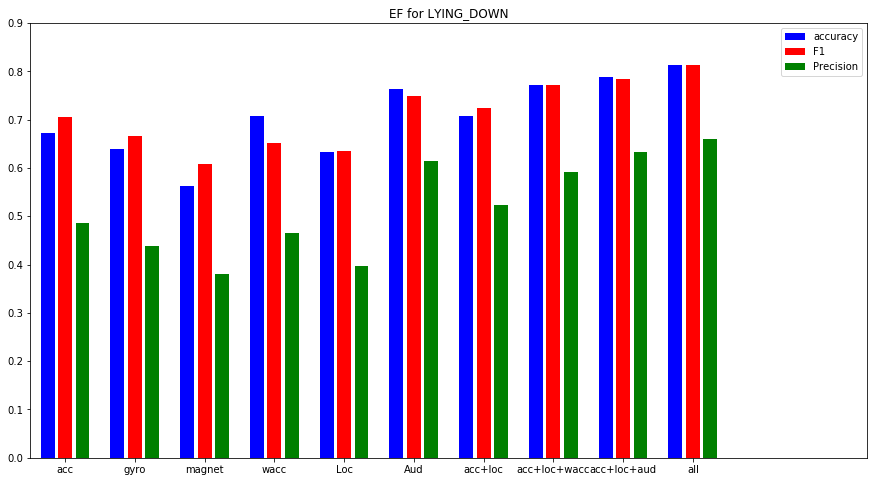

In [288]:
x = ["acc","gyro","magnet","wacc","Loc","Aud",\
     "acc+loc","acc+loc+wacc","acc+loc+aud","all"];
ind = np.arange(len(x));
a_y = [0.67223,0.63855,0.56223,0.70663,0.63354,0.76347,0.70832,0.77112,0.78735,0.81330];
b_y = [0.70482,0.66642,0.60856,0.65090,0.63480,0.74827,0.72486,0.77101,0.78398,0.81330];
c_y = [0.48555,0.43773,0.38008,0.46490,0.39750,0.61409,0.52242,0.59160,0.63225,0.66073];
fig,ax = plt.subplots(figsize=(15,8));
p1 = plt.bar(ind-0.25,a_y,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind,b_y,facecolor = 'red',width=0.2);
p3 = plt.bar(ind+0.25,c_y,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-0.5,11.5);
ax.set_title('EF for LYING_DOWN');
ax.legend((p1[0],p2[0],p3[0]),('accuracy','F1','Precision'),loc = 1);
plt.show()

6.LR Model for Late Fusion Classification

In [108]:
#For test part, do regression rather than classification
def test_lr_model_prob(X_test,Y_test,M_test,timestamps,feat_sensor_names,label_names,model):
    #Check if the model is null:
    if model['lr_model'] == None:
        return ;
    
    # Project the feature matrix to the features from the sensors that the classifier is based on:
    X_test = project_features_to_selected_sensors(X_test,feat_sensor_names,model['sensors_to_use']);
    print("== Projected the features to %d features from the sensors: %s" % (X_test.shape[1],', '.join(model['sensors_to_use'])));

    # We should standardize the features the same way the train data was standardized:
    X_test = standardize_features(X_test,model['mean_vec'],model['std_vec']);
    
    # The single target label:
    label_ind = label_names.index(model['target_label']);
    y = Y_test[:,label_ind];
    missing_label = M_test[:,label_ind];
    existing_label = np.logical_not(missing_label);
    
    # Select only the examples that are not missing the target label:
    X_test = X_test[existing_label,:];
    y = y[existing_label];
    timestamps = timestamps[existing_label];
    
    print X_test.shape;
    print y.shape;
    
    #If there is no example
    if len(y) == 0:
        return ;
    
    # Do the same treatment for missing features as done to the training data:
    X_test[np.isnan(X_test)] = 0.;
    
    print("== Testing with %d examples. For label '%s' we have %d positive and %d negative examples." % \
          (len(y),get_label_pretty_name(target_label),sum(y),sum(np.logical_not(y))) );
    
    # Preform the prediction:
    y_pred = model['lr_model'].predict_proba(X_test);
    
    return(y,y_pred);

In [110]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Acc']
target_label = 'LYING_DOWN';
accList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    acc_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if acc_y is not None:
        accList.append((acc_y[0],acc_y[1]));

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Acc
(374238, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 26 features from the sensors: Acc
(0, 26)
(0,)
*****Epoch 1*****
== Projected the features to 26 features from the sensors: Acc
(369825, 26)
(296247, 26)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 26 features from the sensors: Acc
(7476, 26)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 26 features from the sensors: Acc
(374661, 26)
(301042, 26)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 26 features from the sens

== Projected the features to 26 features from the sensors: Acc
(370048, 26)
(296883, 26)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 26 features from the sensors: Acc
(6840, 26)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Acc
(373753, 26)
(300884, 26)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 26 features from the sensors: Acc
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 26 features from the sensors: Acc
(368104, 26)
(294750, 26)
(294750,)
== Training with 294750 examples. For label 'Lying down' we have 100514 

== Projected the features to 26 features from the sensors: Acc
(365350, 26)
(295408, 26)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 26 features from the sensors: Acc
(8315, 26)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 26 features from the sensors: Acc
(367585, 26)
(294319, 26)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 26 features from the sensors: Acc
(9404, 26)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
*****Epoch 42*****
== Projected the features to 26 features from the sensors: Acc
(375746, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210

In [111]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Loc']
target_label = 'LYING_DOWN';
locList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    loc_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if loc_y is not None:
        locList.append((loc_y[0],loc_y[1]));

*****Epoch 0*****
== Projected the features to 17 features from the sensors: Loc
(374238, 17)
(303723, 17)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 17 features from the sensors: Loc
(0, 17)
(0,)
*****Epoch 1*****
== Projected the features to 17 features from the sensors: Loc
(369825, 17)
(296247, 17)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 17 features from the sensors: Loc
(7476, 17)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 17 features from the sensors: Loc
(374661, 17)
(301042, 17)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 17 features from the sens

== Projected the features to 17 features from the sensors: Loc
(370048, 17)
(296883, 17)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 17 features from the sensors: Loc
(6840, 17)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 17 features from the sensors: Loc
(373753, 17)
(300884, 17)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 17 features from the sensors: Loc
(2839, 17)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 17 features from the sensors: Loc
(368104, 17)
(294750, 17)
(294750,)
== Training with 294750 examples. For label 'Lying down' we have 100514 

== Projected the features to 17 features from the sensors: Loc
(365350, 17)
(295408, 17)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 17 features from the sensors: Loc
(8315, 17)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 17 features from the sensors: Loc
(367585, 17)
(294319, 17)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 17 features from the sensors: Loc
(9404, 17)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
*****Epoch 42*****
== Projected the features to 17 features from the sensors: Loc
(375746, 17)
(303723, 17)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210

In [113]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['WAcc']
target_label = 'LYING_DOWN';
waccList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    wacc_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if wacc_y is not None:
        waccList.append((wacc_y[0],wacc_y[1]));

*****Epoch 0*****
== Projected the features to 46 features from the sensors: WAcc
(374238, 46)
(303723, 46)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(0, 46)
(0,)
*****Epoch 1*****
== Projected the features to 46 features from the sensors: WAcc
(369825, 46)
(296247, 46)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(7476, 46)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 46 features from the sensors: WAcc
(374661, 46)
(301042, 46)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 46 features from the

== Projected the features to 46 features from the sensors: WAcc
(370048, 46)
(296883, 46)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(6840, 46)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 46 features from the sensors: WAcc
(373753, 46)
(300884, 46)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(2839, 46)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 46 features from the sensors: WAcc
(368104, 46)
(294750, 46)
(294750,)
== Training with 294750 examples. For label 'Lying down' we have 10

== Projected the features to 46 features from the sensors: WAcc
(365350, 46)
(295408, 46)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(8315, 46)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 46 features from the sensors: WAcc
(367585, 46)
(294319, 46)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 46 features from the sensors: WAcc
(9404, 46)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
*****Epoch 42*****
== Projected the features to 46 features from the sensors: WAcc
(375746, 46)
(303723, 46)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 1

In [114]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Aud']
target_label = 'LYING_DOWN';
audList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    aud_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if aud_y is not None:
        audList.append((aud_y[0],aud_y[1]));

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Aud
(374238, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 26 features from the sensors: Aud
(0, 26)
(0,)
*****Epoch 1*****
== Projected the features to 26 features from the sensors: Aud
(369825, 26)
(296247, 26)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 26 features from the sensors: Aud
(7476, 26)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 26 features from the sensors: Aud
(374661, 26)
(301042, 26)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 26 features from the sens

== Projected the features to 26 features from the sensors: Aud
(370048, 26)
(296883, 26)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 26 features from the sensors: Aud
(6840, 26)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Aud
(373753, 26)
(300884, 26)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 26 features from the sensors: Aud
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 26 features from the sensors: Aud
(368104, 26)
(294750, 26)
(294750,)
== Training with 294750 examples. For label 'Lying down' we have 100514 

== Projected the features to 26 features from the sensors: Aud
(365350, 26)
(295408, 26)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 26 features from the sensors: Aud
(8315, 26)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 26 features from the sensors: Aud
(367585, 26)
(294319, 26)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 26 features from the sensors: Aud
(9404, 26)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
*****Epoch 42*****
== Projected the features to 26 features from the sensors: Aud
(375746, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210

In [115]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Gyro']
target_label = 'LYING_DOWN';
gyList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    gy_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if gy_y is not None:
        gyList.append((gy_y[0],gy_y[1]));

*****Epoch 0*****
== Projected the features to 26 features from the sensors: Gyro
(374238, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(0, 26)
(0,)
*****Epoch 1*****
== Projected the features to 26 features from the sensors: Gyro
(369825, 26)
(296247, 26)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(7476, 26)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 26 features from the sensors: Gyro
(374661, 26)
(301042, 26)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 26 features from the

== Projected the features to 26 features from the sensors: Gyro
(370048, 26)
(296883, 26)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(6840, 26)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 26 features from the sensors: Gyro
(373753, 26)
(300884, 26)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(2839, 26)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 26 features from the sensors: Gyro
(368104, 26)
(294750, 26)
(294750,)
== Training with 294750 examples. For label 'Lying down' we have 10

== Projected the features to 26 features from the sensors: Gyro
(365350, 26)
(295408, 26)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(8315, 26)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 26 features from the sensors: Gyro
(367585, 26)
(294319, 26)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 26 features from the sensors: Gyro
(9404, 26)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positive and 5914 negative examples.
*****Epoch 42*****
== Projected the features to 26 features from the sensors: Gyro
(375746, 26)
(303723, 26)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 1

In [116]:
sensor_set = ['Acc','Gyro','Magnet','WAcc','Loc','Aud'];
sensor_set = ['Magnet']
target_label = 'LYING_DOWN';
magList = [];
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_lr_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    mag_y =\
        test_lr_model_prob(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);
    if mag_y is not None:
        magList.append((mag_y[0],mag_y[1]));

*****Epoch 0*****
== Projected the features to 31 features from the sensors: Magnet
(374238, 31)
(303723, 31)
(303723,)
== Training with 303723 examples. For label 'Lying down' we have 104210 positive and 199513 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(0, 31)
(0,)
*****Epoch 1*****
== Projected the features to 31 features from the sensors: Magnet
(369825, 31)
(296247, 31)
(296247,)
== Training with 296247 examples. For label 'Lying down' we have 102221 positive and 194026 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(7476, 31)
(7476,)
== Testing with 7476 examples. For label 'Lying down' we have 1989 positive and 5487 negative examples.
*****Epoch 2*****
== Projected the features to 31 features from the sensors: Magnet
(374661, 31)
(301042, 31)
(301042,)
== Training with 301042 examples. For label 'Lying down' we have 103462 positive and 197580 negative examples.
== Projected the features to 31 feature

== Projected the features to 31 features from the sensors: Magnet
(370048, 31)
(296883, 31)
(296883,)
== Training with 296883 examples. For label 'Lying down' we have 101710 positive and 195173 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(6840, 31)
(6840,)
== Testing with 6840 examples. For label 'Lying down' we have 2500 positive and 4340 negative examples.
*****Epoch 21*****
== Projected the features to 31 features from the sensors: Magnet
(373753, 31)
(300884, 31)
(300884,)
== Training with 300884 examples. For label 'Lying down' we have 103996 positive and 196888 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2839, 31)
(2839,)
== Testing with 2839 examples. For label 'Lying down' we have 214 positive and 2625 negative examples.
*****Epoch 22*****
== Projected the features to 31 features from the sensors: Magnet
(368104, 31)
(294750, 31)
(294750,)
== Training with 294750 examples. For label 'Lying down' 

== Projected the features to 31 features from the sensors: Magnet
(5741, 31)
(5741,)
== Testing with 5741 examples. For label 'Lying down' we have 1394 positive and 4347 negative examples.
*****Epoch 40*****
== Projected the features to 31 features from the sensors: Magnet
(365350, 31)
(295408, 31)
(295408,)
== Training with 295408 examples. For label 'Lying down' we have 101664 positive and 193744 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(8315, 31)
(8315,)
== Testing with 8315 examples. For label 'Lying down' we have 2546 positive and 5769 negative examples.
*****Epoch 41*****
== Projected the features to 31 features from the sensors: Magnet
(367585, 31)
(294319, 31)
(294319,)
== Training with 294319 examples. For label 'Lying down' we have 100720 positive and 193599 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(9404, 31)
(9404,)
== Testing with 9404 examples. For label 'Lying down' we have 3490 positi

== Training with 301565 examples. For label 'Lying down' we have 103694 positive and 197871 negative examples.
== Projected the features to 31 features from the sensors: Magnet
(2158, 31)
(2158,)
== Testing with 2158 examples. For label 'Lying down' we have 516 positive and 1642 negative examples.


In [201]:
#Concatenate all the test_y and its preds
def concat_y(sList, newNP):
    for c, s in enumerate(sList,1):
        newNP = np.concatenate((newNP,s[0]),axis=0); 
    return newNP;
def concat_y_prob(sList,newNP):
    for c, s in enumerate(sList,1):
        newNP = np.concatenate((newNP,s[1][:,1]),axis=0); 
    return newNP;

In [202]:
total_y = accList[0][0];
total_acc = accList[0][1][:,1];
total_loc = locList[0][1][:,1];
total_wacc = waccList[0][1][:,1];
total_aud = audList[0][1][:,1];
total_gy = gyList[0][1][:,1];
total_mag = magList[0][1][:,1];

total_y = concat_y(accList,total_y);
total_acc = concat_y_prob(accList,total_acc);
total_loc = concat_y_prob(locList,total_loc);
total_wacc = concat_y_prob(waccList,total_wacc);
total_aud = concat_y_prob(audList,total_aud);
total_gy = concat_y_prob(gyList,total_gy);
total_mag = concat_y_prob(magList,total_mag);

In [203]:
#set weights for LFL
#sum is 1
#it could be useful for hierarchical model
weights = np.array([0.2,0.3,0.2,0,0,0.1]);

In [204]:
#For late fusion average (LFA)
def avg_late_fusion(p1,p2,p3,p4,p5,p6):
    avg_y = (p1+p2+p3+p4+p5+p6)/6;
    return avg_y;

In [205]:
#For late fusion with learned weights (LFL)
def weight_late_fusion(p1,p2,p3,p4,p5,p6,w):
    avg_y = (p1*w[0]+p2*w[1]+p3*w[2]+p4*w[3]+p5*w[4]+p6*w[5]);
    return avg_y;

In [206]:
#Get final prediction:
def final_pred(avg_y):
    for c in range(len(avg_y)):
        if avg_y[c] >= 0.5:
            avg_y[c] = 1;
        else:
            avg_y[c] = 0;
    return avg_y;    

In [207]:
lfa_pred = avg_late_fusion(total_acc,total_loc,total_wacc,total_aud,total_gy,total_mag);
lfa_pred = final_pred(lfa_pred);
lfa_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [208]:
lfl_pred = weight_late_fusion(total_acc,total_loc,total_wacc,total_aud,total_gy,total_mag,weights);
lfl_pred = final_pred(lfl_pred);
lfl_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [209]:
lfa_pred.astype(bool)

array([False, False, False, ..., False, False, False], dtype=bool)

In [210]:
lfl_pred.astype(bool)

array([False, False, False, ..., False, False, False], dtype=bool)

In [211]:
total_y

array([False, False, False, ..., False, False, False], dtype=bool)

In [212]:
def get_result(y,y_pred):
    # Naive accuracy (correct classification rate):
    accuracy = np.mean(y_pred == y);
    
    # Count occorrences of true-positive, true-negative, false-positive, and false-negative:
    tp = np.sum(np.logical_and(y_pred,y));
    tn = np.sum(np.logical_and(np.logical_not(y_pred),np.logical_not(y)));
    fp = np.sum(np.logical_and(y_pred,np.logical_not(y)));
    fn = np.sum(np.logical_and(np.logical_not(y_pred),y));
    
    sensitivity = 0;
    specificity = 0;
    precision = 0;
    
    # Sensitivity (=recall=true positive rate) and Specificity (=true negative rate):
    if tp+fn != 0:
        sensitivity = float(tp) / (tp+fn);
    if tn+fp != 0:
        specificity = float(tn) / (tn+fp);
    
    # Balanced accuracy is a more fair replacement for the naive accuracy:
    balanced_accuracy = (sensitivity + specificity) / 2.;
    
    # Precision:
    # Beware from this metric, since it may be too sensitive to rare labels.
    # In the ExtraSensory Dataset, there is large skew among the positive and negative classes,
    # and for each label the pos/neg ratio is different.
    # This can cause undesirable and misleading results when averaging precision across different labels.
    if tp+fp != 0:
        precision = float(tp) / (tp+fp);
    
    print("-"*10);
    print('Accuracy*:         %.2f' % accuracy);
    print('Sensitivity (TPR): %.2f' % sensitivity);
    print('Specificity (TNR): %.2f' % specificity);
    print('Balanced accuracy: %.2f' % balanced_accuracy);
    print('Precision**:       %.2f' % precision);
    print("-"*10);
    
    return(accuracy,balanced_accuracy,precision);

In [213]:
(lfa_a,lfa_b,lfa_p) = get_result(total_y,lfa_pred.astype(bool));

----------
Accuracy*:         0.78
Sensitivity (TPR): 0.86
Specificity (TNR): 0.73
Balanced accuracy: 0.80
Precision**:       0.63
----------


In [214]:
(lfl_a,lfl_b,lfl_p) = get_result(total_y,lfl_pred.astype(bool));

----------
Accuracy*:         0.73
Sensitivity (TPR): 0.29
Specificity (TNR): 0.96
Balanced accuracy: 0.63
Precision**:       0.78
----------


Compare LFA and LFL:

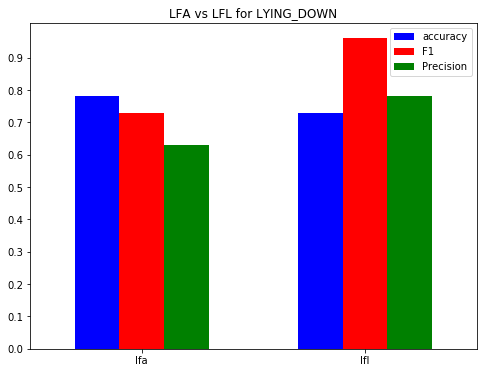

In [287]:
x = ["lfa","lfl"];
ind = np.arange(len(x));
a_y = [0.78,0.73];
b_y = [0.73,0.96];
c_y = [0.63,0.78];
fig,ax = plt.subplots(figsize=(8,6));
p1 = plt.bar(ind-0.2,a_y,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind,b_y,facecolor = 'red',width=0.2);
p3 = plt.bar(ind+0.2,c_y,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-0.5,1.5);
ax.set_title('LFA vs LFL for LYING_DOWN');
ax.legend((p1[0],p2[0],p3[0]),('accuracy','F1','Precision'),loc = 1);
plt.show()

7.Compare all the result

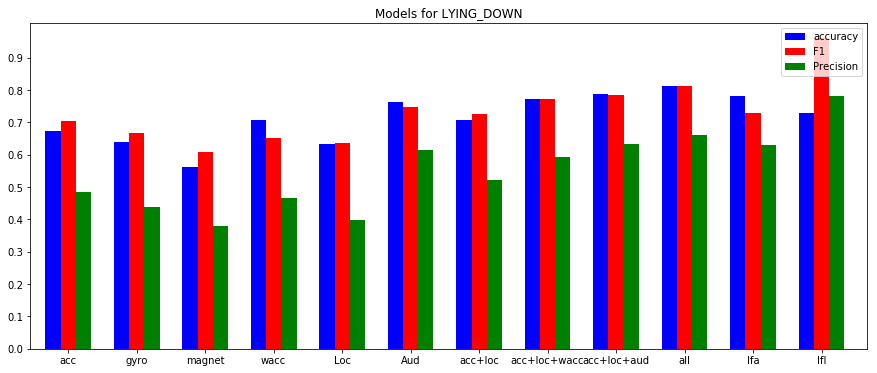

In [303]:
x = ["acc","gyro","magnet","wacc","Loc","Aud",\
     "acc+loc","acc+loc+wacc","acc+loc+aud","all","lfa","lfl"];
ind = np.arange(len(x));
ind = ind * 0.9;
a_y = [0.67223,0.63855,0.56223,0.70663,0.63354,0.76347,0.70832,0.77112,0.78735,0.81330,0.78,0.73];
b_y = [0.70482,0.66642,0.60856,0.65090,0.63480,0.74827,0.72486,0.77101,0.78398,0.81330,0.73,0.96];
c_y = [0.48555,0.43773,0.38008,0.46490,0.39750,0.61409,0.52242,0.59160,0.63225,0.66073,0.63,0.78];
fig,ax = plt.subplots(figsize=(15,6));
p1 = plt.bar(ind-0.2,a_y,facecolor = 'blue',width=0.2);
p2 = plt.bar(ind,b_y,facecolor = 'red',width=0.2);
p3 = plt.bar(ind+0.2,c_y,facecolor = 'green',width=0.2);
ax.set_xticks(ind);
ax.set_xticklabels(x);
ax.set_yticks(np.arange(0, 1, step=0.1));
ax.set_xlim(-0.5,10.5);
ax.set_title('Models for LYING_DOWN');
ax.legend((p1[0],p2[0],p3[0]),('accuracy','F1','Precision'),loc = 1);
plt.show()

8.MLP Model for LYING_DOWN:

In [65]:
target_label = ['LYING_DOWN'];
acc = np.zeros(60);
ba = np.zeros(60);
precise = np.zeros(60);
for i in range(60):
    print ('*****Epoch %d*****' % i)
    (test_uuid,train_uuid) = split_train_test_uuids(i,txtdata);
    (train_X,train_Y,train_M,train_time,train_feature,train_label,\
     test_X,test_Y,test_M,test_time,test_feature,test_label) =\
     get_train_test_set2(i);
    sensor_to_use = sensor_set;
    model = train_mlp_model(train_X,train_Y,train_M,feat_sensor_names,\
                            label_names,sensor_to_use,target_label);
    (acc[i],ba[i],precise[i]) =\
        test_mlp_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,model);

*****Epoch 0*****
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(374238, 164)
(374238,)
(303723, 164)
(303723, 1)
Iteration 1, loss = 0.36851137
Iteration 2, loss = 0.30443225
Iteration 3, loss = 0.28799549
Iteration 4, loss = 0.27867454
Iteration 5, loss = 0.27265349
Iteration 6, loss = 0.26854060
Iteration 7, loss = 0.26586229
Iteration 8, loss = 0.26367878
Iteration 9, loss = 0.26185513
Iteration 10, loss = 0.26043713
Iteration 11, loss = 0.25929288
Iteration 12, loss = 0.25815982
Iteration 13, loss = 0.25726723
Iteration 14, loss = 0.25637404
Iteration 15, loss = 0.25560460
Iteration 16, loss = 0.25492773
Iteration 17, loss = 0.25445126
Iteration 18, loss = 0.25373921
Iteration 19, loss = 0.25343746
Iteration 20, loss = 0.25280428
Iteration 21, loss = 0.25248183
Iteration 22, loss = 0.25192737
Iteration 23, loss = 0.25162578
Iteration 24, loss = 0.25137521
Iteration 25, loss = 0.25104121
Iteration 26, loss = 0.25080864
Iteration 2

Iteration 23, loss = 0.24751188
Iteration 24, loss = 0.24704856
Iteration 25, loss = 0.24677757
Iteration 26, loss = 0.24637109
Iteration 27, loss = 0.24600417
Iteration 28, loss = 0.24577040
Iteration 29, loss = 0.24552383
Iteration 30, loss = 0.24513062
Iteration 31, loss = 0.24476708
Iteration 32, loss = 0.24444933
Iteration 33, loss = 0.24416906
Iteration 34, loss = 0.24404903
Iteration 35, loss = 0.24371307
Iteration 36, loss = 0.24341374
Iteration 37, loss = 0.24320893
Iteration 38, loss = 0.24268778
Iteration 39, loss = 0.24264030
Iteration 40, loss = 0.24247321
Iteration 41, loss = 0.24228085
Iteration 42, loss = 0.24203203
Iteration 43, loss = 0.24183496
Iteration 44, loss = 0.24172676
Iteration 45, loss = 0.24148508
Iteration 46, loss = 0.24120295
Iteration 47, loss = 0.24106701
Iteration 48, loss = 0.24110361
Iteration 49, loss = 0.24081746
Iteration 50, loss = 0.24070451
Iteration 51, loss = 0.24040568
Iteration 52, loss = 0.24028633
Iteration 53, loss = 0.24019049
Iteratio

Iteration 23, loss = 0.24599458
Iteration 24, loss = 0.24557572
Iteration 25, loss = 0.24522609
Iteration 26, loss = 0.24497563
Iteration 27, loss = 0.24448883
Iteration 28, loss = 0.24427199
Iteration 29, loss = 0.24395905
Iteration 30, loss = 0.24345479
Iteration 31, loss = 0.24332716
Iteration 32, loss = 0.24299828
Iteration 33, loss = 0.24279271
Iteration 34, loss = 0.24251334
Iteration 35, loss = 0.24228248
Iteration 36, loss = 0.24211412
Iteration 37, loss = 0.24182295
Iteration 38, loss = 0.24167794
Iteration 39, loss = 0.24159900
Iteration 40, loss = 0.24134762
Iteration 41, loss = 0.24113907
Iteration 42, loss = 0.24105418
Iteration 43, loss = 0.24087170
Iteration 44, loss = 0.24072150
Iteration 45, loss = 0.24070639
Iteration 46, loss = 0.24058765
Iteration 47, loss = 0.24022185
Iteration 48, loss = 0.24012063
Iteration 49, loss = 0.24000515
Iteration 50, loss = 0.23985393
Iteration 51, loss = 0.23979274
Iteration 52, loss = 0.23961791
Iteration 53, loss = 0.23965763
Iteratio

Iteration 13, loss = 0.25851618
Iteration 14, loss = 0.25749442
Iteration 15, loss = 0.25655091
Iteration 16, loss = 0.25554460
Iteration 17, loss = 0.25463858
Iteration 18, loss = 0.25398905
Iteration 19, loss = 0.25318651
Iteration 20, loss = 0.25286881
Iteration 21, loss = 0.25218125
Iteration 22, loss = 0.25165395
Iteration 23, loss = 0.25112524
Iteration 24, loss = 0.25067130
Iteration 25, loss = 0.25042267
Iteration 26, loss = 0.24983574
Iteration 27, loss = 0.24967553
Iteration 28, loss = 0.24936560
Iteration 29, loss = 0.24912733
Iteration 30, loss = 0.24869813
Iteration 31, loss = 0.24830137
Iteration 32, loss = 0.24805332
Iteration 33, loss = 0.24775224
Iteration 34, loss = 0.24740601
Iteration 35, loss = 0.24716216
Iteration 36, loss = 0.24671507
Iteration 37, loss = 0.24655381
Iteration 38, loss = 0.24627473
Iteration 39, loss = 0.24612464
Iteration 40, loss = 0.24586332
Iteration 41, loss = 0.24554769
Iteration 42, loss = 0.24529544
Iteration 43, loss = 0.24487154
Iteratio

----------
Accuracy*:         0.90
Sensitivity (TPR): 0.07
Specificity (TNR): 0.93
Balanced accuracy: 0.50
Precision**:       0.03
----------
*****Epoch 12*****
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(371174, 164)
(371174,)
(298929, 164)
(298929, 1)
Iteration 1, loss = 0.38123384
Iteration 2, loss = 0.31583479
Iteration 3, loss = 0.29640761
Iteration 4, loss = 0.28488371
Iteration 5, loss = 0.27702369
Iteration 6, loss = 0.27175744
Iteration 7, loss = 0.26777447
Iteration 8, loss = 0.26498554
Iteration 9, loss = 0.26283140
Iteration 10, loss = 0.26109435
Iteration 11, loss = 0.25960988
Iteration 12, loss = 0.25841447
Iteration 13, loss = 0.25741103
Iteration 14, loss = 0.25631729
Iteration 15, loss = 0.25561338
Iteration 16, loss = 0.25500966
Iteration 17, loss = 0.25431948
Iteration 18, loss = 0.25385491
Iteration 19, loss = 0.25337756
Iteration 20, loss = 0.25273620
Iteration 21, loss = 0.25219053
Iteration 22, loss = 0.25213

Iteration 9, loss = 0.26131391
Iteration 10, loss = 0.25999952
Iteration 11, loss = 0.25864190
Iteration 12, loss = 0.25771827
Iteration 13, loss = 0.25692556
Iteration 14, loss = 0.25588338
Iteration 15, loss = 0.25512002
Iteration 16, loss = 0.25453553
Iteration 17, loss = 0.25378666
Iteration 18, loss = 0.25343214
Iteration 19, loss = 0.25265244
Iteration 20, loss = 0.25225766
Iteration 21, loss = 0.25174885
Iteration 22, loss = 0.25106937
Iteration 23, loss = 0.25059338
Iteration 24, loss = 0.25022919
Iteration 25, loss = 0.24967493
Iteration 26, loss = 0.24937405
Iteration 27, loss = 0.24886668
Iteration 28, loss = 0.24869650
Iteration 29, loss = 0.24816885
Iteration 30, loss = 0.24784997
Iteration 31, loss = 0.24760676
Iteration 32, loss = 0.24720824
Iteration 33, loss = 0.24679401
Iteration 34, loss = 0.24666362
Iteration 35, loss = 0.24657381
Iteration 36, loss = 0.24604809
Iteration 37, loss = 0.24566118
Iteration 38, loss = 0.24531810
Iteration 39, loss = 0.24515175
Iteration

Iteration 43, loss = 0.24616098
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(5920, 164)
(5920, 1)
== Testing with 5920 examples.
----------
Accuracy*:         0.61
Sensitivity (TPR): 0.28
Specificity (TNR): 0.72
Balanced accuracy: 0.50
Precision**:       0.26
----------
*****Epoch 19*****
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(368179, 164)
(368179,)
(296321, 164)
(296321, 1)
Iteration 1, loss = 0.37283329
Iteration 2, loss = 0.31263451
Iteration 3, loss = 0.29432680
Iteration 4, loss = 0.28334627
Iteration 5, loss = 0.27576210
Iteration 6, loss = 0.27078415
Iteration 7, loss = 0.26702320
Iteration 8, loss = 0.26440357
Iteration 9, loss = 0.26222579
Iteration 10, loss = 0.26055891
Iteration 11, loss = 0.25908097
Iteration 12, loss = 0.25793709
Iteration 13, loss = 0.25674097
Iteration 

== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(368104, 164)
(368104,)
(294750, 164)
(294750, 1)
Iteration 1, loss = 0.36203595
Iteration 2, loss = 0.30244260
Iteration 3, loss = 0.28306037
Iteration 4, loss = 0.27272537
Iteration 5, loss = 0.26627944
Iteration 6, loss = 0.26194463
Iteration 7, loss = 0.25887462
Iteration 8, loss = 0.25663584
Iteration 9, loss = 0.25483870
Iteration 10, loss = 0.25352286
Iteration 11, loss = 0.25218972
Iteration 12, loss = 0.25140062
Iteration 13, loss = 0.25047343
Iteration 14, loss = 0.24967280
Iteration 15, loss = 0.24919540
Iteration 16, loss = 0.24850492
Iteration 17, loss = 0.24795451
Iteration 18, loss = 0.24755672
Iteration 19, loss = 0.24703319
Iteration 20, loss = 0.24676135
Iteration 21, loss = 0.24642470
Iteration 22, loss = 0.24593548
Iteration 23, loss = 0.24569179
Iteration 24, loss = 0.24525398
Iteration 25, loss = 0.24496431
Iteration 26, loss = 0.24455714
Iteration 27, loss = 0.244270

Iteration 58, loss = 0.23896472
Iteration 59, loss = 0.23899302
Iteration 60, loss = 0.23895666
Iteration 61, loss = 0.23860673
Iteration 62, loss = 0.23883215
Iteration 63, loss = 0.23845313
Iteration 64, loss = 0.23848811
Iteration 65, loss = 0.23817011
Iteration 66, loss = 0.23835734
Iteration 67, loss = 0.23806898
Iteration 68, loss = 0.23797582
Iteration 69, loss = 0.23795551
Iteration 70, loss = 0.23797544
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(4406, 164)
(4406, 1)
== Testing with 4406 examples.
----------
Accuracy*:         0.50
Sensitivity (TPR): 0.54
Specificity (TNR): 0.46
Balanced accuracy: 0.50
Precision**:       0.44
----------
*****Epoch 25*****
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(371527, 164)
(371527,)
(301936, 164)
(301936, 1)
Iteration 1, loss = 0.37810927
It

Iteration 68, loss = 0.24065703
Iteration 69, loss = 0.24051392
Iteration 70, loss = 0.24051701
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(1665, 164)
(1665, 1)
== Testing with 1665 examples.
----------
Accuracy*:         0.64
Sensitivity (TPR): 0.02
Specificity (TNR): 0.98
Balanced accuracy: 0.50
Precision**:       0.35
----------
*****Epoch 28*****
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(373448, 164)
(373448,)
(299943, 164)
(299943, 1)
Iteration 1, loss = 0.37838123
Iteration 2, loss = 0.32113223
Iteration 3, loss = 0.30006749
Iteration 4, loss = 0.28849424
Iteration 5, loss = 0.28124475
Iteration 6, loss = 0.27595255
Iteration 7, loss = 0.27230214
Iteration 8, loss = 0.26920497
Iteration 9, loss = 0.26671766
Iteration 10, loss = 0.26467016
Iteration 11, loss = 0.26293276
Iteration 

Iteration 51, loss = 0.24550512
Iteration 52, loss = 0.24525536
Iteration 53, loss = 0.24528112
Iteration 54, loss = 0.24509970
Iteration 55, loss = 0.24492204
Iteration 56, loss = 0.24464637
Iteration 57, loss = 0.24469761
Iteration 58, loss = 0.24438578
Iteration 59, loss = 0.24431591
Iteration 60, loss = 0.24422841
Iteration 61, loss = 0.24398849
Iteration 62, loss = 0.24393431
Iteration 63, loss = 0.24383740
Iteration 64, loss = 0.24360645
Iteration 65, loss = 0.24364783
Iteration 66, loss = 0.24343367
Iteration 67, loss = 0.24341775
Iteration 68, loss = 0.24306631
Iteration 69, loss = 0.24308374
Iteration 70, loss = 0.24294148
Iteration 71, loss = 0.24290578
Iteration 72, loss = 0.24274016
Iteration 73, loss = 0.24258490
Iteration 74, loss = 0.24251796
Iteration 75, loss = 0.24244622
Iteration 76, loss = 0.24222891
Iteration 77, loss = 0.24214195
Iteration 78, loss = 0.24193194
Iteration 79, loss = 0.24185255
Iteration 80, loss = 0.24169371
Iteration 81, loss = 0.24182548
Iteratio

Iteration 31, loss = 0.24933139
Iteration 32, loss = 0.24921207
Iteration 33, loss = 0.24887529
Iteration 34, loss = 0.24857756
Iteration 35, loss = 0.24839175
Iteration 36, loss = 0.24837236
Iteration 37, loss = 0.24797418
Iteration 38, loss = 0.24796103
Iteration 39, loss = 0.24764641
Iteration 40, loss = 0.24755886
Iteration 41, loss = 0.24717980
Iteration 42, loss = 0.24700652
Iteration 43, loss = 0.24670256
Iteration 44, loss = 0.24657472
Iteration 45, loss = 0.24647836
Iteration 46, loss = 0.24633941
Iteration 47, loss = 0.24612118
Iteration 48, loss = 0.24593076
Iteration 49, loss = 0.24582833
Iteration 50, loss = 0.24573272
Iteration 51, loss = 0.24574377
Iteration 52, loss = 0.24551537
Iteration 53, loss = 0.24543250
Iteration 54, loss = 0.24522187
Iteration 55, loss = 0.24521024
Iteration 56, loss = 0.24512371
Iteration 57, loss = 0.24507603
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features fro

Iteration 45, loss = 0.24023158
Iteration 46, loss = 0.24012907
Iteration 47, loss = 0.23989160
Iteration 48, loss = 0.23998721
Iteration 49, loss = 0.23970417
Iteration 50, loss = 0.23964498
Iteration 51, loss = 0.23942456
Iteration 52, loss = 0.23937606
Iteration 53, loss = 0.23939118
Iteration 54, loss = 0.23924585
Iteration 55, loss = 0.23910119
Iteration 56, loss = 0.23893759
Iteration 57, loss = 0.23888923
Iteration 58, loss = 0.23864825
Iteration 59, loss = 0.23858554
Iteration 60, loss = 0.23841981
Iteration 61, loss = 0.23840001
Iteration 62, loss = 0.23826682
Iteration 63, loss = 0.23810678
Iteration 64, loss = 0.23802069
Iteration 65, loss = 0.23793880
Iteration 66, loss = 0.23767895
Iteration 67, loss = 0.23767658
Iteration 68, loss = 0.23770667
Iteration 69, loss = 0.23752411
Iteration 70, loss = 0.23731728
Iteration 71, loss = 0.23730097
Iteration 72, loss = 0.23726781
Iteration 73, loss = 0.23721538
Training loss did not improve more than tol=0.000100 for two consecutive

Iteration 19, loss = 0.25043724
Iteration 20, loss = 0.24989905
Iteration 21, loss = 0.24896793
Iteration 22, loss = 0.24826102
Iteration 23, loss = 0.24756101
Iteration 24, loss = 0.24700394
Iteration 25, loss = 0.24636049
Iteration 26, loss = 0.24604135
Iteration 27, loss = 0.24544319
Iteration 28, loss = 0.24506249
Iteration 29, loss = 0.24470349
Iteration 30, loss = 0.24449390
Iteration 31, loss = 0.24405639
Iteration 32, loss = 0.24384537
Iteration 33, loss = 0.24349098
Iteration 34, loss = 0.24323699
Iteration 35, loss = 0.24305827
Iteration 36, loss = 0.24283673
Iteration 37, loss = 0.24245175
Iteration 38, loss = 0.24247187
Iteration 39, loss = 0.24220234
Iteration 40, loss = 0.24196759
Iteration 41, loss = 0.24196874
Iteration 42, loss = 0.24185426
Iteration 43, loss = 0.24142332
Iteration 44, loss = 0.24137073
Iteration 45, loss = 0.24127935
Iteration 46, loss = 0.24107238
Iteration 47, loss = 0.24092102
Iteration 48, loss = 0.24074850
Iteration 49, loss = 0.24055044
Iteratio

Iteration 21, loss = 0.25168218
Iteration 22, loss = 0.25113623
Iteration 23, loss = 0.25052906
Iteration 24, loss = 0.25006810
Iteration 25, loss = 0.24959767
Iteration 26, loss = 0.24912988
Iteration 27, loss = 0.24873873
Iteration 28, loss = 0.24846385
Iteration 29, loss = 0.24809724
Iteration 30, loss = 0.24767447
Iteration 31, loss = 0.24726521
Iteration 32, loss = 0.24703957
Iteration 33, loss = 0.24678465
Iteration 34, loss = 0.24621277
Iteration 35, loss = 0.24589480
Iteration 36, loss = 0.24566853
Iteration 37, loss = 0.24524995
Iteration 38, loss = 0.24522322
Iteration 39, loss = 0.24496231
Iteration 40, loss = 0.24467074
Iteration 41, loss = 0.24439012
Iteration 42, loss = 0.24410732
Iteration 43, loss = 0.24382291
Iteration 44, loss = 0.24361996
Iteration 45, loss = 0.24361650
Iteration 46, loss = 0.24318160
Iteration 47, loss = 0.24305545
Iteration 48, loss = 0.24280410
Iteration 49, loss = 0.24274832
Iteration 50, loss = 0.24251958
Iteration 51, loss = 0.24227047
Iteratio

Iteration 34, loss = 0.24724136
Iteration 35, loss = 0.24694980
Iteration 36, loss = 0.24672365
Iteration 37, loss = 0.24643573
Iteration 38, loss = 0.24633296
Iteration 39, loss = 0.24610752
Iteration 40, loss = 0.24591511
Iteration 41, loss = 0.24574166
Iteration 42, loss = 0.24537136
Iteration 43, loss = 0.24524359
Iteration 44, loss = 0.24509286
Iteration 45, loss = 0.24501654
Iteration 46, loss = 0.24473747
Iteration 47, loss = 0.24465029
Iteration 48, loss = 0.24443157
Iteration 49, loss = 0.24436009
Iteration 50, loss = 0.24427949
Iteration 51, loss = 0.24400644
Iteration 52, loss = 0.24385077
Iteration 53, loss = 0.24375790
Iteration 54, loss = 0.24363838
Iteration 55, loss = 0.24346004
Iteration 56, loss = 0.24339470
Iteration 57, loss = 0.24308094
Iteration 58, loss = 0.24300619
Iteration 59, loss = 0.24292556
Iteration 60, loss = 0.24295211
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features fro

Iteration 23, loss = 0.24977690
Iteration 24, loss = 0.24918921
Iteration 25, loss = 0.24891028
Iteration 26, loss = 0.24877807
Iteration 27, loss = 0.24842563
Iteration 28, loss = 0.24802911
Iteration 29, loss = 0.24791920
Iteration 30, loss = 0.24767710
Iteration 31, loss = 0.24745762
Iteration 32, loss = 0.24714666
Iteration 33, loss = 0.24688688
Iteration 34, loss = 0.24641184
Iteration 35, loss = 0.24615877
Iteration 36, loss = 0.24598978
Iteration 37, loss = 0.24579589
Iteration 38, loss = 0.24541300
Iteration 39, loss = 0.24545693
Iteration 40, loss = 0.24519960
Iteration 41, loss = 0.24490129
Iteration 42, loss = 0.24488510
Iteration 43, loss = 0.24482615
Iteration 44, loss = 0.24452723
Iteration 45, loss = 0.24435315
Iteration 46, loss = 0.24418359
Iteration 47, loss = 0.24416705
Iteration 48, loss = 0.24395755
Iteration 49, loss = 0.24390933
Iteration 50, loss = 0.24370799
Iteration 51, loss = 0.24363594
Iteration 52, loss = 0.24357022
Iteration 53, loss = 0.24360442
Training

Iteration 44, loss = 0.24521643
Iteration 45, loss = 0.24514448
Iteration 46, loss = 0.24521877
Iteration 47, loss = 0.24496780
Iteration 48, loss = 0.24479772
Iteration 49, loss = 0.24450825
Iteration 50, loss = 0.24456119
Iteration 51, loss = 0.24425835
Iteration 52, loss = 0.24419308
Iteration 53, loss = 0.24398646
Iteration 54, loss = 0.24388832
Iteration 55, loss = 0.24367386
Iteration 56, loss = 0.24343344
Iteration 57, loss = 0.24325021
Iteration 58, loss = 0.24325860
Iteration 59, loss = 0.24304068
Iteration 60, loss = 0.24300760
Iteration 61, loss = 0.24304529
Iteration 62, loss = 0.24275128
Iteration 63, loss = 0.24262894
Iteration 64, loss = 0.24257730
Iteration 65, loss = 0.24250762
Iteration 66, loss = 0.24245243
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features from the sensors: Acc, Gyro, Magnet, WAcc, Compass, Aud
(5887, 164)
(5887, 1)
== Testing with 5887 examples.
----------
Accuracy*: 

Iteration 53, loss = 0.24034868
Iteration 54, loss = 0.24016249
Iteration 55, loss = 0.24022524
Iteration 56, loss = 0.24007039
Iteration 57, loss = 0.23983921
Iteration 58, loss = 0.23984968
Iteration 59, loss = 0.23986056
Iteration 60, loss = 0.23965654
Iteration 61, loss = 0.23948676
Iteration 62, loss = 0.23951481
Iteration 63, loss = 0.23952240
Iteration 64, loss = 0.23937737
Iteration 65, loss = 0.23931227
Iteration 66, loss = 0.23917533
Iteration 67, loss = 0.23910644
Iteration 68, loss = 0.23895588
Iteration 69, loss = 0.23892111
Iteration 70, loss = 0.23870795
Iteration 71, loss = 0.23894459
Iteration 72, loss = 0.23855974
Iteration 73, loss = 0.23857652
Iteration 74, loss = 0.23850360
Iteration 75, loss = 0.23839968
Iteration 76, loss = 0.23829085
Iteration 77, loss = 0.23828454
Iteration 78, loss = 0.23815398
Iteration 79, loss = 0.23828228
Iteration 80, loss = 0.23818187
Iteration 81, loss = 0.23802349
Iteration 82, loss = 0.23796024
Iteration 83, loss = 0.23781102
Iteratio

Iteration 38, loss = 0.24526108
Iteration 39, loss = 0.24496231
Iteration 40, loss = 0.24484024
Iteration 41, loss = 0.24451184
Iteration 42, loss = 0.24462511
Iteration 43, loss = 0.24420054
Iteration 44, loss = 0.24433886
Iteration 45, loss = 0.24405818
Iteration 46, loss = 0.24373357
Iteration 47, loss = 0.24374736
Iteration 48, loss = 0.24357343
Iteration 49, loss = 0.24351299
Iteration 50, loss = 0.24329538
Iteration 51, loss = 0.24330408
Iteration 52, loss = 0.24307698
Iteration 53, loss = 0.24301146
Iteration 54, loss = 0.24288740
Iteration 55, loss = 0.24271186
Iteration 56, loss = 0.24270627
Iteration 57, loss = 0.24253120
Iteration 58, loss = 0.24240800
Iteration 59, loss = 0.24204082
Iteration 60, loss = 0.24196572
Iteration 61, loss = 0.24179725
Iteration 62, loss = 0.24171910
Iteration 63, loss = 0.24162231
Iteration 64, loss = 0.24164643
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
== Projected the features to 164 features fro

In [66]:
count = 0;
for i in range(0,60):
    if acc[i] == 1.0:
        count+=1;
final_acc = (np.sum(acc) - count)/(60-count);
final_ba = (np.sum(ba) - count)/(60-count);
final_precise = (np.sum(precise) - count)/(60-count);
print '***'
print final_acc;
print final_ba;
print final_precise;
print '***'

***
0.605142868913
0.5
0.327163360807
***


Save model into disk:

In [ ]:
from sklearn.externals import joblib;
filename = 'Model.sav';
joblib.dump(model,filename);
test_mlp_model(test_X,test_Y,test_M,test_time,feat_sensor_names,label_names,joblib.load(filename));